# Openclassrooms PJ4 : transats dataset : modelisation notebook

# Global variables and functions used in the notebook

In [1]:
%matplotlib inline

import os
import zipfile
import urllib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import qgrid

import glob

from pandas.plotting import scatter_matrix

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.model_selection import GridSearchCV

# Final model evaluation measures, for customer :
# EVALUATION_PERCENT of the time, prediction errors will be below EVALUATION_THRESHOLD minutes
EVALUATION_PERCENT = 0.9  # 90% of the time
EVALUATION_THRESHOLD = 5

SAMPLED_DATA = True  # If True : data is sampled (NB_SAMPLES instances only) for faster testing purposes
NB_SAMPLES = 80000
#NB_SAMPLES = 800000
#NB_SAMPLES = 500000
LEARNING_CURVE_STEP_SIZE = int(NB_SAMPLES / 10) # Change that when you change NB_SAMPLES size

DATA_PATH = os.path.join("datasets", "transats")
DATA_PATH = os.path.join(DATA_PATH, "out")

DATA_PATH_FILE_INPUT = os.path.join(DATA_PATH, "transats_metadata_transformed.csv")


ALL_FEATURES = ['ORIGIN','CRS_DEP_TIME','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','DEST','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME','ARR_DELAY','DEP_DELAY', 'TAXI_OUT', 'TAIL_NUM', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT']

'''
MODEL1_FEATURES = ['ORIGIN','CRS_DEP_TIME','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','DEST','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME']
MODEL1_LABEL = 'ARR_DELAY'
'''

MODEL1_FEATURES = ['ORIGIN','CRS_DEP_TIME','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','DEST','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT']
MODEL1_FEATURES_QUANTITATIVE = ['CRS_DEP_TIME','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT']

MODEL1_GOUPBYMEAN_FEATURES = ['CRS_DEP_TIME','MONTH','DAY_OF_MONTH','DEST','DISTANCE','CRS_ELAPSED_TIME', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'CRS_ARR_TIME', 'DAY_OF_WEEK', 'NBFLIGHTS_FORDAY_FORAIRPORT', 'ORIGIN', 'UNIQUE_CARRIER']
MODEL_GROUPBYMEAN_FEATURES_QUANTITATIVE = ['CRS_DEP_TIME','MONTH','DAY_OF_MONTH','DISTANCE','CRS_ELAPSED_TIME', 'DEST', 'CRS_ARR_TIME', 'DAY_OF_WEEK', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'ORIGIN', 'UNIQUE_CARRIER' ]


MODEL1bis_FEATURES_QUANTITATIVE = ['CRS_DEP_TIME','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT']
MODEL1_LABEL = 'ARR_DELAY'

MODEL_1HOTALL_FEATURES = ['DISTANCE', 'CRS_ELAPSED_TIME', 'NBFLIGHTS_FORDAY_FORAIRPORT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'ORIGIN', 'UNIQUE_CARRIER', 'CRS_DEP_TIME']
MODEL_1HOTALL_FEATURES_QUANTITATIVE = ['DISTANCE', 'CRS_ELAPSED_TIME', 'NBFLIGHTS_FORDAY_FORAIRPORT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT']
# For later : maybe not include CRS_ELAPSED_TIME because close to DISTANCE


MODEL_GROUPBYMEAN2_FEATURES = ['DISTANCE', 'CRS_ELAPSED_TIME', 'NBFLIGHTS_FORDAY_FORAIRPORT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'ORIGIN', 'UNIQUE_CARRIER', 'CRS_DEP_TIME']
MODEL_GROUPBYMEAN2_FEATURES_QUANTITATIVE = ['DISTANCE', 'CRS_ELAPSED_TIME', 'NBFLIGHTS_FORDAY_FORAIRPORT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'ORIGIN', 'UNIQUE_CARRIER', 'CRS_DEP_TIME']


MODEL1_3FEATS = ['DISTANCE', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'DEP_DELAY']
MODEL1_3FEATS_QUANTITATIVE = ['DISTANCE', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'DEP_DELAY']

MODEL1_2FEATS = ['DISTANCE', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT']
MODEL1_2FEATS_QUANTITATIVE = ['DISTANCE', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT']



MODEL_cheat_FEATURES = ['ARR_DELAY','ORIGIN','CRS_DEP_TIME','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','DEST','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT']
MODEL_cheat_FEATURES_QUANTITATIVE = ['ARR_DELAY','CRS_DEP_TIME','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT']

plt.rcParams["figure.figsize"] = [16,9] # Taille par défaut des figures de matplotlib

import seaborn as sns
sns.set()

#import common_functions

####### Paramètres pour sauver et restaurer les modèles :
import pickle
####### Paramètres à changer par l'utilisateur selon son besoin :

RECOMPUTE_GRIDSEARCH = False  # CAUTION : computation is several hours long
SAVE_GRID_RESULTS = False # If True : grid results object will be saved to pickle files that have GRIDSEARCH_FILE_PREFIX
LOAD_GRID_RESULTS = True # If True : grid results object will be loaded from pickle files that have GRIDSEARCH_FILE_PREFIX
                          # Grid search results are loaded with full samples (SAMPLED_DATA must be False)

'''
RECOMPUTE_GRIDSEARCH = True  # CAUTION : computation is several hours long
SAVE_GRID_RESULTS = True # If True : grid results object will be saved to pickle files that have GRIDSEARCH_FILE_PREFIX
LOAD_GRID_RESULTS = False # If True : grid results object will be loaded from pickle files that have GRIDSEARCH_FILE_PREFIX
'''
#GRIDSEARCH_CSV_FILE = 'grid_search_results.csv'

GRIDSEARCH_FILE_PREFIX = 'grid_search_results_'

EXECUTE_INTERMEDIATE_MODELS = False # If True: every intermediate model (which results are manually analyzed in the notebook) will be executed


# Necessary for predictors used in the notebook :
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import PolynomialFeatures


### For progress bar :
from tqdm import tqdm_notebook as tqdm

# Statsmodel : 
import statsmodels.formula.api as smf

import statsmodels.api as sm
from scipy import stats

SAVE_API_MODEL = True # If True : API model ill be saved
API_MODEL_PICKLE_FILE = 'API_model_PJ4.pickle'


In [2]:
def qgrid_show(df):
    display(qgrid.show_grid(df, grid_options={'forceFitColumns': False, 'defaultColumnWidth': 170}))

In [3]:
def load_data():
    # hhmm timed features formatted
    feats_hhmm = ['CRS_DEP_TIME',  'CRS_ARR_TIME']

    df = pd.read_csv(DATA_PATH_FILE_INPUT, sep=',', header=0, encoding='utf-8', low_memory=False, parse_dates=feats_hhmm)   
    
    # Drop outliers (low quantile data : extreme delays not enough represented)
    df.drop(index=df[(df['ARR_DELAY'] < df.ARR_DELAY.quantile(.01)) | (df['ARR_DELAY'] > df.ARR_DELAY.quantile(.99))].index, axis=0, inplace=True)
    
    return(df)

In [4]:
def load_data_with_outliers():
    # hhmm timed features formatted
    feats_hhmm = ['CRS_DEP_TIME',  'CRS_ARR_TIME']

    df = pd.read_csv(DATA_PATH_FILE_INPUT, sep=',', header=0, encoding='utf-8', low_memory=False, parse_dates=feats_hhmm)   
        
    return(df)

In [5]:
def custom_train_test_split_sample(df):
    from sklearn.model_selection import train_test_split
    
    if (SAMPLED_DATA == True):
        df_labels_discrete = pd.cut(df['ARR_DELAY'], bins=50)
        #df = df.sample(NB_SAMPLES).copy(deep=True)
        df, df2 = train_test_split(df, train_size=NB_SAMPLES, random_state=42, shuffle = True, stratify = df_labels_discrete)
        
    df_labels_discrete = pd.cut(df['ARR_DELAY'], bins=50)
    
    df_train, df_test = train_test_split(df, test_size=0.1, random_state=42, shuffle = True, stratify = df_labels_discrete)
    #df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)
    
    df_train = df_train.copy()
    df_test = df_test.copy()

    '''
    # Old code: we sampled only training set. But that's a problem when you encounter values in test set (not sampled) that were not in training set
    if (SAMPLED_DATA == True):
        df_train = df_train.sample(NB_SAMPLES).copy(deep=True)
        df = df.loc[df_train.index]
    '''   
    
    return df, df_train, df_test

In [6]:
def custom_train_test_split_sample_random(df):
    from sklearn.model_selection import train_test_split
    
    if (SAMPLED_DATA == True):
        df = df.sample(NB_SAMPLES).copy(deep=True)
        
    df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)
    
    df_train = df_train.copy()
    df_test = df_test.copy()

    '''
    # Old code: we sampled only training set. But that's a problem when you encounter values in test set (not sampled) that were not in training set
    if (SAMPLED_DATA == True):
        df_train = df_train.sample(NB_SAMPLES).copy(deep=True)
        df = df.loc[df_train.index]
    '''   
    
    return df, df_train, df_test

In [7]:
def print_column_information(df, column_name):
    column_type = df.dtypes[column_name]
    print(f'Column {column_name}, type {column_type}\n')
    print('--------------------------')

    print(df[[column_name]].groupby(column_name).size().sort_values(ascending=False))
    print(df[column_name].unique())    
    print('\n')


In [8]:
def display_percent_complete(df):
    not_na = 100 - (df.isnull().sum() * 100 / len(df))
    not_na_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_complete': not_na}).sort_values(by='percent_complete', ascending=False)
    display(not_na_df)

In [9]:
def identify_features(df):
    all_features = ALL_FEATURES

    model1_features = MODEL1_FEATURES
    model1_label = MODEL1_LABEL
    
    quantitative_features = []
    qualitative_features = []
    features_todrop = []

    for feature_name in all_features:
        if (df[feature_name].dtype == 'object'):
            qualitative_features.append(feature_name)

        else:
            quantitative_features.append(feature_name)

    print(f'Quantitative features : {quantitative_features} \n')
    print(f'Qualitative features : {qualitative_features} \n')  
    
    return all_features, model1_features, model1_label, quantitative_features, qualitative_features

In [10]:
def save_or_load_search_params(grid_search, save_file_suffix):
    if (SAVE_GRID_RESULTS == True):
        #df_grid_search_results = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
        #df_grid_search_results.to_csv(GRIDSEARCH_CSV_FILE)

        df_grid_search_results = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["mean_test_score"])],axis=1)
        df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["std_test_score"], columns=["std_test_score"])],axis=1)
        df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["mean_fit_time"], columns=["mean_fit_time"])],axis=1)
        df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["mean_score_time"], columns=["mean_score_time"])],axis=1)
        df_grid_search_results.to_csv(GRIDSEARCH_FILE_PREFIX + save_file_suffix + '.csv')

        with open(GRIDSEARCH_FILE_PREFIX + save_file_suffix + '.pickle', 'wb') as f:
            pickle.dump(grid_search, f, pickle.HIGHEST_PROTOCOL)
            
        return(grid_search, df_grid_search_results)

    if (LOAD_GRID_RESULTS == True):
        if ((SAVE_GRID_RESULTS == True) or (RECOMPUTE_GRIDSEARCH == True)):
            print('Error : if want to load grid results, you should not have saved them or recomputed them before, or you will loose all your training data')

        else:
            with open(GRIDSEARCH_FILE_PREFIX + save_file_suffix + '.pickle', 'rb') as f:
                grid_search = pickle.load(f)

            df_grid_search_results = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["mean_test_score"])],axis=1)
            df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["std_test_score"], columns=["std_test_score"])],axis=1)
            df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["mean_fit_time"], columns=["mean_fit_time"])],axis=1)
            df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["mean_score_time"], columns=["mean_score_time"])],axis=1)
            
            return(grid_search, df_grid_search_results)

In [11]:
def evaluate_model(model, X_test, Y_test):
    Y_predict = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_predict)
    rmse = np.sqrt(mse)
    print(f'RMSE : {rmse}')
    

In [12]:
def evaluate_model_MAE(model, X_test, Y_test):
    Y_predict = model.predict(X_test)
    mae = mean_absolute_error(Y_test, Y_predict)
    print(f'MAE : {mae}')
    

In [13]:
'''
This function returns the % of absolute errors of the model that are < threshold, percent of the time
'''

def evaluate_model_percent_threshold(model, X_test, Y_test, percent, threshold):
    Y_predict = model.predict(X_test)
    
    Y_AE = np.abs(Y_predict- Y_test)
    Y_AE_best = Y_AE[Y_AE <= Y_AE.quantile(percent)] # Take percent best error values (eliminate errors > Y_AE.quantile(percent))
    
    error_percent_threshold = (len(Y_AE_best[Y_AE_best < threshold]) / len(Y_AE_best)) * 100
    
    return (error_percent_threshold)
    

In [14]:
'''
This function returns the maximum absolute error of the model, percent of the time
'''

def evaluate_model_percent_mean(model, X_test, Y_test, percent):
    Y_predict = model.predict(X_test)
    
    Y_AE = np.abs(Y_predict- Y_test)
    Y_AE_best = Y_AE[Y_AE <= Y_AE.quantile(percent)] # Take percent best error values (eliminate errors > Y_AE.quantile(percent))
    
    error_mean = Y_AE_best.mean()
    
    return (error_mean)

'''
This function returns the maximum absolute error of the model, 1 - percent of the time
'''

def evaluate_model_percent_worst_mean(model, X_test, Y_test, percent):
    Y_predict = model.predict(X_test)
    
    Y_AE = np.abs(Y_predict- Y_test)
    Y_AE_worst = Y_AE[Y_AE > Y_AE.quantile(percent)] # Take percent worst error values (eliminate errors > Y_AE.quantile(percent))
    
    error_mean_worst = Y_AE_worst.mean()
    
    return (error_mean_worst)
    

In [15]:
def minibatch_generate_indexes(df_train_transformed, step_size):
    nb_instances = df_train_transformed.shape[0]
    final_index = nb_instances - 1

    for m in range(int(nb_instances/step_size)):
        left_index = m*step_size
        right_index = m*step_size + step_size - 1

        yield((left_index, right_index))

    # Last step :
    yield((left_index + step_size, final_index))

In [16]:
def plot_learning_curves(model, X_train, X_test, y_train, y_test, step_size, evaluation_method='RMSE'):
    train_errors, val_errors = [], []
    
    minibatch_indexes = minibatch_generate_indexes(X_train, step_size)
    
    # Initiate progress bar
    #nb_instances = len(df_train_transformed)
    nb_instances = df_train_transformed.shape[0]
    nb_iter = int(nb_instances/step_size) + 1    
    progbar = tqdm(range(nb_iter))
    #cnt = 0
    print(f'Calculating learning curve for {nb_iter} iterations')
    
    for (left_index, right_index) in minibatch_indexes:
        model.fit(X_train[:right_index], y_train[:right_index])
        y_train_predict = model.predict(X_train[:right_index])
        y_test_predict = model.predict(X_test)
        
        if (evaluation_method == 'RMSE'):
            train_errors.append(mean_squared_error(y_train[:right_index], y_train_predict))
            val_errors.append(mean_squared_error(y_test, y_test_predict))
            
        elif (evaluation_method == 'MAE'):
            train_errors.append(mean_absolute_error(y_train[:right_index], y_train_predict))
            val_errors.append(mean_absolute_error(y_test, y_test_predict))            
        
        # Update progress bar
        progbar.update(1)
        #cnt += 1

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="test")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set iterations", fontsize=14) # not shown
    
    if (evaluation_method == 'RMSE'):
        plt.ylabel("RMSE", fontsize=14)              # not shown
        
    elif (evaluation_method == 'MAE'):
         plt.ylabel("MAE", fontsize=14)  

In [17]:
#minibatches = minibatch_generate_indexes(df_train_transformed)

In [18]:
def reset_data():
    df = load_data()
    all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)
    df, df_train, df_test = custom_train_test_split_sample(df)

    df_train_transformed = preparation_pipeline_meansort.fit_transform(df_train, categoricalfeatures_1hotencoder__categorical_features_totransform=None)
    df_train_transformed = prediction_pipeline_without_sparse.fit_transform(df_train_transformed)

    df_test_transformed = preparation_pipeline_meansort.transform(df_test)
    df_test_transformed = prediction_pipeline_without_sparse.transform(df_test_transformed)
    
    return df, df_train, df_test, df_train_transformed, df_test_transformed

def reset_data_old():
    df = load_data()
    all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)
    df, df_train, df_test = custom_train_test_split_sample(df)

    df_train_transformed = preparation_pipeline_meansort.fit_transform(df_train)
    df_train_transformed = prediction_pipeline_without_sparse.fit_transform(df_train_transformed)

    df_test_transformed = preparation_pipeline_meansort.transform(df_test)
    df_test_transformed = prediction_pipeline_without_sparse.transform(df_test_transformed)
    df_test_transformed.shape
    
    return df, df_train, df_test, df_train_transformed, df_test_transformed

In [19]:
from IPython.display import display, Markdown
import sys

def display_freq_table(df, col_names):
    for col_name in col_names:    
        effectifs = df[col_name].value_counts(bins=50)

        modalites = effectifs.index # l'index de effectifs contient les modalités


        tab = pd.DataFrame(modalites, columns = [col_name]) # création du tableau à partir des modalités
        tab["Nombre"] = effectifs.values
        tab["Frequence"] = tab["Nombre"] / len(df) # len(data) renvoie la taille de l'échantillon
        tab = tab.sort_values(col_name) # tri des valeurs de la variable X (croissant)
        tab["Freq. cumul"] = tab["Frequence"].cumsum() # cumsum calcule la somme cumulée
        
        display(Markdown('#### ' + col_name))
        display(tab)

In [20]:
class redirect_output(object):
    """context manager for reditrecting stdout/err to files"""
    
    """ 
    Useful to run long code, in order not to loose cell output if you close browser by mistake
    
    Usage in a cell :
    with redirect_output("my_output.txt"):
        Long code  (example : %run my_script.py )
        
    """

    def __init__(self, stdout='', stderr=''):
        self.stdout = stdout
        self.stderr = stderr

    def __enter__(self):
        self.sys_stdout = sys.stdout
        self.sys_stderr = sys.stderr

        if self.stdout:
            sys.stdout = open(self.stdout, 'w')
        if self.stderr:
            if self.stderr == self.stdout:
                sys.stderr = sys.stdout
            else:
                sys.stderr = open(self.stderr, 'w')

    def __exit__(self, exc_type, exc_value, traceback):
        sys.stdout = self.sys_stdout
        sys.stderr = self.sys_stderr

# First naive model

In [21]:
df = load_data_with_outliers()
df, df_train, df_test = custom_train_test_split_sample_random(df)
all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)

Quantitative features : ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT'] 

Qualitative features : ['ORIGIN', 'CRS_DEP_TIME', 'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'TAIL_NUM'] 



In [27]:
from sklearn import dummy

dum = dummy.DummyRegressor(strategy='mean')

# Entraînement
dum.fit(df_train, df_train[model1_label])

# Prédiction sur le jeu de test
y_pred_dum = dum.predict(df_test)

# Evaluate
print("RMSE : {:.2f}".format(np.sqrt(mean_squared_error(df_test[model1_label], y_pred_dum)) ))
print("MAE : {:.2f}".format(mean_absolute_error(df_test[model1_label], y_pred_dum) ))

error_mean = evaluate_model_percent_mean(dum, df_test, df_test[model1_label], 0.9)
print(f'Mean prediction error {EVALUATION_PERCENT*100}% of the time : {error_mean : .2f}')

RMSE : 38.37
MAE : 21.12
Mean prediction error 90.0% of the time :  13.78


In [23]:
del df, df_train, df_test

# Data load

In [24]:
df = load_data()

In [25]:
df.shape

(5438823, 16)

In [26]:
display_percent_complete(df)

column_name  \
ORIGIN                                                    ORIGIN   
CRS_DEP_TIME                                        CRS_DEP_TIME   
MONTH                                                      MONTH   
DAY_OF_MONTH                                        DAY_OF_MONTH   
DAY_OF_WEEK                                          DAY_OF_WEEK   
UNIQUE_CARRIER                                    UNIQUE_CARRIER   
DEST                                                        DEST   
CRS_ARR_TIME                                        CRS_ARR_TIME   
DISTANCE                                                DISTANCE   
CRS_ELAPSED_TIME                                CRS_ELAPSED_TIME   
ARR_DELAY                                              ARR_DELAY   
DEP_DELAY                                              DEP_DELAY   
TAXI_OUT                                                TAXI_OUT   
TAIL_NUM                                                TAIL_NUM   
NBFLIGHTS_FORDAY_FORAIRPORT          NBFLIGHTS_FORDAY_FORAIRPORT   
NBFLIGHTS_FORDAYHOUR_FORAIRPORT  NBFLIGHTS_FORDAYHOUR_FORAIRPORT   

                                 percent_complete  
ORIGIN                                      100.0  
CRS_DEP_TIME                                100.0  
MONTH                                       100.0  
DAY_OF_MONTH                                100.0  
DAY_OF_WEEK                                 100.0  
UNIQUE_CARRIER                              100.0  
DEST                                        100.0  
CRS_ARR_TIME                                100.0  
DISTANCE                                    100.0  
CRS_ELAPSED_TIME                            100.0  
ARR_DELAY                                   100.0  
DEP_DELAY                                   100.0  
TAXI_OUT                                    100.0  
TAIL_NUM                                    100.0  
NBFLIGHTS_FORDAY_FORAIRPORT                 100.0  
NBFLIGHTS_FORDAYHOUR_FORAIRPORT             100.0

In [27]:
'''
for column_name in df.columns:
    print_column_information(df, column_name)
    
'''

'\nfor column_name in df.columns:\n    print_column_information(df, column_name)\n    \n'

# Identification of features

In [28]:
# Below are feature from dataset that we decided to keep: 
'''
all_features = ['ORIGIN','CRS_DEP_TIME','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','DEST','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME','ARR_DELAY','DEP_DELAY', 'TAXI_OUT', 'TAIL_NUM']

model1_features = ['ORIGIN','CRS_DEP_TIME','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','DEST','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME']
model1_label = 'ARR_DELAY'
'''

all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)

Quantitative features : ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT'] 

Qualitative features : ['ORIGIN', 'CRS_DEP_TIME', 'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'TAIL_NUM'] 



# Split train set, test set

In [29]:
df, df_train, df_test = custom_train_test_split_sample(df)

'''
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)
df_train = df_train.copy()
df_test = df_test.copy()

if (SAMPLED_DATA == True):
    df_train = df_train.sample(NB_SAMPLES).copy(deep=True)
    df = df.loc[df_train.index]
'''

'\nfrom sklearn.model_selection import train_test_split\n\ndf_train, df_test = train_test_split(df, test_size=0.1, random_state=42)\ndf_train = df_train.copy()\ndf_test = df_test.copy()\n\nif (SAMPLED_DATA == True):\n    df_train = df_train.sample(NB_SAMPLES).copy(deep=True)\n    df = df.loc[df_train.index]\n'

In [30]:
df_train

ORIGIN CRS_DEP_TIME  MONTH  DAY_OF_MONTH  DAY_OF_WEEK UNIQUE_CARRIER  \
2390410    MSP         0910      3            20            7             DL   
1676587    IAH         1303      5             1            7             NK   
4883040    ORD         1740     11            22            2             OO   
1553841    SMF         1810      5             1            7             WN   
1102373    LAX         1315      6             9            4             WN   
...        ...          ...    ...           ...          ...            ...   
356900     ATL         1341      9            12            1             DL   
5056543    ATL         0951     11             3            4             DL   
4382560    MIA         1700     10            23            7             AA   
3513765    TUL         0625      4            24            7             OO   
4702457    ATL         1205     11             5            6             EV   

        DEST CRS_ARR_TIME  DISTANCE  CRS_ELAPSED_TIME  ARR_DELAY  DEP_DELAY  \
2390410  SLC         1102     991.0             172.0      -21.0       -6.0   
1676587  MCO         1624     854.0             141.0      -16.0       -4.0   
4883040  DFW         2025     802.0             165.0       -4.0       -6.0   
1553841  SAN         1935     480.0              85.0       -5.0        5.0   
1102373  OAK         1435     337.0              80.0        0.0       17.0   
...      ...          ...       ...               ...        ...        ...   
356900   PNS         1355     271.0              74.0      -15.0       -2.0   
5056543  RSW         1133     515.0             102.0       -6.0       -1.0   
4382560  LAX         1928    2342.0             328.0      110.0      102.0   
3513765  IAH         0803     429.0              98.0       -1.0       -3.0   
4702457  TRI         1311     227.0              66.0      -13.0       -3.0   

         TAXI_OUT TAIL_NUM  NBFLIGHTS_FORDAY_FORAIRPORT  \
2390410      20.0   N331NW                          539   
1676587      14.0   N613NK                          369   
4883040      27.0   N103SY                          686   
1553841       7.0   N724SW                          109   
1102373       7.0   N420WN                          659   
...           ...      ...                          ...   
356900       10.0   N932DN                         1118   
5056543      24.0   N831DN                         1084   
4382560      19.0   N7LDAA                          177   
3513765      20.0   N746SK                           32   
4702457      12.0   N176PQ                          819   

         NBFLIGHTS_FORDAYHOUR_FORAIRPORT  
2390410                               53  
1676587                               29  
4883040                               59  
1553841                                6  
1102373                               31  
...                                  ...  
356900                                76  
5056543                               78  
4382560                               15  
3513765                                3  
4702457                               67  

[72000 rows x 16 columns]

In [31]:
df_train[['ARR_DELAY', 'UNIQUE_CARRIER']].groupby('UNIQUE_CARRIER').mean().sort_values(by='ARR_DELAY', ascending=True)

ARR_DELAY
UNIQUE_CARRIER           
DL              -3.171917
AS              -2.373265
HA              -1.247601
UA              -0.408372
OO               1.041677
EV               1.443984
F9               2.032787
AA               2.644360
WN               2.870854
B6               4.697536
NK               5.144707
VX               8.052632

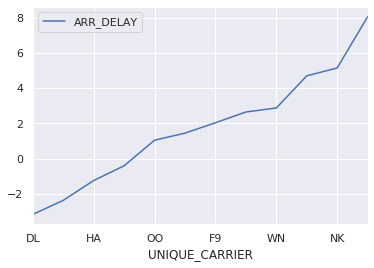

In [32]:
df_train[['ARR_DELAY', 'UNIQUE_CARRIER']].groupby('UNIQUE_CARRIER').mean().sort_values(by='ARR_DELAY', ascending=True).plot()

# Features encoding

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn import decomposition
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import statistics

from scipy import sparse

'''
Cette fonction fait un 1 hot encoding des features qui sont des catégories
Old function not used anymore
'''
    
def add_categorical_features_1hot(df, categorical_features_totransform):
    #df.drop(labels=categorical_features_totransform, axis=1, inplace=True)
    
    
    #df_encoded = pd.get_dummies(df, columns=categorical_features_totransform, sparse=True)
    
    for feature_totransform in categorical_features_totransform:
        print(f'Adding 1hot Feature : {feature_totransform}')
        
        print('First')
        df_transformed = df[feature_totransform].str.get_dummies().add_prefix(feature_totransform +'_')   
        
        #df_new = pd.get_dummies(df, columns=['ORIGIN'])
        
        
        
        
        #df.drop(labels=feature_totransform, axis=1, inplace=True)
        print('Second')
        del df[feature_totransform]
        
        print('Third')
        df = pd.concat([df, df_transformed], axis=1)
        
    return(df)


class HHMM_to_Minutes(BaseEstimator, TransformerMixin):
    def __init__(self, features_toconvert = ['CRS_DEP_TIME', 'CRS_ARR_TIME']):
        self.features_toconvert = features_toconvert
        return None
    
    def fit(self, df):      
        return self
    
    def transform(self, df):       
        for feature_toconvert in self.features_toconvert:
            print(f'Converting feature {feature_toconvert}\n')
            #print('1\n')
            df_concat = pd.concat([df[feature_toconvert].str.slice(start=0,stop=2, step=1),df[feature_toconvert].str.slice(start=2,stop=4, step=1)], axis=1).astype(int).copy(deep=True)
                    
            #print('2\n')
            df[feature_toconvert] = (df_concat.iloc[:, [0]] * 60 + df_concat.iloc[:, [1]])[feature_toconvert]
            del df_concat
            
            #print('3\n')
        
        return(df)

    
class HHMM_to_HH(BaseEstimator, TransformerMixin):
    def __init__(self, features_toconvert = ['CRS_DEP_TIME', 'CRS_ARR_TIME']):
        self.features_toconvert = features_toconvert
        return None
    
    def fit(self, df):      
        return self
    
    def transform(self, df):       
        for feature_toconvert in self.features_toconvert:
            print(f'Converting feature {feature_toconvert}\n')
            #print('1\n')

            df.loc[:, feature_toconvert] = df[feature_toconvert].str.slice(start=0,stop=2, step=1)
        
        return(df)
    
'''
class CategoricalFeatures1HotEncoder_old(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features_totransform=['ORIGIN', 'UNIQUE_CARRIER', 'DEST']):
        self.categorical_features_totransform = categorical_features_totransform
    
    def fit(self, df, labels=None):      
        return self
    
    def transform(self, df):
        # /!\ Array will not have the same shape if we fit an ensemble of samples that have less values than total dataset
        df_encoded = pd.get_dummies(df, columns=self.categorical_features_totransform, sparse=True)  # Sparse allows to gain memory. But then, standardscale must be with_mean=False
        #df_encoded = pd.get_dummies(df, columns=self.categorical_features_totransform, sparse=False)
        print('type of df : ' + str(type(df_encoded)))
        return(df_encoded)
'''

class CategoricalFeatures1HotEncoder(BaseEstimator, TransformerMixin):
    #def __init__(self, categorical_features_totransform=['ORIGIN', 'UNIQUE_CARRIER', 'DEST']):
    def __init__(self):
        #self.categorical_features_totransform = categorical_features_totransform
        self.fitted = False
        self.all_feature_values = {}
        #self.df_encoded = None
    
    #def fit(self, df, labels=None):      
    def fit(self, df, categorical_features_totransform=['ORIGIN', 'UNIQUE_CARRIER', 'DEST']):      
        print('Fit data')
        self.categorical_features_totransform = categorical_features_totransform
        print('!! categorical_features_totransform' + str(self.categorical_features_totransform))

        if (self.categorical_features_totransform != None):
            for feature_name in self.categorical_features_totransform:
                df[feature_name] = df[feature_name].astype(str) # Convert features to str in case they are not already     
                self.all_feature_values[feature_name] = feature_name + '_' + df[feature_name].unique()
        
        self.fitted = True
        
        return self
    
    def transform(self, df):
        if (self.fitted == False):
            self.fit(df)
        
        if (self.categorical_features_totransform != None):
            print('Transform data')
            
            print('1hot encode categorical features...')
            #df_encoded = pd.get_dummies(df, columns=self.categorical_features_totransform, sparse=True)  # Sparse allows to gain memory. But then, standardscale must be with_mean=False
            df_encoded = pd.get_dummies(df, columns=self.categorical_features_totransform, sparse=False)

            # Get category values that were in fitted data, but that are not in data to transform 
            for feature_name, feature_values in self.all_feature_values.items():
                diff_columns = list(set(feature_values) - set(df_encoded.columns.tolist()))
                print(f'Column values that were in fitted data but not in current data: {diff_columns}')

                if (len(diff_columns) > 0):
                    print('Adding those column with 0 values to the DataFrme...')
                    # Create columns with 0 for the above categories, in order to preserve same matrix shape between train et test set
                    zeros_dict = dict.fromkeys(diff_columns, 0)
                    df_encoded = df_encoded.assign(**zeros_dict)

            print('type of df : ' + str(type(df_encoded)))
            return(df_encoded)

        else:
            return(df)

class Aggregate_then_GroupByMean_then_Sort_numericalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features_totransform=['ORIGIN', 'UNIQUE_CARRIER', 'DEST']):
        self.categorical_features_totransform = categorical_features_totransform
        self.fitted = False
        self.all_feature_values = {}
    
    def fit(self, df, labels=None):      
        print('Fit data')
        
        self.feature_maps = {}
        
        for feature_name in self.categorical_features_totransform:
            print(f'Fitting feature {feature_name}')
            # List all feature values ordered by mean delay
            list_feature_mean_ordered = df[['ARR_DELAY', feature_name]].groupby(feature_name).mean().sort_values(by='ARR_DELAY', ascending=True).index.tolist()
            
            # Generate a dictionary of feature values as keys and index as values
            self.feature_maps[feature_name] = {}
            self.feature_maps[feature_name]['list_feature_mean_ordered_dict'] = {list_feature_mean_ordered[i] : i for i in range(len(list_feature_mean_ordered))  }
            
            #print('Dictionnary : ' + str(self.feature_maps[feature_name]['list_feature_mean_ordered_dict']))
            
            # BUG : we had to do that line of code in transform instead, not in fit (result is the same, no difference)
            #self.feature_maps[feature_name]['list_feature_mean_ordered_mapper'] = lambda k : self.feature_maps[feature_name]['list_feature_mean_ordered_dict'][k]
                  
        self.fitted = True
        
        return self
    
    def transform(self, df):
        if (self.fitted == False):
            print('Launching fit first (if you see this message : ensure that you have passed training set as input, not test set)')
            self.fit(df)
        
        print('Encode categorical features...')
        
        for feature_name in self.categorical_features_totransform:
            print(f'Encoding feature {feature_name} ...')
            #print('Dictionnary : ' + str(self.feature_maps[feature_name]['list_feature_mean_ordered_dict']))
            
            # Replace each feature value by its index (the lowest the index, the lowest the mean delay is for this feature)
            list_feature_mean_ordered_mapper = lambda k : self.feature_maps[feature_name]['list_feature_mean_ordered_dict'][k]
                            
            #df[feature_name] = df.loc[:, feature_name].apply(self.feature_maps[feature_name]['list_feature_mean_ordered_mapper'])  # BUG (we had to use line below instead)
            df[feature_name] = df.loc[:, feature_name].apply(list_feature_mean_ordered_mapper)

        return(df)
    
    
class FeaturesSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features_toselect = None):  # If None : every column is kept, nothing is done
        self.features_toselect = features_toselect
    
    def fit(self, df, labels=None):      
        return self
    
    def transform(self, df):       
        if (self.features_toselect != None):
            filter_cols = [col for col in df if (col.startswith(tuple(self.features_toselect)))]
            
            filter_cols.sort()
            
            print("Features selected (in order): " + str(df[filter_cols].columns))
            
            df = df.loc[:, filter_cols]
            return(df)

        else:
            return(df)

'''
In order have less features globally: we Keep only features_tofilter that represent percent_tokeep% of total values
Features which values represent less than percent_tokeep% will be set "OTHERS" value instead of their real value
'''

class Filter_High_Percentile(BaseEstimator, TransformerMixin):
    def __init__(self, features_tofilter = ['ORIGIN', 'DEST'], percent_tokeep = 80):
        self.features_tofilter = features_tofilter
        self.percent_tokeep = percent_tokeep
        self.high_percentile = None
        self.low_percentile = None
    
    def fit(self, df, labels=None): 
        print('Fit high percentile filter...')
        for feature_tofilter in self.features_tofilter:
            # Get feature_tofilter values that represent 80% of data
            self.high_percentile = ((((df[[feature_tofilter]].groupby(feature_tofilter).size() / len(df)).sort_values(ascending=False)) * 100).cumsum() < self.percent_tokeep).where(lambda x : x == True).dropna().index.values.tolist()
            self.low_percentile = ((((df[[feature_tofilter]].groupby(feature_tofilter).size() / len(df)).sort_values(ascending=False)) * 100).cumsum() >= self.percent_tokeep).where(lambda x : x == True).dropna().index.values.tolist()

            total = len(df[feature_tofilter].unique())
            high_percentile_sum = len(self.high_percentile)
            low_percentile_sum = len(self.low_percentile)
            high_low_sum = high_percentile_sum + low_percentile_sum

            print(f'Total number of {feature_tofilter} values : {total}')
            print(f'Number of {feature_tofilter} high percentile (> {self.percent_tokeep}%) values : {high_percentile_sum}')
            print(f'Number of {feature_tofilter} low percentile values : {low_percentile_sum}')
            print(f'Sum of high percentile + low percentile values : {high_low_sum}')
        
        print('End of high percentile filter fit')
        return self
    
    def transform(self, df):       
        if (self.features_tofilter != None):
            print('Apply high percentile filter...')
            
            for feature_tofilter in self.features_tofilter:
                print(f'Apply filter on feature {feature_tofilter}')
                # To do for later : apply low_percentile specific to the feature, and not only last calculated low_percentile  (in our case it's the same percentile for ORIGIN and DEST so this is not a problem)
                df.loc[df[feature_tofilter].isin(self.low_percentile), feature_tofilter] = 'OTHERS'   
            
            return(df)    

        else:
            return(df)
        

    
class DenseToSparseConverter(BaseEstimator, TransformerMixin):
    def __init__(self):  # If None : every column is kept, nothing is done
        return None
    
    def fit(self, matrix, labels=None):      
        return self
    
    def transform(self, matrix):   
        return(sparse.csr_matrix(matrix))

    
'''
This class adds polynomial features in univariate way  (if feature X and n_degree 3 :  then it will add X², X³, and an intercept at the end)

Requires ndarray as input
'''    
class PolynomialFeaturesUnivariateAdder(BaseEstimator, TransformerMixin):
    def __init__(self, n_degrees=2):
        self.n_degrees = n_degrees
        self.fitted = False
    
    def fit(self, df, labels=None):
        self.fitted = True
        return self
    
    def transform(self, df):
        if (self.fitted == False):
            self.fit(df)

        nb_instances, n_features = df.shape
        df_poly = np.empty((nb_instances, 0)) # Create empty array of nb_instances line and 0 features yet (we'll concatenate polynomial features to it)

        progbar = tqdm(range(n_features))
        print('Adding polynomial features')

        for feature_index in range(n_features):    
            df_1feature = df[:,feature_index]  # Reshape 

            for n_degree in range(self.n_degrees):
                df_poly = np.c_[df_poly, np.power(df_1feature, n_degree + 1)]

            progbar.update(1)

        # Add bias (intercept)
        df_poly = np.c_[df_poly, np.ones((len(df_poly), 1))]  # add x0 = 1 feature        
        
        return(df_poly)

'''
This class adds polynomial features in univariate way  (if feature X and n_degree 3 :  then it will add X², X³, and an intercept at the end)

Requires DataFrame as input
'''        
    
class PolynomialFeaturesUnivariateAdder_DataFrame(BaseEstimator, TransformerMixin):
    def __init__(self, n_degrees=2):
        self.n_degrees = n_degrees
        self.fitted = False
    
    def fit(self, df, features_toadd=None):  
        print('fit')
        self.features_toadd = features_toadd
        print('Features to add :')
        print(self.features_toadd)
        self.fitted = True
        return self
    
    def transform(self, df):
        print('transform')
        if (self.fitted == False):
            self.fit(df)

        nb_instances, n_features = df.shape
        #df_poly = np.empty((nb_instances, 0)) # Create empty array of nb_instances line and 0 features yet (we'll concatenate polynomial features to it)
        #df_poly = pd.DataFrame(index=df.index,columns=None)
        
        progbar = tqdm(range(len(self.features_toadd)))
        print('Adding polynomial features')

        for column_name in self.features_toadd:    
            #df_1feature = df.loc[:, column_name]

            for n_degree in range(1, self.n_degrees):
                #df = pd.concat([df, np.power(df.loc[:, column_name], n_degree + 1)], axis=1)
                df = pd.concat([df, np.power(df[[column_name]], n_degree + 1).rename(columns={column_name : column_name+'_DEG'+str(n_degree+1)})], axis=1)

            progbar.update(1)

        # Add bias (intercept)
        #df_poly = pd.concat([df_poly, np.ones((len(df_poly), 1))])  # add x0 = 1 feature        
        #del df
        return(df)    
    
    
class StandardScalerMultiple_old(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.fitted = False
    
    def fit(self, df, columns=None):              
        self.columns = columns
        self.scaler = StandardScaler()
  
        if (self.columns == None):
            return(df)
        else:
            self.scaler.fit(df[self.columns].to_numpy())            
        
        return self
    
    def transform(self, df):
        if (self.fitted == False):
            self.fit(df)
        
        if (self.columns == None):
            return(df)
        
        else:
            df[self.columns] = self.scaler.transform(df[self.columns].to_numpy())

        return(df)
        
class StandardScalerMultiple(BaseEstimator, TransformerMixin):
    def __init__(self, features_toscale=None):
        self.fitted = False
        self.columns = features_toscale
    
    def fit(self, df):              
        print('Fit Std scale multiple')
        self.scaler = StandardScaler()
  
        if (self.columns == None):
            self.fitted = True
            return(df)
        else:
            self.scaler.fit(df[self.columns].to_numpy())            
            self.fitted = True
        
        return self
    
    def transform(self, df):
        print('Transform Std scale multiple')
        if (self.fitted == False):
            self.fit(df)
        
        if (self.columns == None):
            return(df)
        
        else:
            df.loc[:, self.columns] = self.scaler.transform(df.loc[:, self.columns].to_numpy())

        return(df)
        

class MinMaxScalerMultiple(BaseEstimator, TransformerMixin):
    def __init__(self, features_toscale=None):
        self.fitted = False
        self.columns = features_toscale
    
    def fit(self, df):              
        print('Fit Min max scaler multiple')
        self.scaler = MinMaxScaler()
  
        if (self.columns == None):
            self.fitted = True
            return(df)
        else:
            self.scaler.fit(df[self.columns].to_numpy())            
            self.fitted = True
        
        return self
    
    def transform(self, df):
        print('Transform Min max scaler multiple')
        if (self.fitted == False):
            self.fit(df)
        
        if (self.columns == None):
            return(df)
        
        else:
            df.loc[:, self.columns] = self.scaler.transform(df.loc[:, self.columns].to_numpy())

        return(df)        
        
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, features_totransform = None):  # If None : every column is kept, nothing is done
        self.features_toselect = features_toselect
    
    def fit(self, df, labels=None):      
        return self
    
    def transform(self, df):       
        if (self.features_toselect != None):
            filter_cols = [col for col in df if (col.startswith(tuple(self.features_toselect)))]
            
            filter_cols.sort()
            
            print("Features selected (in order): " + str(df[filter_cols].columns))
            
            df = df.loc[:, filter_cols]
            return(df)

        else:
            return(df)
 
        
        
'''
conversion_pipeline = Pipeline([
    ('data_converter', HHMM_to_Minutes()),
    #('categoricalfeatures_1hotencoder', CategoricalFeatures1HotEncoder()),
    #('standardscaler', preprocessing.StandardScaler()),
])
'''

preparation_pipeline = Pipeline([
    ('filter_highpercentile', Filter_High_Percentile()),
    ('data_converter', HHMM_to_Minutes()),
    ('categoricalfeatures_1hotencoder', CategoricalFeatures1HotEncoder()),
    #('standardscaler', preprocessing.StandardScaler()),
])


'''
preparation_pipeline_meansort = Pipeline([
    #('filter_highpercentile', Filter_High_Percentile()),
    ('data_converter', HHMM_to_Minutes()),
    ('numericalEncoder', Aggregate_then_GroupByMean_then_Sort_numericalEncoder()),
    #('standardscaler', preprocessing.StandardScaler()),
])
'''

preparation_pipeline_meansort = Pipeline([
    #('filter_highpercentile', Filter_High_Percentile()),
    ('data_converter', HHMM_to_Minutes()),
    ('numericalEncoder', Aggregate_then_GroupByMean_then_Sort_numericalEncoder()),
    ('categoricalfeatures_1hotencoder', CategoricalFeatures1HotEncoder()),
    #('standardscaler', preprocessing.StandardScaler()),
])


# If matrix is sparse, with_mean=False must be passed to StandardScaler
prediction_pipeline = Pipeline([
    ('features_selector', FeaturesSelector(features_toselect=MODEL1_FEATURES)),
    ('standardscaler', ColumnTransformer([
        ('standardscaler_specific', StandardScaler(), MODEL1_FEATURES_QUANTITATIVE)
    ], remainder='passthrough', sparse_threshold=1)),
    
    ('dense_to_sparse_converter', DenseToSparseConverter()),
    #('predictor', To_Complete(predictor_params =  {'n_neighbors':6, 'algorithm':'ball_tree', 'metric':'minkowski'})),
])
#copy=False passed to StandardScaler() allows to gain memory


prediction_pipeline_without_sparse = Pipeline([
    ('features_selector', FeaturesSelector(features_toselect=MODEL1_FEATURES)),
    ('standardscaler', ColumnTransformer([
        ('standardscaler_specific', StandardScaler(), MODEL1_FEATURES_QUANTITATIVE)
    #], remainder='passthrough', sparse_threshold=1)), # For sparse output. Seems not to work well.
    ], remainder='passthrough')),
    
    #('dense_to_sparse_converter', DenseToSparseConverter()),
    #('predictor', To_Complete(predictor_params =  {'n_neighbors':6, 'algorithm':'ball_tree', 'metric':'minkowski'})),
])

prediction_pipeline_groupbymean = Pipeline([
    ('features_selector', FeaturesSelector(features_toselect=MODEL1_GOUPBYMEAN_FEATURES)),
    ('standardscaler', ColumnTransformer([
        ('standardscaler_specific', StandardScaler(), MODEL_GROUPBYMEAN_FEATURES_QUANTITATIVE)
    ], remainder='passthrough')),
    #], remainder='passthrough', sparse_threshold=1)), # For sparse output. Seems not to work well.
    
    #('dense_to_sparse_converter', DenseToSparseConverter()),
    #('predictor', To_Complete(predictor_params =  {'n_neighbors':6, 'algorithm':'ball_tree', 'metric':'minkowski'})),
])



prediction_pipeline_1hotall_without_sparse = Pipeline([
    ('features_selector', FeaturesSelector(features_toselect=MODEL1_FEATURES)),
    ('standardscaler', ColumnTransformer([
        ('standardscaler_specific', StandardScaler(), MODEL1bis_FEATURES_QUANTITATIVE)
    ], remainder='passthrough', sparse_threshold=1)),
    
    #('dense_to_sparse_converter', DenseToSparseConverter()),
    #('predictor', To_Complete(predictor_params =  {'n_neighbors':6, 'algorithm':'ball_tree', 'metric':'minkowski'})),
])

prediction_pipeline_cheat_without_sparse = Pipeline([
    ('features_selector', FeaturesSelector(features_toselect=MODEL_cheat_FEATURES)),
    ('standardscaler', ColumnTransformer([
        ('standardscaler_specific', StandardScaler(), MODEL_cheat_FEATURES_QUANTITATIVE)
    ], remainder='passthrough', sparse_threshold=1)),
    
    #('dense_to_sparse_converter', DenseToSparseConverter()),
    #('predictor', To_Complete(predictor_params =  {'n_neighbors':6, 'algorithm':'ball_tree', 'metric':'minkowski'})),
])



preparation_pipeline_meansort_stdscale = Pipeline([
    ('data_converter', HHMM_to_Minutes()),
    ('numericalEncoder', Aggregate_then_GroupByMean_then_Sort_numericalEncoder()),
    #('categoricalfeatures_1hotencoder', CategoricalFeatures1HotEncoder()),
    ('features_selector', FeaturesSelector(features_toselect=MODEL1_GOUPBYMEAN_FEATURES)),
    ('standardscaler', StandardScalerMultiple(features_toscale=MODEL1_GOUPBYMEAN_FEATURES)),
])


# Temporary modification :  HHMM_To_Minutes instead of HHMM_to_HH and CRS_DEP_TIME in quantitative MODEL_1HOTALL_FEATURES_QUANTITATIVE

# To defined features to 1hot encode, pass fit_transform parameter below:  
# categoricalfeatures_1hotencoder__categorical_features_totransform=['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'ORIGIN', 'UNIQUE_CARRIER', 'CRS_DEP_TIME']
preparation_pipeline_1hotall_minmax = Pipeline([
    ('filter_highpercentile', Filter_High_Percentile()),
    ('hour_extractor', HHMM_to_HH()),
    #('data_converter', HHMM_to_Minutes()),
    ('categoricalfeatures_1hotencoder', CategoricalFeatures1HotEncoder()), 
    
    ('features_selector', FeaturesSelector(features_toselect=MODEL_1HOTALL_FEATURES)),
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=MODEL_1HOTALL_FEATURES_QUANTITATIVE)),
])


preparation_pipeline_meansort2_stdscale = Pipeline([
    ('filter_highpercentile', Filter_High_Percentile()),
    ('hour_extractor', HHMM_to_HH()),
    ('numericalEncoder', Aggregate_then_GroupByMean_then_Sort_numericalEncoder()),
    #('data_converter', HHMM_to_Minutes()),
    #('categoricalfeatures_1hotencoder', CategoricalFeatures1HotEncoder()), 
    
    ('features_selector', FeaturesSelector(features_toselect=MODEL_GROUPBYMEAN2_FEATURES)),
    ('standardscaler', StandardScalerMultiple(features_toscale=MODEL_GROUPBYMEAN2_FEATURES)),
])


preparation_pipeline_2feats_stdscale = Pipeline([
    #('filter_highpercentile', Filter_High_Percentile()),
    #('hour_extractor', HHMM_to_HH()),
    #('categoricalfeatures_1hotencoder', CategoricalFeatures1HotEncoder()), 
    
    ('features_selector', FeaturesSelector(features_toselect=MODEL1_2FEATS)),
    #('standardscaler', StandardScalerMultiple(features_toscale=MODEL1_2FEATS_QUANTITATIVE)),
])

preparation_pipeline_3feats_stdscale = Pipeline([
    #('filter_highpercentile', Filter_High_Percentile()),
    #('hour_extractor', HHMM_to_HH()),
    #('categoricalfeatures_1hotencoder', CategoricalFeatures1HotEncoder()), 
    
    ('features_selector', FeaturesSelector(features_toselect=MODEL1_3FEATS)),
    #('standardscaler', StandardScalerMultiple(features_toscale=MODEL1_2FEATS_QUANTITATIVE)),
])



'''
# Old code that used scikit learn OneHotEncoder (which does not keep DataFrame type) instead of Pandas
preparation_pipeline2 = Pipeline([
    ('data_converter', HHMM_to_Minutes()),
    ('multiple_encoder', ColumnTransformer([
        ('categoricalfeatures_1hotencoder', OneHotEncoder(), ['ORIGIN', 'UNIQUE_CARRIER', 'DEST'])
    ], remainder='passthrough')),
    #('standardscaler', preprocessing.StandardScaler()),
])
'''

'''
ColumnTransformer([
        ('standardscaler_specific', StandardScaler(), ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT'])
    ], remainder='passthrough')
'''

"\nColumnTransformer([\n        ('standardscaler_specific', StandardScaler(), ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT'])\n    ], remainder='passthrough')\n"

In [34]:
df

ORIGIN CRS_DEP_TIME  MONTH  DAY_OF_MONTH  DAY_OF_WEEK UNIQUE_CARRIER  \
1501291    CLE         1332      5            15            7             EV   
3922762    SFO         1340      1            13            3             VX   
214125     DSM         1455      9             8            4             UA   
1361083    CLT         2230      6            18            6             AA   
2880946    DEN         1726      2            20            6             OO   
...        ...          ...    ...           ...          ...            ...   
1973186    LBB         1340     12             6            2             EV   
5138950    SAN         1000      8             8            1             AS   
2595055    BOS         1105      3             7            1             NK   
2389103    MEM         1157      3            18            5             DL   
5214118    ORF         1237      8            16            2             DL   

        DEST CRS_ARR_TIME  DISTANCE  CRS_ELAPSED_TIME  ARR_DELAY  DEP_DELAY  \
1501291  LGA         1513     419.0             101.0      117.0      113.0   
3922762  JFK         2210    2586.0             330.0       52.0       37.0   
214125   ORD         1625     299.0              90.0      -30.0      -12.0   
1361083  ORF         2339     290.0              69.0       -6.0        0.0   
2880946  BIS         2010     516.0             104.0      -16.0       -3.0   
...      ...          ...       ...               ...        ...        ...   
1973186  IAH         1515     458.0              95.0      -13.0       -8.0   
5138950  PDX         1218     933.0             138.0        1.0       -5.0   
2595055  RSW         1438    1249.0             213.0      -25.0      -11.0   
2389103  ATL         1425     332.0              88.0      -23.0       -5.0   
5214118  ATL         1430     516.0             113.0       11.0       -4.0   

         TAXI_OUT TAIL_NUM  NBFLIGHTS_FORDAY_FORAIRPORT  \
1501291      15.0   N12996                           92   
3922762      32.0   N854VA                          427   
214125        9.0   N478UA                           22   
1361083      13.0   N725UW                          258   
2880946      13.0   N984CA                          460   
...           ...      ...                          ...   
1973186      11.0   N14907                           12   
5138950      13.0   N760AS                          238   
2595055      19.0   N635NK                          467   
2389103      13.0   N994AT                           50   
5214118      36.0   N927DA                           34   

         NBFLIGHTS_FORDAYHOUR_FORAIRPORT  
1501291                                3  
3922762                               22  
214125                                 2  
1361083                               29  
2880946                               31  
...                                  ...  
1973186                                2  
5138950                               19  
2595055                               26  
2389103                                4  
5214118                                3  

[80000 rows x 16 columns]

In [35]:
df_train_transformed = preparation_pipeline.fit_transform(df_train)

Fit high percentile filter...
Total number of ORIGIN values : 307
Number of ORIGIN high percentile (> 80%) values : 45
Number of ORIGIN low percentile values : 262
Sum of high percentile + low percentile values : 307
Total number of DEST values : 306
Number of DEST high percentile (> 80%) values : 45
Number of DEST low percentile values : 261
Sum of high percentile + low percentile values : 306
End of high percentile filter fit
Apply high percentile filter...
Apply filter on feature ORIGIN
Apply filter on feature DEST
Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Fit data
!! categorical_features_totransform['ORIGIN', 'UNIQUE_CARRIER', 'DEST']
Transform data
1hot encode categorical features...
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
type of df : <class 'pandas.core.frame.DataFrame'>


In [36]:
df_train_transformed

CRS_DEP_TIME  MONTH  DAY_OF_MONTH  DAY_OF_WEEK  CRS_ARR_TIME  \
2390410           550      3            20            7           662   
1676587           783      5             1            7           984   
4883040          1060     11            22            2          1225   
1553841          1090      5             1            7          1175   
1102373           795      6             9            4           875   
...               ...    ...           ...          ...           ...   
356900            821      9            12            1           835   
5056543           591     11             3            4           693   
4382560          1020     10            23            7          1168   
3513765           385      4            24            7           483   
4702457           725     11             5            6           791   

         DISTANCE  CRS_ELAPSED_TIME  ARR_DELAY  DEP_DELAY  TAXI_OUT  ...  \
2390410     991.0             172.0      -21.0       -6.0      20.0  ...   
1676587     854.0             141.0      -16.0       -4.0      14.0  ...   
4883040     802.0             165.0       -4.0       -6.0      27.0  ...   
1553841     480.0              85.0       -5.0        5.0       7.0  ...   
1102373     337.0              80.0        0.0       17.0       7.0  ...   
...           ...               ...        ...        ...       ...  ...   
356900      271.0              74.0      -15.0       -2.0      10.0  ...   
5056543     515.0             102.0       -6.0       -1.0      24.0  ...   
4382560    2342.0             328.0      110.0      102.0      19.0  ...   
3513765     429.0              98.0       -1.0       -3.0      20.0  ...   
4702457     227.0              66.0      -13.0       -3.0      12.0  ...   

        DEST_SAN  DEST_SAT  DEST_SEA  DEST_SFO  DEST_SJC  DEST_SLC  DEST_SMF  \
2390410        0         0         0         0         0         1         0   
1676587        0         0         0         0         0         0         0   
4883040        0         0         0         0         0         0         0   
1553841        1         0         0         0         0         0         0   
1102373        0         0         0         0         0         0         0   
...          ...       ...       ...       ...       ...       ...       ...   
356900         0         0         0         0         0         0         0   
5056543        0         0         0         0         0         0         0   
4382560        0         0         0         0         0         0         0   
3513765        0         0         0         0         0         0         0   
4702457        0         0         0         0         0         0         0   

         DEST_SNA  DEST_STL  DEST_TPA  
2390410         0         0         0  
1676587         0         0         0  
4883040         0         0         0  
1553841         0         0         0  
1102373         0         0         0  
...           ...       ...       ...  
356900          0         0         0  
5056543         0         0         0  
4382560         0         0         0  
3513765         0         0         0  
4702457         0         0         0  

[72000 rows x 119 columns]

In [37]:
df_train_transformed.shape

(72000, 119)

In [38]:
df_train_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72000 entries, 2390410 to 4702457
Columns: 119 entries, CRS_DEP_TIME to DEST_TPA
dtypes: float64(5), int64(7), object(1), uint8(106)
memory usage: 15.0+ MB


In [39]:
#df_train_transformed = prediction_pipeline.fit_transform(df_train_transformed)  # Used if standard scale not commented out
df_train_transformed = prediction_pipeline_without_sparse.fit_transform(df_train_transformed)

Features selected (in order): Index(['CRS_ARR_TIME', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DAY_OF_MONTH',
       'DAY_OF_WEEK', 'DEST_ATL', 'DEST_AUS', 'DEST_BNA', 'DEST_BOS',
       'DEST_BWI',
       ...
       'UNIQUE_CARRIER_B6', 'UNIQUE_CARRIER_DL', 'UNIQUE_CARRIER_EV',
       'UNIQUE_CARRIER_F9', 'UNIQUE_CARRIER_HA', 'UNIQUE_CARRIER_NK',
       'UNIQUE_CARRIER_OO', 'UNIQUE_CARRIER_UA', 'UNIQUE_CARRIER_VX',
       'UNIQUE_CARRIER_WN'],
      dtype='object', length=115)


In [40]:
df_train_transformed.shape

(72000, 115)

In [41]:
from scipy import sparse
sparse.issparse(df_train_transformed)

False

In [42]:
#pd.DataFrame.sparse.from_spmatrix(df_train_transformed)

In [43]:
pd.set_option('display.max_columns', 400)

In [44]:
all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)

Quantitative features : ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT'] 

Qualitative features : ['ORIGIN', 'CRS_DEP_TIME', 'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'TAIL_NUM'] 



# Test set encoding

In [45]:
df_test_transformed = preparation_pipeline.transform(df_test)
#df_test_transformed = prediction_pipeline.transform(df_test_transformed)  # Used if standardscale not commented out
df_test_transformed = prediction_pipeline_without_sparse.transform(df_test_transformed)
DATA_LOADED = True
df_test_transformed.shape

Apply high percentile filter...
Apply filter on feature ORIGIN
Apply filter on feature DEST
Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Transform data
1hot encode categorical features...
Column values that were in fitted data but not in current data: ['ORIGIN_ADK', 'ORIGIN_PGD']
Adding those column with 0 values to the DataFrme...
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
type of df : <class 'pandas.core.frame.DataFrame'>
Features selected (in order): Index(['CRS_ARR_TIME', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DAY_OF_MONTH',
       'DAY_OF_WEEK', 'DEST_ATL', 'DEST_AUS', 'DEST_BNA', 'DEST_BOS',
       'DEST_BWI',
       ...
       'UNIQUE_CARRIER_B6', 'UNIQUE_CARRIER_DL', 'UNIQUE_CARRIER_EV',
       'UNIQUE_CARRIER_F9', 'UNIQUE_CARRIER_HA', 'UNIQUE_CARRIER_NK',
       'UNIQUE_CARRIER_OO', 'UNIQUE_CARRIER_UA', 'UNIQUE_CARRIER_VX',
       'UNIQUE_CARRIER_WN'],
      dtype='obj

(8000, 115)

In [46]:
df_train_transformed

array([[-0.88266927, -1.03156152,  0.47860887, ...,  0.        ,
         0.        ,  0.        ],
       [-0.0913238 , -0.44394691, -1.67837361, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.84946031,  1.3188969 ,  0.70565966, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.71360701,  1.0250896 ,  0.81918505, ...,  0.        ,
         0.        ,  0.        ],
       [-1.44306413, -0.73775422,  0.93271045, ...,  0.        ,
         0.        ,  0.        ],
       [-0.28831108,  1.3188969 , -1.22427204, ...,  0.        ,
         0.        ,  0.        ]])

In [47]:
df_test[model1_label]

4681469     6.0
1034394   -15.0
3011767   -15.0
2494819     9.0
2716269    36.0
           ... 
4363312     9.0
2360622    -9.0
32676     -13.0
4927976    -9.0
5469090     0.0
Name: ARR_DELAY, Length: 8000, dtype: float64

In [48]:
df_test.index

Int64Index([4681469, 1034394, 3011767, 2494819, 2716269, 4746049, 4981617,
            3271963, 2814004,  856276,
            ...
            2443216, 1330880, 1464842, 2018084, 4571033, 4363312, 2360622,
              32676, 4927976, 5469090],
           dtype='int64', length=8000)

In [49]:
df.loc[df_test.index, model1_label]

4681469     6.0
1034394   -15.0
3011767   -15.0
2494819     9.0
2716269    36.0
           ... 
4363312     9.0
2360622    -9.0
32676     -13.0
4927976    -9.0
5469090     0.0
Name: ARR_DELAY, Length: 8000, dtype: float64

# Linear regression

In [50]:
df_train[model1_label].shape

(72000,)

In [51]:
# Add bias :
df_train_transformed = np.c_[np.ones((len(df_train_transformed), 1)), df_train_transformed]  # add x0 = 1 to each instance
df_test_transformed = np.c_[np.ones((len(df_test_transformed), 1)), df_test_transformed]  # add x0 = 1 to each instance

In [52]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    lin_reg = LinearRegression(normalize=False, fit_intercept=True)
    #lin_reg = TransformedTargetRegressor(regressor=lin_reg, transformer=StandardScaler())  # To scale y variable
    lin_reg.fit(df_train_transformed, df_train[model1_label])

In [53]:
'''
lin_reg = linear_model.SGDRegressor(alpha=0,max_iter=200)
lin_reg.fit(df_train_transformed, df_train[model1_label])
'''

'\nlin_reg = linear_model.SGDRegressor(alpha=0,max_iter=200)\nlin_reg.fit(df_train_transformed, df_train[model1_label])\n'

In [54]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_test_predictions = lin_reg.predict(df_test_transformed)
    
    #lin_mse = mean_squared_error(df_test[model1_label], df_test_predictions)
    #lin_rmse = np.sqrt(lin_mse)
    #print(lin_rmse)
    
    print("Evaluation on test set :")
    evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])

    print('\n')

    print("Evaluation on training set :")
    evaluate_model(lin_reg, df_train_transformed, df_train[model1_label])

    error_mean = evaluate_model_percent_mean(lin_reg, df_test_transformed, df_test[model1_label], 0.8)
    
    print('\n')
    print(f'Mean prediction error {EVALUATION_PERCENT*100}% of the time : {error_mean : .2f}')

=> 42.17  (42.16679389006135)  
=> 26.998703285049196  with outliers removed  
=> 26.998703285632104 with TransformedTargetRegressor  
=> 26.99870280932372 without standardscale  
=> 27.00905767522797 with SGDRegressor ((alpha=0,max_iter=200) and standarscale


With 80000 lines :   
Evaluation on test set :   
RMSE : 27.03778899779597   


Evaluation on training set :   
RMSE : 26.990456780220008   
Mean prediction error 90.0% of the time :  10.01   

In [55]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_train_predictions = lin_reg.predict(df_train_transformed)
    df_test_predictions = lin_reg.predict(df_test_transformed)

In [56]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    plt.hist(df_test_predictions, bins=50)

In [57]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE)

In [58]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_train

In [59]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_train[[model1_label]]

In [60]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    lin_reg.coef_

array([  3.0601343 ,   0.54106613,   0.49255945,  -0.02052923,
         1.6354574 ,  10.62073489, -12.18551101,   0.27450354,
        -1.33980503,   0.10149764,   0.31685657,  -0.65541914,
        -1.53379643,  -0.56033462,   2.17482374,   0.23276129,
        -1.26869889,   3.05226253,   0.18607054,   5.51988916,
         1.42903568,  -4.32234874,   0.30318026,  -0.94593642,
        -1.40645942,   4.27814774,  -0.06934268,   2.69507292,
         4.87336364,  -1.91588117,   1.21284379,  -1.94274921,
         4.73238555,  -3.20774291,   0.47564597,  -1.6987073 ,
         0.14379464,   4.40476573,  -1.74618153,  -2.76805405,
         0.45234394,  -1.60170948,   1.1685909 ,  -2.46122663,
        -1.75186943,  -0.42718454,   3.2389558 ,  -0.80286191,
        -3.11232599,  -0.71881518,  -3.40806787,  -1.02946792,
        -0.57180507,   0.58845347,  -5.32955616,   4.14911968,
        -3.77501356,   1.94734073,   5.04213062,  -3.46294331,
         4.36932467,   1.10828485,  -3.07715486,  -2.1540515 ,
         0.59406537,  -0.21559221,  -1.4864192 ,  -1.92685958,
        -1.13360134,  -2.79307414,  -3.16535316,  -2.14418489,
        -0.3786179 ,  -1.35651547,  -0.65089003,   3.72717084,
        -0.5316482 ,   6.38411318,   0.56280763,   2.32285819,
        -0.71875407,  -3.7427498 ,  -0.72443612,   3.01913525,
         0.0259135 ,   6.05048444,   6.88297842,  -2.05348981,
         0.57619293,  -3.06150148,   2.91489312,  -3.69821352,
         1.39265583,  -2.73996445,   0.48819288,   3.78111808,
        -2.73090349,  -0.99799275,  -1.41459568,  -0.14998697,
        -1.16199228,  -1.2855059 ,  -2.33902093,   2.26562809,
         9.46369559,  -0.27437885,  -1.82963879,   0.47213692,
        -2.5256052 ,  -2.053249  ,  -1.04523965])

In [61]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison actual values / predict values')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_test[model1_label], df_test_predictions, color='coral', alpha=0.1)

In [62]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_train_transformed

In [63]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    plt.hist(df_test_predictions, bins=50)

In [64]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    plt.hist(df_test[model1_label], bins=50)

In [65]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_train_predictions = lin_reg.predict(df_train_transformed)

In [66]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    plt.hist(df_train_predictions, bins=50)

In [67]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    from sklearn.model_selection import cross_validate

    #scores = cross_validate(lin_reg, df_train_transformed, df_train[model1_label], scoring='neg_root_mean_squared_error', cv=5)

In [68]:
#scores['test_score'].mean()

# ElasticNET regression

In [69]:
from sklearn.model_selection import ShuffleSplit


shuffled_split_train = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)


In [70]:
from sklearn.linear_model import ElasticNet

In [71]:
from sklearn.model_selection import GridSearchCV

eNet = ElasticNet()

grid_search = GridSearchCV(eNet, param_grid = {"max_iter": [1, 5, 10],
                      "alpha": [10, 100],
                      "l1_ratio": np.arange(0.0, 1.0, 0.4)},cv=shuffled_split_train, scoring='neg_mean_squared_error', error_score=np.nan, verbose=2)

In [72]:
'''
from sklearn.model_selection import GridSearchCV

eNet = ElasticNet()

grid_search = GridSearchCV(eNet, param_grid = {"max_iter": [1, 5, 10],
                      "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                      "l1_ratio": np.arange(0.0, 1.0, 0.1)},cv=shuffled_split_train, scoring='neg_mean_squared_error', error_score=np.nan, verbose=2)
'''

'\nfrom sklearn.model_selection import GridSearchCV\n\neNet = ElasticNet()\n\ngrid_search = GridSearchCV(eNet, param_grid = {"max_iter": [1, 5, 10],\n                      "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],\n                      "l1_ratio": np.arange(0.0, 1.0, 0.1)},cv=shuffled_split_train, scoring=\'neg_mean_squared_error\', error_score=np.nan, verbose=2)\n'

In [73]:
if (RECOMPUTE_GRIDSEARCH == True):
    grid_search.fit(df_train_transformed, df_train[model1_label])

In [74]:
if ((SAVE_GRID_RESULTS == False) and (LOAD_GRID_RESULTS == True)):
    grid_search = None
    
grid_search, df_grid_search_results = save_or_load_search_params(grid_search, 'eNet_20200319')

In [75]:
if ((EXECUTE_INTERMEDIATE_MODELS == True) and (LOAD_GRID_RESULTS == True)):
    df_grid_search_results.sort_values(by='mean_test_score', ascending=False)

In [76]:
np.sqrt(1741.47)

41.73092378560532

=> 41.73092378560532

In [77]:
if ((EXECUTE_INTERMEDIATE_MODELS == True) and (LOAD_GRID_RESULTS == True)):
    grid_search.best_estimator_

In [78]:
if ((EXECUTE_INTERMEDIATE_MODELS == True) and (LOAD_GRID_RESULTS == True)):
    df_test_predictions = grid_search.best_estimator_.predict(df_test_transformed)
    mse = mean_squared_error(df_test[model1_label], df_test_predictions)
    rmse = np.sqrt(mse)
    print(rmse)


In [79]:
if ((EXECUTE_INTERMEDIATE_MODELS == True) and (LOAD_GRID_RESULTS == True)):
    grid_search.best_estimator_.coef_

array([ 3.81842241e-01,  5.38463257e-02,  4.20287224e-02,  5.22019019e-04,
        3.01660130e-01, -5.81861174e-02, -6.72278997e-02, -1.27034969e-02,
       -2.24325259e-04,  4.09514301e-04, -3.70631003e-03, -2.53436510e-03,
       -7.75208542e-04,  9.33417957e-05,  4.17993863e-03, -9.42512871e-04,
       -1.11806550e-03,  1.44798574e-02, -3.13856400e-03,  3.29966151e-03,
        3.99529584e-03, -4.48915797e-03,  1.95911581e-03, -2.36326646e-03,
       -4.08853652e-03,  1.66741438e-03,  5.08260117e-03,  1.27353349e-02,
        9.28815390e-04, -1.23422335e-03,  3.00267997e-03, -1.85353662e-03,
        6.23418838e-03, -1.61411894e-03, -2.91269348e-03, -6.75664468e-04,
        1.69775346e-03,  1.63447325e-02, -2.33087459e-02, -2.59028581e-03,
       -1.74542702e-03, -1.45041347e-04,  6.16849621e-05, -9.03449295e-04,
       -5.89810820e-04, -5.62947068e-03,  9.74750809e-03,  2.35807415e-04,
       -6.16562051e-03,  9.79361758e-04, -9.11503285e-04,  2.40351790e-04,
       -8.00703606e-04,  2.80040048e-02, -1.62362534e-02,  2.32015532e-02,
       -7.01852245e-02,  1.65919140e-02,  7.25363024e-03, -4.83051956e-03,
        1.41858822e-02,  6.85437437e-03, -1.58676117e-02,  4.82723839e-03,
        6.33969777e-03, -2.46758789e-02,  2.42193209e-04, -1.45870754e-04,
        4.15867207e-03, -2.83023087e-03,  7.62388260e-05, -4.24610507e-03,
        5.26083293e-04,  1.47810804e-03, -9.19516190e-03,  8.25254437e-03,
       -5.18481866e-03,  1.03654765e-02,  2.87040417e-03, -1.10418835e-03,
        9.52434223e-05, -2.21408556e-03, -6.79991381e-03,  6.17574698e-03,
       -8.83819104e-04,  1.25073748e-02,  1.17980381e-02, -6.81557286e-04,
        3.04168241e-03, -4.21957706e-03,  3.05120532e-03, -7.89844324e-04,
       -2.93426593e-03, -8.38652464e-04,  1.05935638e-03,  6.74906118e-03,
       -5.14042339e-03, -2.37742304e-03, -4.46900931e-04, -2.72629361e-03,
        9.62469273e-04, -1.57391539e-03, -1.61121536e-05, -5.49546918e-03,
        1.91647269e-02, -4.83097086e-05, -6.78384591e-03,  1.00960720e-03,
       -2.12687675e-03, -2.30717357e-04,  1.28182126e-04])

In [80]:
from sklearn import metrics 
sorted(metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

## Naive approach

### Random value between min and max

In [81]:
y_pred_random = np.random.randint(df['ARR_DELAY'].min(), df['ARR_DELAY'].max(), df_test['ARR_DELAY'].shape)
naive_mse = mean_squared_error(df_test[model1_label], y_pred_random)
naive_rmse = np.sqrt(naive_mse)
naive_rmse

93.43183879170954

### Always mean naive approach

In [82]:
from sklearn import dummy

dum = dummy.DummyRegressor(strategy='mean')

# Entraînement
dum.fit(df_train, df_train[model1_label])

# Prédiction sur le jeu de test
y_pred_dum = dum.predict(df_test)

# Evaluate
print("RMSE : {:.2f}".format(np.sqrt(mean_squared_error(df_test[model1_label], y_pred_dum)) ))
print("MAE : {:.2f}".format(mean_absolute_error(df_test[model1_label], y_pred_dum) ))


RMSE : 27.62
MAE : 4.21


RMSE : 27.57  
MAE : 4.21  

RMSE of naive approach was 42 before removing outliers

In [83]:
error_mean = evaluate_model_percent_mean(dum, df_test, df_test[model1_label], 0.8)
print(f'Mean prediction error {EVALUATION_PERCENT*100}% of the time : {error_mean : .2f}')

Mean prediction error 90.0% of the time :  10.56


In [84]:
error_90p_5min = evaluate_model_percent_threshold(dum, df_test, df_test[model1_label], EVALUATION_PERCENT, EVALUATION_THRESHOLD)
print(f'{error_90p_5min : .2f}% predictions have error below {EVALUATION_THRESHOLD} min, {EVALUATION_PERCENT*100}% of the time')

 21.03% predictions have error below 5 min, 90.0% of the time


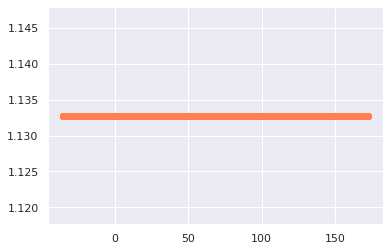

In [85]:
plt.scatter(df_test[model1_label], y_pred_dum, color='coral')

In [86]:
df_test[model1_label]

4681469     6.0
1034394   -15.0
3011767   -15.0
2494819     9.0
2716269    36.0
           ... 
4363312     9.0
2360622    -9.0
32676     -13.0
4927976    -9.0
5469090     0.0
Name: ARR_DELAY, Length: 8000, dtype: float64

In [87]:
y_pred_dum

array([1.13279167, 1.13279167, 1.13279167, ..., 1.13279167, 1.13279167,
       1.13279167])

In [88]:
df['ARR_DELAY'].abs().mean()

17.3251375

=> With all samples and 70% most represented features, without StandardScale :  on test set : lin_rmse = 42.17  
=> With all samples and 80% most represented features, without StandardScale :  on test set : lin_rmse = 42.16  
=> With all samples and 80% most represented features, with StandardScale :  on test set : lin_rmse = 42.16

# Random forest

In [89]:
from sklearn.ensemble import RandomForestRegressor

if (EXECUTE_INTERMEDIATE_MODELS == True):
    random_reg = RandomForestRegressor(n_estimators=10, max_depth=2, random_state=42)
    random_reg.fit(df_train_transformed, df_train[model1_label])

In [90]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_test_predictions = random_reg.predict(df_test_transformed)
    mse = mean_squared_error(df_test[model1_label], df_test_predictions)
    rmse = np.sqrt(mse)
    print(rmse)

=> 42.373691516139964

# SVM

In [91]:
'''
from sklearn.svm import SVR

svm_reg = SVR(kernel="rbf", verbose=True)
svm_reg.fit(df_train_transformed, df_train[model1_label])
'''

'\nfrom sklearn.svm import SVR\n\nsvm_reg = SVR(kernel="rbf", verbose=True)\nsvm_reg.fit(df_train_transformed, df_train[model1_label])\n'

In [92]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(random_state=42, tol=1e-5, verbose=True)

if (EXECUTE_INTERMEDIATE_MODELS == True):
    svm_reg.fit(df_train_transformed, df_train[model1_label])

In [93]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    evaluate_model(svm_reg, df_test_transformed, df_test[model1_label])

=> RMSE : 43.45607643335432

In [94]:
grid_search_SVR = GridSearchCV(svm_reg, param_grid = {"epsilon": [0, 0.5],
                              "C": [1, 5, 10, 100, 1000],
                              "loss": ['epsilon_insensitive', 'squared_epsilon_insensitive'],},cv=shuffled_split_train, scoring='neg_mean_squared_error', error_score=np.nan, verbose=2)

In [95]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    if (RECOMPUTE_GRIDSEARCH == True):
        grid_search_SVR.fit(df_train_transformed, df_train[model1_label])

=> Warning at execution : /home/francois/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)  

In [96]:
if ((SAVE_GRID_RESULTS == False) and (LOAD_GRID_RESULTS == True) and (EXECUTE_INTERMEDIATE_MODELS == True)):
    grid_search = None

if (EXECUTE_INTERMEDIATE_MODELS == True):
    grid_search_SVR, df_grid_search_results = save_or_load_search_params(grid_search_SVR, 'LinearSVR_20200319')

In [97]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_grid_search_results.sort_values(by='mean_test_score', ascending=False)

In [98]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    np.sqrt(1709.197402)

In [99]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    grid_search_SVR.best_estimator_

In [100]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    evaluate_model(grid_search_SVR.best_estimator_, df_test_transformed, df_test[model1_label])

=> Best estimator :  inearSVR(C=1, dual=True, epsilon=0, fit_intercept=True, intercept_scaling=1.0,
          loss='squared_epsilon_insensitive', max_iter=1000, random_state=0,
          tol=1e-05, verbose=True)  

=> RMSE : 42.16

# Polynomial features + linear regression

In [101]:
df_train_transformed

array([[ 1.        , -0.88266927, -1.03156152, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        , -0.0913238 , -0.44394691, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  0.84946031,  1.3188969 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.        ,  0.71360701,  1.0250896 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        , -1.44306413, -0.73775422, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        , -0.28831108,  1.3188969 , ...,  0.        ,
         0.        ,  0.        ]])

In [102]:
poly = ColumnTransformer([
                                ('poly', PolynomialFeatures(degree=2), [0, 1, 2, 3, 4, 5, 6])     
                                ], remainder='passthrough', sparse_threshold=1)

#poly.fit(df_train_transformed, df_train[model1_label])
#poly.fit(df_train_transformed)

In [103]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_train_transformed = poly.fit_transform(df_train_transformed)
    df_test_transformed = poly.transform(df_test_transformed)

In [104]:
df_train_transformed.shape

(72000, 116)

In [105]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    lin_reg = LinearRegression()
    lin_reg.fit(df_train_transformed, df_train[model1_label])

In [106]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])

=> 42.11719088178065

# Polynomial features + random forest

In [107]:
from sklearn.ensemble import RandomForestRegressor

if (EXECUTE_INTERMEDIATE_MODELS == True):
    random_reg = RandomForestRegressor(n_estimators=10, max_depth=2, random_state=42)
    random_reg.fit(df_train_transformed, df_train[model1_label])

In [108]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_test_predictions = random_reg.predict(df_test_transformed)
    evaluate_model(random_reg, df_test_transformed, df_test[model1_label])

In [109]:
#evaluate_model(polynomial_reg, df_test_transformed, df_test[model1_label])

# New try with group by + mean + sort encoding of categorical features
With preparation_pipeline_meansort instead of preparation_pipeline

In [58]:
if (DATA_LOADED == True):
    del df
    del df_train
    del df_test
    del df_train_transformed
    del df_test_transformed

In [59]:
df = load_data()

In [60]:
all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)

Quantitative features : ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT'] 

Qualitative features : ['ORIGIN', 'CRS_DEP_TIME', 'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'TAIL_NUM'] 



In [61]:
#df, df_train, df_test = custom_train_test_split_sample_random(df)
df, df_train, df_test = custom_train_test_split_sample(df)

In [62]:
df_test

ORIGIN CRS_DEP_TIME  MONTH  DAY_OF_MONTH  DAY_OF_WEEK UNIQUE_CARRIER  \
4681469    DFW         1553     11            16            3             EV   
1034394    GPT         0923      6            12            7             EV   
3011767    EWR         1245      2            11            4             B6   
2494819    OAK         1450      3             8            2             WN   
2716269    EWR         1800      3            29            2             AA   
...        ...          ...    ...           ...          ...            ...   
4363312    PHX         1535     10            27            4             WN   
2360622    SFO         1900      3             7            1             DL   
32676      SFO         0615      9             4            7             AA   
4927976    AUS         0953     11            12            6             UA   
5469090    BWI         2050      8            11            4             WN   

        DEST CRS_ARR_TIME  DISTANCE  CRS_ELAPSED_TIME  ARR_DELAY  DEP_DELAY  \
4681469  TYS         1850     771.0             117.0        6.0       -1.0   
1034394  IAH         1051     376.0              88.0      -15.0      -12.0   
3011767  TPA         1545     997.0             180.0      -15.0        8.0   
2494819  SAN         1610     446.0              80.0        9.0       13.0   
2716269  DFW         2112    1372.0             252.0       36.0       62.0   
...      ...          ...       ...               ...        ...        ...   
4363312  SAT         1935     843.0             120.0        9.0        5.0   
2360622  LAX         2025     337.0              85.0       -9.0       -2.0   
32676    DFW         1147    1464.0             212.0      -13.0       -8.0   
4927976  ORD         1231     977.0             158.0       -9.0       -5.0   
5469090  MDW         2155     611.0             125.0        0.0        5.0   

         TAXI_OUT TAIL_NUM  NBFLIGHTS_FORDAY_FORAIRPORT  \
4681469      19.0   N906EV                          528   
1034394       9.0   N14168                           10   
3011767      12.0   N652JB                          329   
2494819       8.0   N272WN                          132   
2716269      23.0   N3FWAA                          424   
...           ...      ...                          ...   
4363312      15.0   N941WN                          436   
2360622      18.0   N915AT                          493   
32676        22.0   N892AA                          396   
4927976      11.0   N841UA                          102   
5469090      17.0   N8627B                          274   

         NBFLIGHTS_FORDAYHOUR_FORAIRPORT  
4681469                               22  
1034394                                2  
3011767                               20  
2494819                                8  
2716269                               22  
...                                  ...  
4363312                               24  
2360622                               21  
32676                                 18  
4927976                                4  
5469090                               18  

[8000 rows x 16 columns]

In [63]:
df.loc[4681469]

ORIGIN                                DFW
CRS_DEP_TIME                         1553
MONTH                                  11
DAY_OF_MONTH                           16
DAY_OF_WEEK                             3
UNIQUE_CARRIER                         EV
DEST                                  TYS
CRS_ARR_TIME                         1850
DISTANCE                              771
CRS_ELAPSED_TIME                      117
ARR_DELAY                               6
DEP_DELAY                              -1
TAXI_OUT                               19
TAIL_NUM                           N906EV
NBFLIGHTS_FORDAY_FORAIRPORT           528
NBFLIGHTS_FORDAYHOUR_FORAIRPORT        22
Name: 4681469, dtype: object

In [25]:
#df_train_transformed = preparation_pipeline_meansort_standardscale.fit_transform(df_train, categoricalfeatures_1hotencoder__categorical_features_totransform=None)

In [64]:
df_train_transformed = preparation_pipeline_meansort_stdscale.fit_transform(df_train)
df_test_transformed = preparation_pipeline_meansort_stdscale.transform(df_test)
DATA_LOADED = True
df_test_transformed.shape

Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Fit data
Fitting feature ORIGIN
Fitting feature UNIQUE_CARRIER
Fitting feature DEST
Encode categorical features...
Encoding feature ORIGIN ...
Encoding feature UNIQUE_CARRIER ...
Encoding feature DEST ...
Features selected (in order): Index(['CRS_ARR_TIME', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DAY_OF_MONTH',
       'DAY_OF_WEEK', 'DEST', 'DISTANCE', 'MONTH',
       'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT',
       'ORIGIN', 'UNIQUE_CARRIER'],
      dtype='object')
Fit Std scale multiple
Transform Std scale multiple
Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Encode categorical features...
Encoding feature ORIGIN ...
Encoding feature UNIQUE_CARRIER ...
Encoding feature DEST ...
Features selected (in order): Index(['CRS_ARR_TIME', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DAY_OF_MONTH',
       'DAY_OF_WEEK', 'DEST', 'DISTANCE', 'MONTH',
       'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFL

(8000, 12)

In [65]:
df_test

ORIGIN  CRS_DEP_TIME  MONTH  DAY_OF_MONTH  DAY_OF_WEEK  \
4681469     266           953     11            16            3   
1034394      51           563      6            12            7   
3011767     251           765      2            11            4   
2494819     264           890      3             8            2   
2716269     251          1080      3            29            2   
...         ...           ...    ...           ...          ...   
4363312     230           935     10            27            4   
2360622     256          1140      3             7            1   
32676       256           375      9             4            7   
4927976     227           593     11            12            6   
5469090     179          1250      8            11            4   

         UNIQUE_CARRIER  DEST  CRS_ARR_TIME  DISTANCE  CRS_ELAPSED_TIME  \
4681469               5   194          1130     771.0             117.0   
1034394               5    78           651     376.0              88.0   
3011767               9   137           945     997.0             180.0   
2494819               8   171           970     446.0              80.0   
2716269               7   156          1272    1372.0             252.0   
...                 ...   ...           ...       ...               ...   
4363312               8   235          1175     843.0             120.0   
2360622               0   255          1225     337.0              85.0   
32676                 7   156           707    1464.0             212.0   
4927976               3   153           751     977.0             158.0   
5469090               8   103          1315     611.0             125.0   

         ARR_DELAY  DEP_DELAY  TAXI_OUT TAIL_NUM  NBFLIGHTS_FORDAY_FORAIRPORT  \
4681469        6.0       -1.0      19.0   N906EV                          528   
1034394      -15.0      -12.0       9.0   N14168                           10   
3011767      -15.0        8.0      12.0   N652JB                          329   
2494819        9.0       13.0       8.0   N272WN                          132   
2716269       36.0       62.0      23.0   N3FWAA                          424   
...            ...        ...       ...      ...                          ...   
4363312        9.0        5.0      15.0   N941WN                          436   
2360622       -9.0       -2.0      18.0   N915AT                          493   
32676        -13.0       -8.0      22.0   N892AA                          396   
4927976       -9.0       -5.0      11.0   N841UA                          102   
5469090        0.0        5.0      17.0   N8627B                          274   

         NBFLIGHTS_FORDAYHOUR_FORAIRPORT  
4681469                               22  
1034394                                2  
3011767                               20  
2494819                                8  
2716269                               22  
...                                  ...  
4363312                               24  
2360622                               21  
32676                                 18  
4927976                                4  
5469090                               18  

[8000 rows x 16 columns]

In [66]:
df_test_transformed

CRS_ARR_TIME  CRS_DEP_TIME  CRS_ELAPSED_TIME  DAY_OF_MONTH  \
4681469      0.720586      0.486053         -0.358844      0.024507   
1034394     -0.823795     -0.838517         -0.742530     -0.429594   
3011767      0.124113     -0.152458          0.474679     -0.543120   
2494819      0.204717      0.272084         -0.848374     -0.883696   
2716269      1.178419      0.917387          1.427277      1.500337   
...               ...           ...               ...           ...   
4363312      0.865674      0.424919         -0.319153      1.273287   
2360622      1.026883      1.121167         -0.782221     -0.997221   
32676       -0.643241     -1.477027          0.898056     -1.337797   
4927976     -0.501378     -0.736627          0.183608     -0.429594   
5469090      1.317059      1.494763         -0.253000     -0.543120   

         DAY_OF_WEEK      DEST  DISTANCE     MONTH  \
4681469    -0.474124  0.490138 -0.114511  1.318897   
1034394     1.544590 -1.352414 -0.757746 -0.150140   
3011767     0.030554 -0.415254  0.253517 -1.325369   
2494819    -0.978803  0.124804 -0.643755 -1.031562   
2716269    -0.978803 -0.113457  0.864183 -1.031562   
...              ...       ...       ...       ...   
4363312     0.030554  1.141384  0.002737  1.025090   
2360622    -1.483481  1.459066 -0.821255 -1.031562   
32676       1.544590 -0.113457  1.013999  0.731282   
4927976     1.039911 -0.161109  0.220948  1.318897   
5469090     0.030554 -0.955313 -0.375062  0.437475   

         NBFLIGHTS_FORDAYHOUR_FORAIRPORT  NBFLIGHTS_FORDAY_FORAIRPORT  \
4681469                        -0.025371                     0.611581   
1034394                        -0.980978                    -1.101660   
3011767                        -0.120932                    -0.046595   
2494819                        -0.694296                    -0.698155   
2716269                        -0.025371                     0.267610   
...                                  ...                          ...   
4363312                         0.070189                     0.307299   
2360622                        -0.073152                     0.495822   
32676                          -0.216493                     0.175002   
4927976                        -0.885417                    -0.797378   
5469090                        -0.216493                    -0.228502   

           ORIGIN  UNIQUE_CARRIER  
4681469  1.211055       -0.029617  
1034394 -2.963685       -0.029617  
3011767  0.919794        1.234246  
2494819  1.172220        0.918280  
2716269  0.919794        0.602314  
...           ...             ...  
4363312  0.512029        0.918280  
2360622  1.016881       -1.609446  
32676    1.016881        0.602314  
4927976  0.453777       -0.661549  
5469090 -0.478258        0.918280  

[8000 rows x 12 columns]

In [116]:
df_train

ORIGIN  CRS_DEP_TIME  MONTH  DAY_OF_MONTH  DAY_OF_WEEK  \
2390410     175           550      3            20            7   
1676587     185           783      5             1            7   
4883040     255          1060     11            22            2   
1553841     245          1090      5             1            7   
1102373     276           795      6             9            4   
...         ...           ...    ...           ...          ...   
356900      187           821      9            12            1   
5056543     187           591     11             3            4   
4382560     272          1020     10            23            7   
3513765     188           385      4            24            7   
4702457     187           725     11             5            6   

         UNIQUE_CARRIER  DEST  CRS_ARR_TIME  DISTANCE  CRS_ELAPSED_TIME  \
2390410               0    81           662     991.0             172.0   
1676587              10   195           984     854.0             141.0   
4883040               4   156          1225     802.0             165.0   
1553841               8   171          1175     480.0              85.0   
1102373               8   242           875     337.0              80.0   
...                 ...   ...           ...       ...               ...   
356900                0   112           835     271.0              74.0   
5056543               0   141           693     515.0             102.0   
4382560               7   255          1168    2342.0             328.0   
3513765               4    78           483     429.0              98.0   
4702457               5    69           791     227.0              66.0   

         ARR_DELAY  DEP_DELAY  TAXI_OUT TAIL_NUM  NBFLIGHTS_FORDAY_FORAIRPORT  \
2390410      -21.0       -6.0      20.0   N331NW                          539   
1676587      -16.0       -4.0      14.0   N613NK                          369   
4883040       -4.0       -6.0      27.0   N103SY                          686   
1553841       -5.0        5.0       7.0   N724SW                          109   
1102373        0.0       17.0       7.0   N420WN                          659   
...            ...        ...       ...      ...                          ...   
356900       -15.0       -2.0      10.0   N932DN                         1118   
5056543       -6.0       -1.0      24.0   N831DN                         1084   
4382560      110.0      102.0      19.0   N7LDAA                          177   
3513765       -1.0       -3.0      20.0   N746SK                           32   
4702457      -13.0       -3.0      12.0   N176PQ                          819   

         NBFLIGHTS_FORDAYHOUR_FORAIRPORT  
2390410                               53  
1676587                               29  
4883040                               59  
1553841                                6  
1102373                               31  
...                                  ...  
356900                                76  
5056543                               78  
4382560                               15  
3513765                                3  
4702457                               67  

[72000 rows x 16 columns]

In [117]:
df_train_transformed

CRS_ARR_TIME  CRS_DEP_TIME  CRS_ELAPSED_TIME  DAY_OF_MONTH  \
2390410     -0.788329     -0.882669          0.368835      0.478609   
1676587      0.249856     -0.091324         -0.041311     -1.678374   
4883040      1.026883      0.849460          0.276221      0.705660   
1553841      0.865674      0.951350         -0.782221     -1.678374   
1102373     -0.101579     -0.050568         -0.848374     -0.770170   
...               ...           ...               ...           ...   
356900      -0.230547      0.037737         -0.927757     -0.429594   
5056543     -0.688380     -0.743420         -0.557302     -1.451323   
4382560      0.843105      0.713607          2.432798      0.819185   
3513765     -1.365457     -1.443064         -0.610224      0.932710   
4702457     -0.372410     -0.288311         -1.033601     -1.224272   

         DAY_OF_WEEK      DEST  DISTANCE     MONTH  \
2390410     1.544590 -1.304762  0.243746 -1.031562   
1676587     1.544590  0.506022  0.020649 -0.443947   
4883040    -0.978803 -0.113457 -0.064030  1.318897   
1553841     1.544590  0.124804 -0.588388 -0.443947   
1102373     0.030554  1.252573 -0.821255 -0.150140   
...              ...       ...       ...       ...   
356900     -1.483481 -0.812356 -0.928733  0.731282   
5056543     0.030554 -0.351718 -0.531393  1.318897   
4382560     1.544590  1.459066  2.443772  1.025090   
3513765     1.544590 -1.352414 -0.671439 -0.737754   
4702457     1.039911 -1.495371 -1.000384  1.318897   

         NBFLIGHTS_FORDAYHOUR_FORAIRPORT  NBFLIGHTS_FORDAY_FORAIRPORT  \
2390410                         1.455819                     0.647963   
1676587                         0.309091                     0.085702   
4883040                         1.742501                     1.134153   
1553841                        -0.789857                    -0.774226   
1102373                         0.404652                     1.044852   
...                                  ...                          ...   
356900                          2.554767                     2.562956   
5056543                         2.650327                     2.450504   
4382560                        -0.359834                    -0.549322   
3513765                        -0.933198                    -1.028897   
4702457                         2.124744                     1.574039   

           ORIGIN  UNIQUE_CARRIER  
2390410 -0.555928       -1.609446  
1676587 -0.361754        1.550212  
4883040  0.997464       -0.345583  
1553841  0.803290        0.918280  
1102373  1.405229        0.918280  
...           ...             ...  
356900  -0.322919       -1.609446  
5056543 -0.322919       -1.609446  
4382560  1.327559        0.602314  
3513765 -0.303502       -0.345583  
4702457 -0.322919       -0.029617  

[72000 rows x 12 columns]

In [118]:
df_train_transformed.shape[1]

12

In [119]:
len(MODEL1_GOUPBYMEAN_FEATURES)

12

In [120]:
df_train_transformed.shape[1]

12

In [121]:
df_train[df_train['CRS_DEP_TIME'] < 200]

ORIGIN  CRS_DEP_TIME  MONTH  DAY_OF_MONTH  DAY_OF_WEEK  \
2767397     256            15      3            24            4   
5304719     209            40      8            17            3   
1454856     153            35      5            14            6   
3747183     230            59      1             2            6   
616299      222            25      7             1            5   
...         ...           ...    ...           ...          ...   
987046      127           165      6            20            1   
3691061     153            55      4             1            5   
5323620     246            41      8            28            7   
4501186     270           179     10             4            2   
5112283     246            55      8            10            3   

         UNIQUE_CARRIER  DEST  CRS_ARR_TIME  DISTANCE  CRS_ELAPSED_TIME  \
2767397               7   127           486    2296.0             291.0   
5304719               6   184           380    1558.0             220.0   
1454856               0   129           348    1426.0             193.0   
3747183               7   209           456    2300.0             277.0   
616299                7    70            95     226.0              70.0   
...                 ...   ...           ...       ...               ...   
987046                1   134           425    1448.0             200.0   
3691061               0   129           369    1426.0             194.0   
5323620              10   158           321    1139.0             160.0   
4501186              10   181           329     982.0             150.0   
5112283               7   127           489    1916.0             254.0   

         ARR_DELAY  DEP_DELAY  TAXI_OUT TAIL_NUM  NBFLIGHTS_FORDAY_FORAIRPORT  \
2767397        2.0       -1.0      14.0   N536UW                          550   
5304719       13.0       24.0      16.0   N203FR                          682   
1454856      -26.0       -6.0      10.0   N3757D                          140   
3747183        1.0       -1.0      15.0   N640AW                          458   
616299       -12.0       -4.0      13.0   N755US                          337   
...            ...        ...       ...      ...                          ...   
987046        -7.0      -16.0      14.0   N461AS                           68   
3691061        4.0       -2.0      13.0   N623DL                          114   
5323620      -20.0      -10.0      13.0   N640NK                          431   
4501186       14.0       12.0      17.0   N665NK                            5   
5112283        0.0       -3.0      29.0   N535UW                          420   

         NBFLIGHTS_FORDAYHOUR_FORAIRPORT  
2767397                                8  
5304719                                3  
1454856                                2  
3747183                               16  
616299                                17  
...                                  ...  
987046                                 1  
3691061                                2  
5323620                                7  
4501186                                2  
5112283                                9  

[299 rows x 16 columns]

In [122]:
df['CRS_DEP_TIME']

1501291    1332
3922762    1340
214125     1455
1361083    2230
2880946    1726
           ... 
1973186    1340
5138950    1000
2595055    1105
2389103    1157
5214118    1237
Name: CRS_DEP_TIME, Length: 80000, dtype: object

In [123]:
df_train['CRS_DEP_TIME']

2390410     550
1676587     783
4883040    1060
1553841    1090
1102373     795
           ... 
356900      821
5056543     591
4382560    1020
3513765     385
4702457     725
Name: CRS_DEP_TIME, Length: 72000, dtype: int64

(array([  68.,  130.,   42.,   37.,   14.,    4.,    6.,    6.,    4.,
           4.,  374.,  885., 2392., 2046., 2639., 2111., 2062., 2124.,
        2435., 1914., 2085., 2258., 2128., 2394., 1715., 2181., 2081.,
        2073., 2309., 1714., 1986., 2249., 2069., 1660., 2085., 2226.,
        2452., 1956., 1868., 2030., 1999., 1953., 1741., 1255., 1025.,
        1059., 1070.,  507.,  292.,  283.]),
 array([1.00000e+00, 2.97600e+01, 5.85200e+01, 8.72800e+01, 1.16040e+02,
        1.44800e+02, 1.73560e+02, 2.02320e+02, 2.31080e+02, 2.59840e+02,
        2.88600e+02, 3.17360e+02, 3.46120e+02, 3.74880e+02, 4.03640e+02,
        4.32400e+02, 4.61160e+02, 4.89920e+02, 5.18680e+02, 5.47440e+02,
        5.76200e+02, 6.04960e+02, 6.33720e+02, 6.62480e+02, 6.91240e+02,
        7.20000e+02, 7.48760e+02, 7.77520e+02, 8.06280e+02, 8.35040e+02,
        8.63800e+02, 8.92560e+02, 9.21320e+02, 9.50080e+02, 9.78840e+02,
        1.00760e+03, 1.03636e+03, 1.06512e+03, 1.09388e+03, 1.12264e+03,
        1.15140e

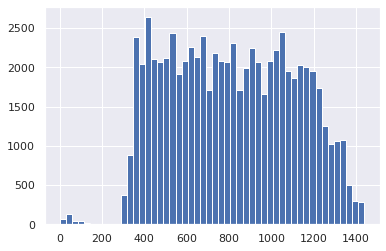

In [124]:
plt.hist(df_train['CRS_DEP_TIME'], bins=50)

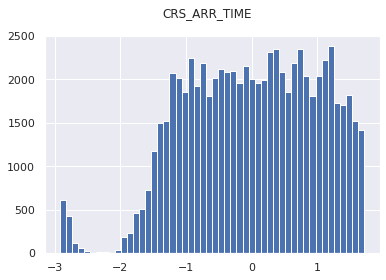

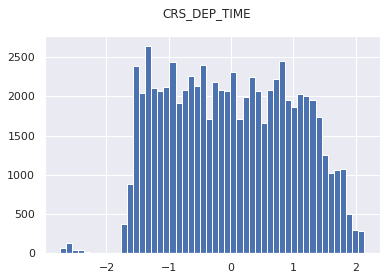

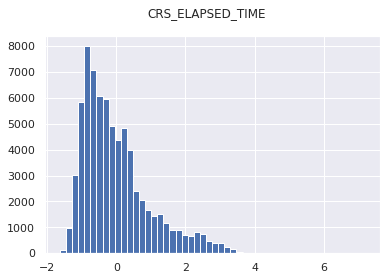

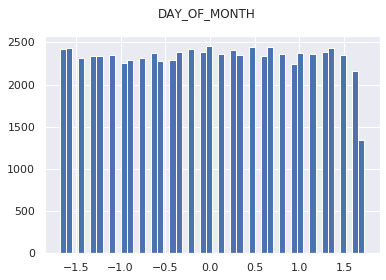

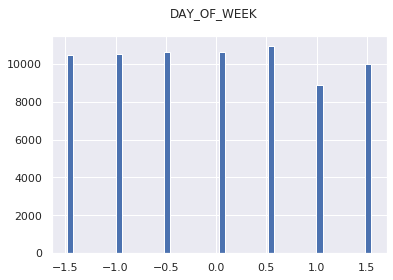

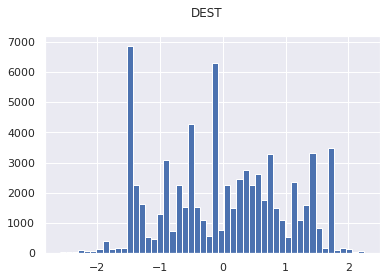

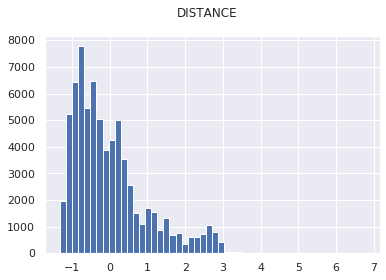

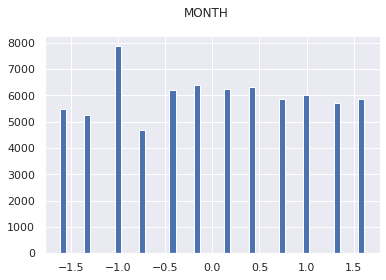

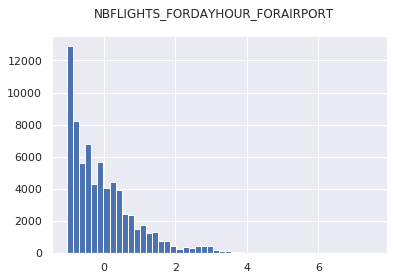

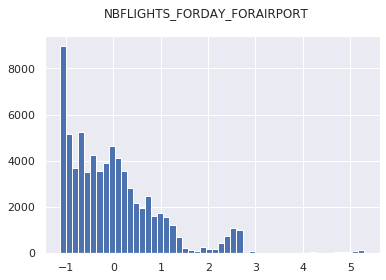

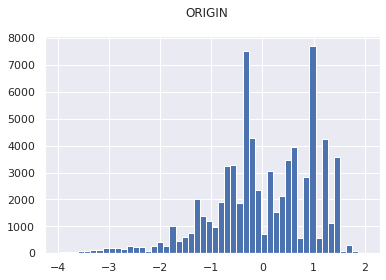

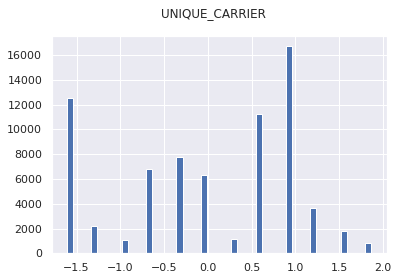

In [125]:
for feat_name in df_train_transformed.columns:
    fig = plt.figure()
    fig.suptitle(feat_name)
    plt.hist(df_train_transformed[feat_name], bins=50)
    plt.plot()

In [126]:
abs(df_train['ARR_DELAY'].min())

35.0

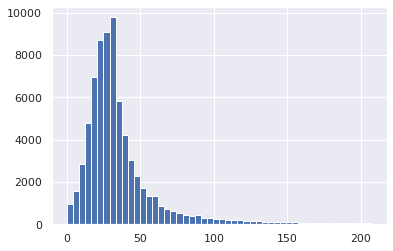

In [127]:
(df_train['ARR_DELAY'] + abs(df_train['ARR_DELAY'].min())).hist(bins=50)

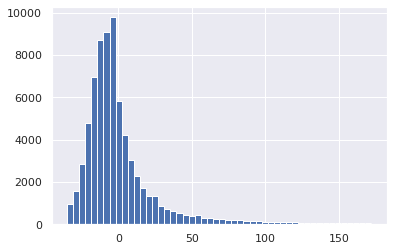

In [128]:
df_train['ARR_DELAY'].hist(bins=50)

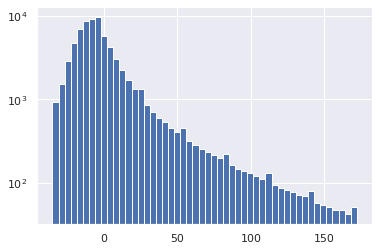

In [129]:
df_train['ARR_DELAY'].hist(bins=50, log=True)

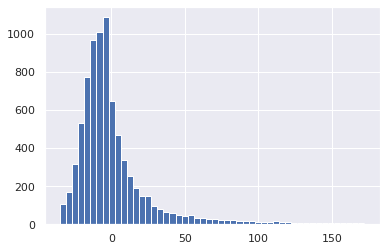

In [130]:
df_test['ARR_DELAY'].hist(bins=50)

In [131]:
df_train_labels = df_train[model1_label]
df_test_labels = df_test[model1_label]

In [132]:
df_train_labels_positive = df_train[model1_label] + abs(df_train[model1_label].min()) + 1

In [133]:
pt = preprocessing.PowerTransformer(method='box-cox', standardize=False)

In [134]:
df_train_labels_positive_log = pt.fit_transform(df_train_labels_positive.to_numpy().reshape(-1, 1))

In [135]:
#df_train_labels_positive_log_inverse = pt.inverse_transform(df_train_labels_positive_log) -1 - abs(df_train['ARR_DELAY'].min())

## With scaling of labels

In [136]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(df_train_transformed, df_train_labels_positive_log)

df_train_predictions_positive_log = lin_reg.predict(df_train_transformed)
df_train_predictions_positive = pt.inverse_transform(df_train_predictions_positive_log)
df_train_predictions = df_train_predictions_positive -1 - abs(df_train['ARR_DELAY'].min())

df_test_predictions_positive_log = lin_reg.predict(df_test_transformed)
df_test_predictions_positive = pt.inverse_transform(df_test_predictions_positive_log)
df_test_predictions = df_test_predictions_positive -1 - abs(df_test['ARR_DELAY'].min())

mse = mean_squared_error(df_train_labels, df_train_predictions)
rmse = np.sqrt(mse)
print(f'RMSE on training set : {rmse}')

mse = mean_squared_error(df_test_labels, df_test_predictions)
rmse = np.sqrt(mse)
print(f'RMSE on test set : {rmse}')

RMSE on training set : 27.69837997753907
RMSE on test set : 27.883921741329324


=> Log scaling of labels does not seem to make a difference. Result is even worse  (28.4 instead of 27)

(array([3.000e+00, 2.000e+00, 5.000e+00, 7.000e+00, 1.400e+01, 1.600e+01,
        4.600e+01, 7.200e+01, 9.300e+01, 1.740e+02, 2.450e+02, 3.310e+02,
        5.330e+02, 6.200e+02, 8.080e+02, 9.990e+02, 1.194e+03, 1.489e+03,
        1.732e+03, 1.992e+03, 2.355e+03, 2.511e+03, 3.053e+03, 3.176e+03,
        3.394e+03, 3.415e+03, 3.679e+03, 3.711e+03, 3.691e+03, 3.898e+03,
        3.811e+03, 3.469e+03, 3.511e+03, 3.152e+03, 2.799e+03, 2.424e+03,
        2.138e+03, 1.785e+03, 1.444e+03, 1.241e+03, 8.940e+02, 7.360e+02,
        5.470e+02, 3.500e+02, 2.170e+02, 1.440e+02, 5.300e+01, 2.200e+01,
        4.000e+00, 1.000e+00]),
 array([3.264494  , 3.29374134, 3.32298867, 3.352236  , 3.38148334,
        3.41073067, 3.43997801, 3.46922534, 3.49847267, 3.52772001,
        3.55696734, 3.58621468, 3.61546201, 3.64470934, 3.67395668,
        3.70320401, 3.73245135, 3.76169868, 3.79094602, 3.82019335,
        3.84944068, 3.87868802, 3.90793535, 3.93718269, 3.96643002,
        3.99567735, 4.02492469, 4.05

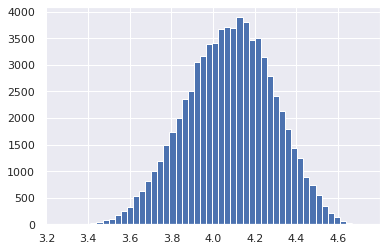

In [137]:
plt.hist(df_train_predictions_positive_log, bins=50)

(array([3.000e+00, 1.000e+01, 1.400e+01, 3.500e+01, 7.700e+01, 1.510e+02,
        2.740e+02, 4.170e+02, 7.080e+02, 8.770e+02, 1.153e+03, 1.424e+03,
        1.801e+03, 2.097e+03, 2.440e+03, 2.701e+03, 3.106e+03, 3.376e+03,
        3.488e+03, 3.567e+03, 3.680e+03, 3.590e+03, 3.609e+03, 3.636e+03,
        3.665e+03, 3.368e+03, 3.064e+03, 3.008e+03, 2.675e+03, 2.373e+03,
        2.008e+03, 1.789e+03, 1.571e+03, 1.277e+03, 1.114e+03, 9.220e+02,
        6.990e+02, 5.960e+02, 5.000e+02, 3.750e+02, 2.560e+02, 1.830e+02,
        1.400e+02, 9.600e+01, 4.700e+01, 2.500e+01, 1.000e+01, 3.000e+00,
        1.000e+00, 1.000e+00]),
 array([-1.90053950e+01, -1.83718166e+01, -1.77382382e+01, -1.71046598e+01,
        -1.64710813e+01, -1.58375029e+01, -1.52039245e+01, -1.45703461e+01,
        -1.39367677e+01, -1.33031893e+01, -1.26696109e+01, -1.20360325e+01,
        -1.14024541e+01, -1.07688757e+01, -1.01352973e+01, -9.50171892e+00,
        -8.86814052e+00, -8.23456211e+00, -7.60098371e+00, -6.96740531e+

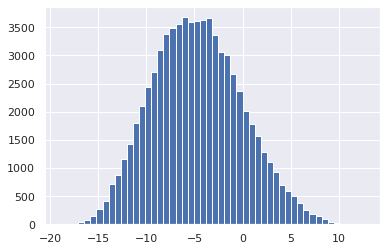

In [138]:
plt.hist(df_train_predictions, bins=50)

## Without scaling of labels

In [139]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(df_train_transformed, df_train[model1_label])

df_test_predictions = lin_reg.predict(df_test_transformed)

mse = mean_squared_error(df_train_labels, df_train_predictions)
rmse = np.sqrt(mse)
print(f'RMSE on training set : {rmse}')

mse = mean_squared_error(df_test_labels, df_test_predictions)
rmse = np.sqrt(mse)
print(f'RMSE on test set : {rmse}')

RMSE on training set : 27.69837997753907
RMSE on test set : 27.158040021734173


=> Evaluation on test set :  
RMSE : 27.079383490783385  

  
Evaluation on training set :  
RMSE : 27.07763523727725  



En ayant enlevé  :  'NBFLIGHTS_FORDAY_FORAIRPORT',  
       'ORIGIN', 'UNIQUE_CARRIER' :  

Evaluation on test set :  
RMSE : 27.19385016531133  

Remettre juste 'NBFLIGHTS_FORDAY_FORAIRPORT' n'y change rien  
En remettant ORIGIN => passage à 27.14  
En remettant UNIQUE_CARRIER => passage à 27.08

In [140]:
error_percent_threshold = evaluate_model_percent_threshold(lin_reg, df_test_transformed, df_test[model1_label], EVALUATION_PERCENT, 20)
print(f'{error_percent_threshold : .2f}% predictions have error below {EVALUATION_THRESHOLD} min, {EVALUATION_PERCENT*100}% of the time')

 82.28% predictions have error below 5 min, 90.0% of the time


In [141]:
error_mean = evaluate_model_percent_mean(lin_reg, df_test_transformed, df_test[model1_label], 0.8)
print(f'Mean prediction error {EVALUATION_PERCENT*100}% of the time : {error_mean : .2f}')

Mean prediction error 90.0% of the time :  10.12


(array([3.000e+00, 1.000e+01, 1.400e+01, 3.500e+01, 7.700e+01, 1.510e+02,
        2.740e+02, 4.170e+02, 7.080e+02, 8.770e+02, 1.153e+03, 1.424e+03,
        1.801e+03, 2.097e+03, 2.440e+03, 2.701e+03, 3.106e+03, 3.376e+03,
        3.488e+03, 3.567e+03, 3.680e+03, 3.590e+03, 3.609e+03, 3.636e+03,
        3.665e+03, 3.368e+03, 3.064e+03, 3.008e+03, 2.675e+03, 2.373e+03,
        2.008e+03, 1.789e+03, 1.571e+03, 1.277e+03, 1.114e+03, 9.220e+02,
        6.990e+02, 5.960e+02, 5.000e+02, 3.750e+02, 2.560e+02, 1.830e+02,
        1.400e+02, 9.600e+01, 4.700e+01, 2.500e+01, 1.000e+01, 3.000e+00,
        1.000e+00, 1.000e+00]),
 array([-1.90053950e+01, -1.83718166e+01, -1.77382382e+01, -1.71046598e+01,
        -1.64710813e+01, -1.58375029e+01, -1.52039245e+01, -1.45703461e+01,
        -1.39367677e+01, -1.33031893e+01, -1.26696109e+01, -1.20360325e+01,
        -1.14024541e+01, -1.07688757e+01, -1.01352973e+01, -9.50171892e+00,
        -8.86814052e+00, -8.23456211e+00, -7.60098371e+00, -6.96740531e+

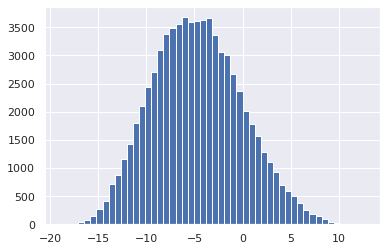

In [142]:
plt.hist(df_train_predictions, bins=50)

=> RMSE on training set : 41.35267146874754 (close to RMSE on test set => under fitting)

(array([  1.,   3.,   6.,   4.,  15.,  19.,  25.,  20.,  32.,  51.,  65.,
         62.,  98.,  97., 127., 151., 168., 206., 226., 241., 266., 308.,
        324., 328., 339., 387., 349., 354., 389., 352., 328., 337., 296.,
        313., 250., 216., 218., 210., 185., 144., 147.,  95.,  66.,  60.,
         47.,  29.,  19.,  17.,   5.,   5.]),
 array([-16.89690507, -16.23684359, -15.57678212, -14.91672064,
        -14.25665916, -13.59659768, -12.93653621, -12.27647473,
        -11.61641325, -10.95635177, -10.2962903 ,  -9.63622882,
         -8.97616734,  -8.31610587,  -7.65604439,  -6.99598291,
         -6.33592143,  -5.67585996,  -5.01579848,  -4.355737  ,
         -3.69567552,  -3.03561405,  -2.37555257,  -1.71549109,
         -1.05542962,  -0.39536814,   0.26469334,   0.92475482,
          1.58481629,   2.24487777,   2.90493925,   3.56500072,
          4.2250622 ,   4.88512368,   5.54518516,   6.20524663,
          6.86530811,   7.52536959,   8.18543107,   8.84549254,
          9.505554

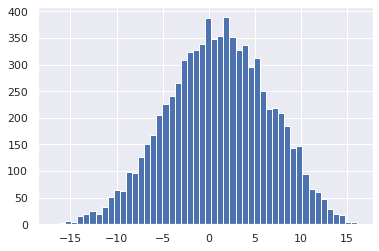

In [143]:
plt.hist(df_test_predictions, bins=50)

In [144]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison actual values / predict values on test set')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_test[model1_label], df_test_predictions, color='coral', alpha=0.1)

In [145]:
df_train_predictions = lin_reg.predict(df_train_transformed)

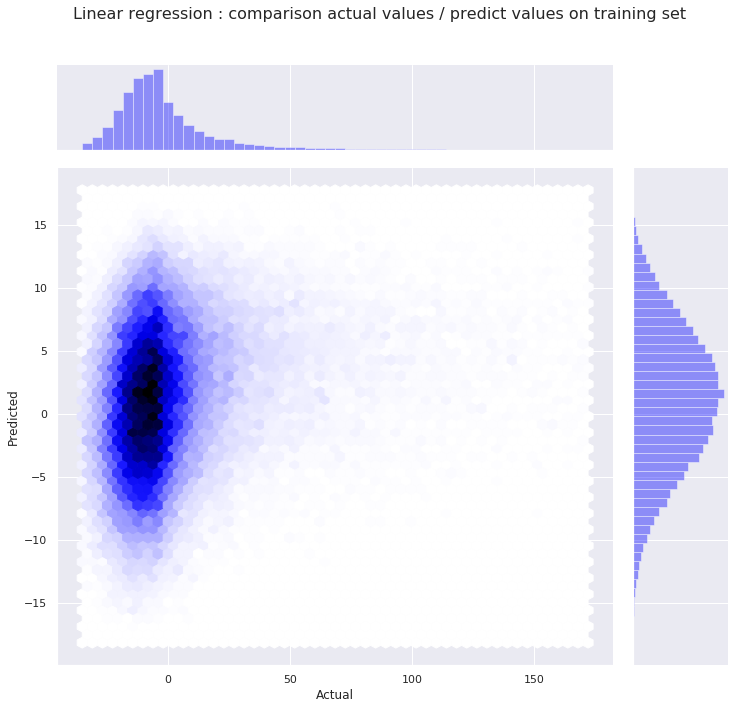

In [146]:
#if (EXECUTE_INTERMEDIATE_MODELS == True):

g = sns.jointplot(x=df_train[model1_label], y=df_train_predictions, kind='hex', color='blue', height=10)
#sns.jointplot(x=df_test[model1_label], y=df_test_predictions, alpha=0.01)

g.set_axis_labels("Actual", "Predicted")
plt.subplots_adjust(top=0.9)
plt.suptitle('Linear regression : comparison actual values / predict values on training set', fontsize = 16)

plt.savefig('linreg_actual_vs_predicted_training_set.png', dpi=400)
    

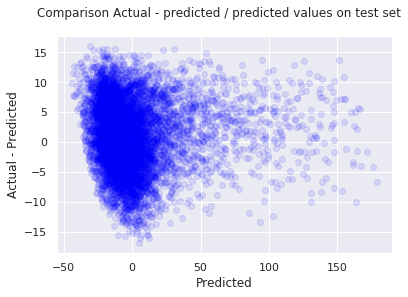

In [147]:
#if (EXECUTE_INTERMEDIATE_MODELS == True):
fig = plt.figure()
fig.suptitle('Comparison Actual - predicted / predicted values on test set')
plt.xlabel("Predicted")
plt.ylabel("Actual - Predicted")
plt.scatter(df_test[model1_label] - df_test_predictions, df_test_predictions, color='blue', alpha=0.1)

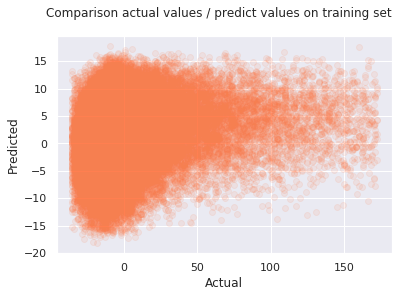

In [148]:
df_train_predictions = lin_reg.predict(df_train_transformed)

#if (EXECUTE_INTERMEDIATE_MODELS == True):
fig = plt.figure()
fig.suptitle('Comparison actual values / predict values on training set')
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.scatter(df_train[model1_label], df_train_predictions, color='coral', alpha=0.1)

In [149]:
lin_reg.coef_

array([ 1.12771456,  2.80283365, -3.436442  ,  0.19877577, -0.00681952,
        2.26561077,  2.82782638,  0.3323954 ,  0.20743688, -0.29565754,
        1.94591183,  1.44738594])

In [150]:
# Feature importances :
(abs(lin_reg.coef_) / (abs(lin_reg.coef_).sum()))

array([0.06674917, 0.16589909, 0.20340223, 0.01176549, 0.00040365,
       0.13410099, 0.1673784 , 0.01967441, 0.01227814, 0.0174999 ,
       0.11517808, 0.08567045])

Features < 0.01 importance :   
'NBFLIGHTS_FORDAY_FORAIRPORT',
       'ORIGIN', 'UNIQUE_CARRIER'
       
=> NBFLIGHTS_FORDAY_FORAIRPORT removed from MODEL1_GOUPBYMEAN_FEATURES  
=> ORIGIN and UNIQUE_CARRIER kept   

In [151]:
df_train_transformed.shape

(72000, 12)

In [152]:
df_train_transformed

CRS_ARR_TIME  CRS_DEP_TIME  CRS_ELAPSED_TIME  DAY_OF_MONTH  \
2390410     -0.788329     -0.882669          0.368835      0.478609   
1676587      0.249856     -0.091324         -0.041311     -1.678374   
4883040      1.026883      0.849460          0.276221      0.705660   
1553841      0.865674      0.951350         -0.782221     -1.678374   
1102373     -0.101579     -0.050568         -0.848374     -0.770170   
...               ...           ...               ...           ...   
356900      -0.230547      0.037737         -0.927757     -0.429594   
5056543     -0.688380     -0.743420         -0.557302     -1.451323   
4382560      0.843105      0.713607          2.432798      0.819185   
3513765     -1.365457     -1.443064         -0.610224      0.932710   
4702457     -0.372410     -0.288311         -1.033601     -1.224272   

         DAY_OF_WEEK      DEST  DISTANCE     MONTH  \
2390410     1.544590 -1.304762  0.243746 -1.031562   
1676587     1.544590  0.506022  0.020649 -0.443947   
4883040    -0.978803 -0.113457 -0.064030  1.318897   
1553841     1.544590  0.124804 -0.588388 -0.443947   
1102373     0.030554  1.252573 -0.821255 -0.150140   
...              ...       ...       ...       ...   
356900     -1.483481 -0.812356 -0.928733  0.731282   
5056543     0.030554 -0.351718 -0.531393  1.318897   
4382560     1.544590  1.459066  2.443772  1.025090   
3513765     1.544590 -1.352414 -0.671439 -0.737754   
4702457     1.039911 -1.495371 -1.000384  1.318897   

         NBFLIGHTS_FORDAYHOUR_FORAIRPORT  NBFLIGHTS_FORDAY_FORAIRPORT  \
2390410                         1.455819                     0.647963   
1676587                         0.309091                     0.085702   
4883040                         1.742501                     1.134153   
1553841                        -0.789857                    -0.774226   
1102373                         0.404652                     1.044852   
...                                  ...                          ...   
356900                          2.554767                     2.562956   
5056543                         2.650327                     2.450504   
4382560                        -0.359834                    -0.549322   
3513765                        -0.933198                    -1.028897   
4702457                         2.124744                     1.574039   

           ORIGIN  UNIQUE_CARRIER  
2390410 -0.555928       -1.609446  
1676587 -0.361754        1.550212  
4883040  0.997464       -0.345583  
1553841  0.803290        0.918280  
1102373  1.405229        0.918280  
...           ...             ...  
356900  -0.322919       -1.609446  
5056543 -0.322919       -1.609446  
4382560  1.327559        0.602314  
3513765 -0.303502       -0.345583  
4702457 -0.322919       -0.029617  

[72000 rows x 12 columns]

Calculating learning curve for 10 iterations


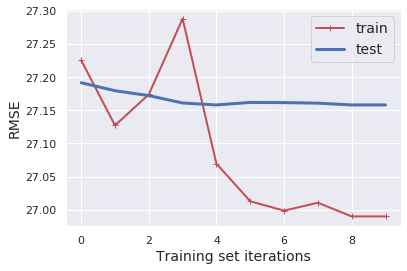

In [153]:
plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE)

## Random forest

In [154]:
%%time
from sklearn.ensemble import RandomForestRegressor

#if (EXECUTE_INTERMEDIATE_MODELS == True):
random_reg = RandomForestRegressor(n_estimators=100, max_depth=100, n_jobs=-1, random_state=42)
random_reg.fit(df_train_transformed, df_train[model1_label])

CPU times: user 1min 47s, sys: 533 ms, total: 1min 47s
Wall time: 15.1 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [155]:
# Model obtained via GridSearch :
#%%time
from sklearn.ensemble import RandomForestRegressor

#if (EXECUTE_INTERMEDIATE_MODELS == True):    
random_reg = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=1000,
                      max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

random_reg.fit(df_train_transformed, df_train[model1_label])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=1000,
                      max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [156]:
print("Evaluation on test set :")
evaluate_model(random_reg, df_test_transformed, df_test[model1_label])

print('\n')

print("Evaluation on training set :")
evaluate_model(random_reg, df_train_transformed, df_train[model1_label])

Evaluation on test set :
RMSE : 27.247924047824267


Evaluation on training set :
RMSE : 9.947248367519085


With parameters before GridSearch optimisation :
    With shuffle split by ARR_DELAY strategy and 80000 samples :  
    RMSE : 27.779707360544677  

    Evaluation on training set:  
    RMSE : 10.27032737489414  

In [157]:
error_mean = evaluate_model_percent_mean(random_reg, df_test_transformed, df_test[model1_label], 0.8)
print(f'Mean prediction error {EVALUATION_PERCENT*100}% of the time : {error_mean : .2f}')

Mean prediction error 90.0% of the time :  10.36


=> ~ 10 min with 80000 lines  
=> 9.75 min with 800000 lines

In [158]:
error_mean_train = evaluate_model_percent_mean(random_reg, df_train_transformed, df_train[model1_label], 0.8)
print(f'Mean prediction error {EVALUATION_PERCENT*100}% of the time : {error_mean_train : .2f}')

Mean prediction error 90.0% of the time :  3.77


In [159]:
df_test_predictions = random_reg.predict(df_test_transformed)

In [160]:
df_train_predictions = random_reg.predict(df_train_transformed)

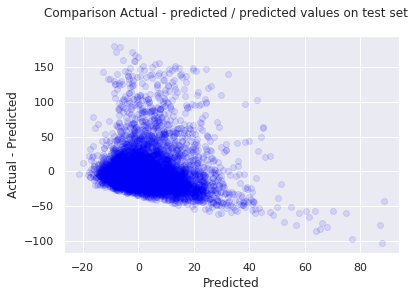

In [161]:
#if (EXECUTE_INTERMEDIATE_MODELS == True):
fig = plt.figure()
fig.suptitle('Comparison Actual - predicted / predicted values on test set')
plt.xlabel("Predicted")
plt.ylabel("Actual - Predicted")
plt.scatter(df_test_predictions, df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

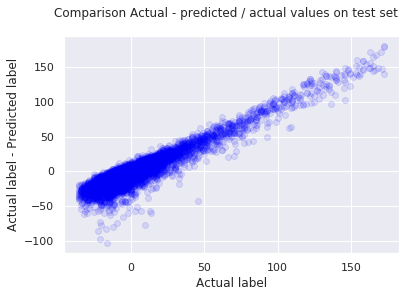

In [162]:
#if (EXECUTE_INTERMEDIATE_MODELS == True):
fig = plt.figure()
fig.suptitle('Comparison Actual - predicted / actual values on test set')
plt.xlabel("Actual label")
plt.ylabel("Actual label - Predicted label")
plt.scatter(df_test[model1_label], df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

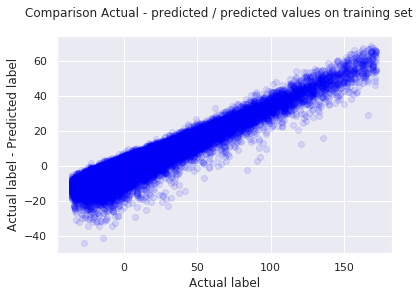

In [163]:
#if (EXECUTE_INTERMEDIATE_MODELS == True):
fig = plt.figure()
fig.suptitle('Comparison Actual - predicted / predicted values on training set')
plt.xlabel("Actual label")
plt.ylabel("Actual label - Predicted label")
plt.scatter(df_train[model1_label], df_train[model1_label] - df_train_predictions, color='blue', alpha=0.1)

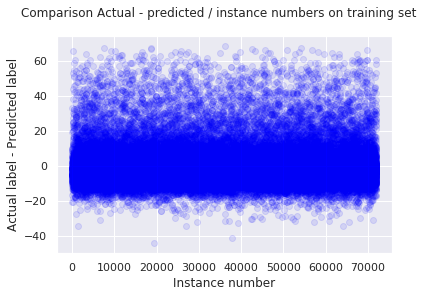

In [164]:
#if (EXECUTE_INTERMEDIATE_MODELS == True):
fig = plt.figure()
fig.suptitle('Comparison Actual - predicted / instance numbers on training set')
plt.xlabel("Instance number")
plt.ylabel("Actual label - Predicted label")
plt.scatter(range(df_train.shape[0]), df_train[model1_label] - df_train_predictions, color='blue', alpha=0.1)

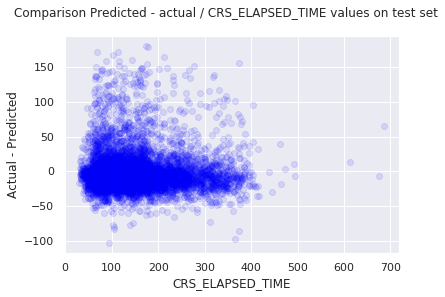

In [165]:
#if (EXECUTE_INTERMEDIATE_MODELS == True):
fig = plt.figure()
fig.suptitle('Comparison Predicted - actual / CRS_ELAPSED_TIME values on test set')
plt.xlabel("CRS_ELAPSED_TIME")
plt.ylabel("Actual - Predicted")
plt.scatter(df_test['CRS_ELAPSED_TIME'], df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

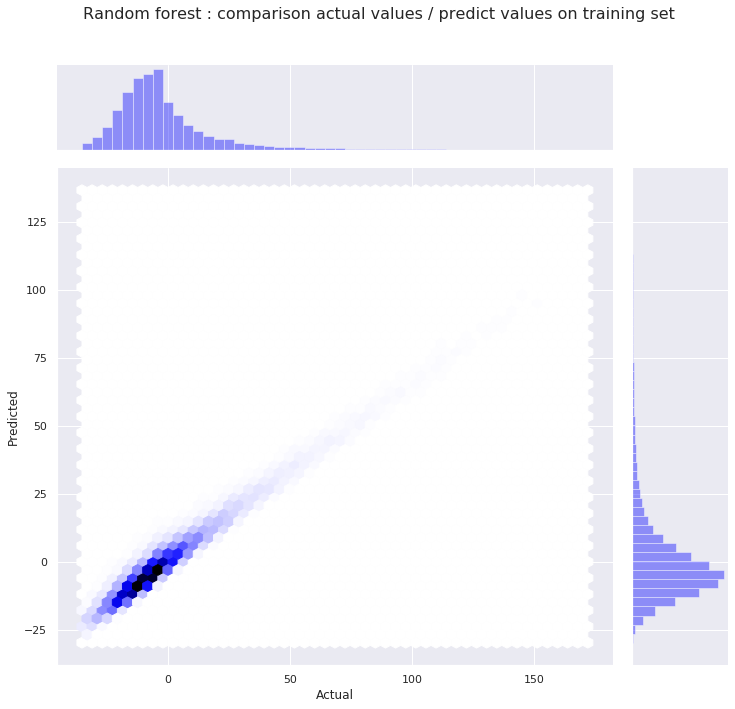

In [166]:
#if (EXECUTE_INTERMEDIATE_MODELS == True):

g = sns.jointplot(x=df_train[model1_label], y=df_train_predictions, kind='hex', color='blue', height=10)
#sns.jointplot(x=df_test[model1_label], y=df_test_predictions, alpha=0.01)

g.set_axis_labels("Actual", "Predicted")
plt.subplots_adjust(top=0.9)
plt.suptitle('Random forest : comparison actual values / predict values on training set', fontsize = 16)

plt.savefig('randomreg_actual_vs_predicted_training_set.png', dpi=400)
    

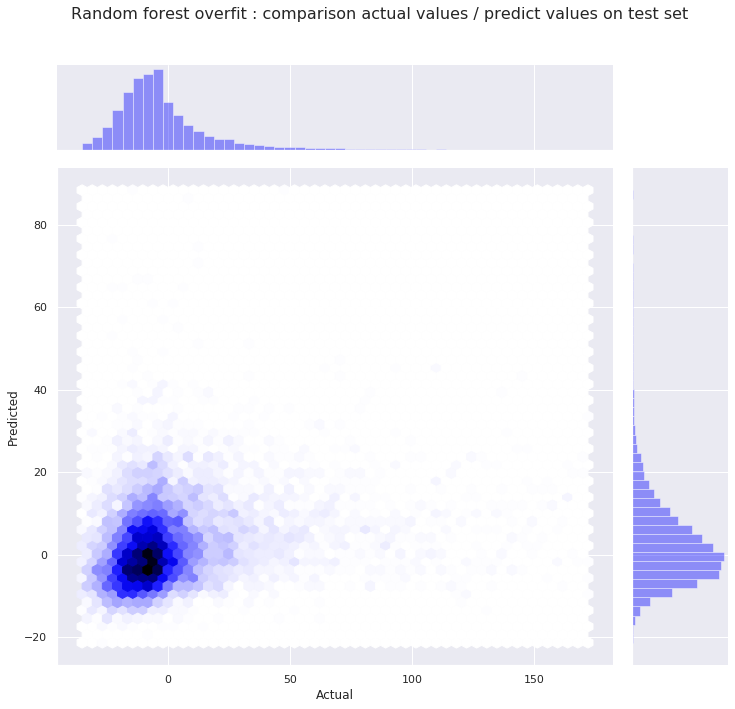

In [167]:
#if (EXECUTE_INTERMEDIATE_MODELS == True):

g = sns.jointplot(x=df_test[model1_label], y=df_test_predictions, kind='hex', color='blue', height=10)
#sns.jointplot(x=df_test[model1_label], y=df_test_predictions, alpha=0.01)

g.set_axis_labels("Actual", "Predicted")
plt.subplots_adjust(top=0.9)
plt.suptitle('Random forest overfit : comparison actual values / predict values on test set', fontsize = 16)

plt.savefig('randomreg_overfit_actual_vs_predicted_test_set.png', dpi=400)


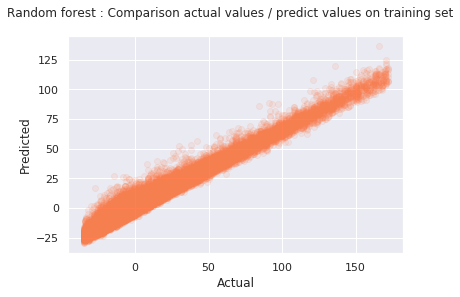

In [168]:
df_train_predictions = random_reg.predict(df_train_transformed)

#if (EXECUTE_INTERMEDIATE_MODELS == True):
fig = plt.figure()
fig.suptitle('Random forest : Comparison actual values / predict values on training set')
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.scatter(df_train[model1_label], df_train_predictions, color='coral', alpha=0.1)

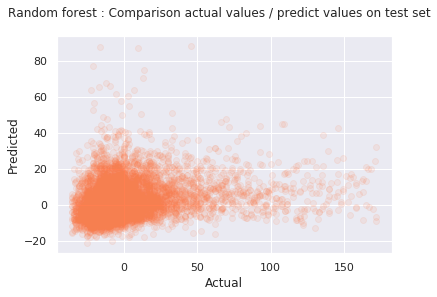

In [169]:
df_test_predictions = random_reg.predict(df_test_transformed)

#if (EXECUTE_INTERMEDIATE_MODELS == True):
fig = plt.figure()
fig.suptitle('Random forest : Comparison actual values / predict values on test set')
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.scatter(df_test[model1_label], df_test_predictions, color='coral', alpha=0.1)

In [170]:
df_train_transformed.columns

Index(['CRS_ARR_TIME', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DAY_OF_MONTH',
       'DAY_OF_WEEK', 'DEST', 'DISTANCE', 'MONTH',
       'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT',
       'ORIGIN', 'UNIQUE_CARRIER'],
      dtype='object')

In [171]:
pd.set_option('display.max_rows', 200)

In [172]:
df_feature_importances = pd.DataFrame(data = {'Feature name' : df_train_transformed.columns, 'Feature importance' : random_reg.feature_importances_})

In [173]:
pd.concat([df_feature_importances.sort_values(by='Feature importance', ascending=False), \
           df_feature_importances[['Feature importance']].sort_values(by='Feature importance', ascending=False).cumsum()], axis=1)

Feature name  Feature importance  Feature importance
0                      CRS_ARR_TIME            0.112635            0.112635
9       NBFLIGHTS_FORDAY_FORAIRPORT            0.112310            0.224945
1                      CRS_DEP_TIME            0.110252            0.335198
3                      DAY_OF_MONTH            0.096700            0.431897
2                  CRS_ELAPSED_TIME            0.095246            0.527143
8   NBFLIGHTS_FORDAYHOUR_FORAIRPORT            0.083653            0.610796
6                          DISTANCE            0.082779            0.693575
5                              DEST            0.078732            0.772308
7                             MONTH            0.064558            0.836866
10                           ORIGIN            0.064170            0.901035
4                       DAY_OF_WEEK            0.056951            0.957986
11                   UNIQUE_CARRIER            0.042014            1.000000

In [174]:
random_reg.feature_importances_

array([0.11263548, 0.11025213, 0.09524598, 0.09669979, 0.05695089,
       0.07873208, 0.08277916, 0.06455811, 0.08365299, 0.11230992,
       0.06416962, 0.04201384])

In [175]:
random_reg.feature_importances_.cumsum()

array([0.11263548, 0.22288761, 0.3181336 , 0.41483339, 0.47178428,
       0.55051636, 0.63329552, 0.69785363, 0.78150662, 0.89381654,
       0.95798616, 1.        ])

=> feature importance : 

In [176]:
random_reg.estimators_[0]

DecisionTreeRegressor(criterion='mse', max_depth=1000, max_features=4,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=1608637542, splitter='best')

In [177]:
'''
from sklearn.tree import export_graphviz
export_graphviz(random_reg.estimators_[0], out_file="tree.dot", rounded=True, filled=True)
'''

'\nfrom sklearn.tree import export_graphviz\nexport_graphviz(random_reg.estimators_[0], out_file="tree.dot", rounded=True, filled=True)\n'

In [178]:
LEARNING_CURVE_STEP_SIZE

8000

In [179]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    #df_test_predictions = random_reg.predict(df_test_transformed)
    #evaluate_model(random_reg, df_test_transformed, df_test[model1_label])
    plot_learning_curves(random_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], int(LEARNING_CURVE_STEP_SIZE))

## Random forest: Grid Search of parameters

In [180]:
df_train_transformed.columns

Index(['CRS_ARR_TIME', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DAY_OF_MONTH',
       'DAY_OF_WEEK', 'DEST', 'DISTANCE', 'MONTH',
       'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT',
       'ORIGIN', 'UNIQUE_CARRIER'],
      dtype='object')

In [59]:
%%time
from sklearn.ensemble import RandomForestRegressor

#with redirect_output("gridsearch_output_randomforest_mse_20200416.txt"):
if (RECOMPUTE_GRIDSEARCH == True):
    random_reg = RandomForestRegressor(n_jobs=-1, random_state=42)

    param_grid = {
            'n_estimators':  [10, 100, 200, 500, 1000],
            'max_depth': [10, 100, 200, 500, 1000],
            'max_features': [2, 4, 8, 12],
            'max_leaf_nodes': [2, 10, 100, None],
            #'criterion': ['mse', 'mae'],
            'criterion': ['mse'],
            'n_jobs': [-1],
            'random_state': [42],
        }

    grid_search = GridSearchCV(random_reg, param_grid, cv=5, verbose=2, error_score=np.nan, scoring='neg_mean_squared_error')
    grid_search.fit(df_train_transformed, df_train[model1_label])

CPU times: user 19.9 ms, sys: 1.05 ms, total: 21 ms
Wall time: 62.7 ms


[CV] criterion=mse, max_depth=1000, max_features=4, max_leaf_nodes=None, n_estimators=500, n_jobs=-1, random_state=42 

/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor.TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGKILL(-9)}

  FitFailedWarning)

[CV]  criterion=mse, max_depth=1000, max_features=4, max_leaf_nodes=None, n_estimators=500, n_jobs=-1, random_state=42, total=  18.8s
[CV] criterion=mse, max_depth=1000, max_features=4, max_leaf_nodes=None, n_estimators=500, n_jobs=-1, random_state=42 

exception calling callback for <Future at 0x7f4b6817e6d0 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/home/francois/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/home/francois/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "/home/francois/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/home/francois/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/francois/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/francois/anaconda3/lib/python3.7/site-packages/joblib/_parallel_backends.py", line 510, in apply_async
    future = self._workers.submit(SafeFunction(func))
  File "/home/francois/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/reusable_executor.py", line 151, in submit
    fn, *args, **kwargs)
  File "/home/francois/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py", line 1022, in submit
    raise self._flags.broken
joblib.externals.loky.process_executor.TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGKILL(-9)}
/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor.TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGKILL(-9)}

  FitFailedWarning)

[CV]  criterion=mse, max_depth=1000, max_features=4, max_leaf_nodes=None, n_estimators=500, n_jobs=-1, random_state=42, total=  19.9s
[CV] criterion=mse, max_depth=1000, max_features=4, max_leaf_nodes=None, n_estimators=1000, n_jobs=-1, random_state=42 

exception calling callback for <Future at 0x7f4b682b7b10 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/home/francois/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/home/francois/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "/home/francois/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/home/francois/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/francois/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/francois/anaconda3/lib/python3.7/site-packages/joblib/_parallel_backends.py", line 510, in apply_async
    future = self._workers.submit(SafeFunction(func))
  File "/home/francois/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/reusable_executor.py", line 151, in submit
    fn, *args, **kwargs)
  File "/home/francois/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py", line 1022, in submit
    raise self._flags.broken
joblib.externals.loky.process_executor.TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGKILL(-9)}
/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor.TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGKILL(-9)}

  FitFailedWarning)

[CV]  criterion=mse, max_depth=1000, max_features=4, max_leaf_nodes=None, n_estimators=1000, n_jobs=-1, random_state=42, total=  45.4s
[CV] criterion=mse, max_depth=1000, max_features=4, max_leaf_nodes=None, n_estimators=1000, n_jobs=-1, random_state=42 

exception calling callback for <Future at 0x7f4b6343a490 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/home/francois/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/home/francois/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "/home/francois/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/home/francois/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/francois/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/francois/anaconda3/lib/python3.7/site-packages/joblib/_parallel_backends.py", line 510, in apply_async
    future = self._workers.submit(SafeFunction(func))
  File "/home/francois/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/reusable_executor.py", line 151, in submit
    fn, *args, **kwargs)
  File "/home/francois/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py", line 1022, in submit
    raise self._flags.broken
joblib.externals.loky.process_executor.TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGKILL(-9)}
/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor.TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGKILL(-9)}

  FitFailedWarning)

[CV]  criterion=mse, max_depth=1000, max_features=4, max_leaf_nodes=None, n_estimators=1000, n_jobs=-1, random_state=42, total=   8.0s
[CV] criterion=mse, max_depth=1000, max_features=4, max_leaf_nodes=None, n_estimators=1000, n_jobs=-1, random_state=42 

exception calling callback for <Future at 0x7f4b67f74dd0 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/home/francois/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/home/francois/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "/home/francois/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/home/francois/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/francois/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/francois/anaconda3/lib/python3.7/site-packages/joblib/_parallel_backends.py", line 510, in apply_async
    future = self._workers.submit(SafeFunction(func))
  File "/home/francois/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/reusable_executor.py", line 151, in submit
    fn, *args, **kwargs)
  File "/home/francois/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py", line 1022, in submit
    raise self._flags.broken
joblib.externals.loky.process_executor.TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGKILL(-9)}
/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor.TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGKILL(-9)}

  FitFailedWarning)


[CV] criterion=mse, max_depth=1000, max_features=12, max_leaf_nodes=None, n_estimators=1000, n_jobs=-1, random_state=42 

/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor.TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGKILL(-9)}

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed: 404.9min finished


In [27]:
if ((SAVE_GRID_RESULTS == False) and (LOAD_GRID_RESULTS == True)):
    grid_search = None
    
grid_search, df_grid_search_results = save_or_load_search_params(grid_search, 'randomforest_meansort_80000samples_20200414')

In [28]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [29]:
pd.set_option('display.max_rows', 1000)
df_grid_search_results.sort_values(by='mean_test_score', ascending=False)

criterion  max_depth  max_features  max_leaf_nodes  n_estimators  n_jobs  \
39        mse         10             4             NaN          1000      -1   
38        mse         10             4             NaN           500      -1   
59        mse         10             8             NaN          1000      -1   
37        mse         10             4             NaN           200      -1   
58        mse         10             8             NaN           500      -1   
79        mse         10            12             NaN          1000      -1   
36        mse         10             4             NaN           100      -1   
78        mse         10            12             NaN           500      -1   
19        mse         10             2             NaN          1000      -1   
57        mse         10             8             NaN           200      -1   
18        mse         10             2             NaN           500      -1   
77        mse         10            12             NaN           200      -1   
17        mse         10             2             NaN           200      -1   
76        mse         10            12             NaN           100      -1   
16        mse         10             2             NaN           100      -1   
56        mse         10             8             NaN           100      -1   
339       mse       1000             2             NaN          1000      -1   
99        mse        100             2             NaN          1000      -1   
259       mse        500             2             NaN          1000      -1   
179       mse        200             2             NaN          1000      -1   
178       mse        200             2             NaN           500      -1   
338       mse       1000             2             NaN           500      -1   
98        mse        100             2             NaN           500      -1   
258       mse        500             2             NaN           500      -1   
74        mse         10            12           100.0          1000      -1   
71        mse         10            12           100.0           100      -1   
73        mse         10            12           100.0           500      -1   
54        mse         10             8           100.0          1000      -1   
72        mse         10            12           100.0           200      -1   
53        mse         10             8           100.0           500      -1   
154       mse        100            12           100.0          1000      -1   
314       mse        500            12           100.0          1000      -1   
234       mse        200            12           100.0          1000      -1   
394       mse       1000            12           100.0          1000      -1   
313       mse        500            12           100.0           500      -1   
233       mse        200            12           100.0           500      -1   
153       mse        100            12           100.0           500      -1   
393       mse       1000            12           100.0           500      -1   
51        mse         10             8           100.0           100      -1   
52        mse         10             8           100.0           200      -1   
33        mse         10             4           100.0           500      -1   
231       mse        200            12           100.0           100      -1   
311       mse        500            12           100.0           100      -1   
391       mse       1000            12           100.0           100      -1   
151       mse        100            12           100.0           100      -1   
31        mse         10             4           100.0           100      -1   
34        mse         10             4           100.0          1000      -1   
32        mse         10             4           100.0           200      -1   
152       mse        100            12           100.0           200      -1   
232 

In [185]:
print("Evaluation on test set :")
evaluate_model(grid_search.best_estimator_, df_test_transformed, df_test[model1_label])

print('\n')

print("Evaluation on training set :")
evaluate_model(grid_search.best_estimator_, df_train_transformed, df_train[model1_label])

Evaluation on test set :
RMSE : 26.816739094195487


Evaluation on training set :
RMSE : 25.156595984509096


## Random forest: additionnal Grid Search of parameters
We had a memory error on those runs : we'll need to launch them again  
[CV] criterion=mse, max_depth=1000, max_features=4, max_leaf_nodes=None, n_estimators=500, n_jobs=-1, random_state=42     
[CV] criterion=mse, max_depth=1000, max_features=4, max_leaf_nodes=None, n_estimators=1000, n_jobs=-1, random_state=42   


In [186]:
%%time
from sklearn.ensemble import RandomForestRegressor

#with redirect_output("gridsearch_output_randomforest_mse_20200416.txt"):
if (RECOMPUTE_GRIDSEARCH == True):
    random_reg = RandomForestRegressor(n_jobs=-1, random_state=42)

    param_grid = {
            'n_estimators':  [500],
            'max_depth': [1000],
            'max_features': [4],
            'max_leaf_nodes': [None],
            #'criterion': ['mse', 'mae'],
            'criterion': ['mse'],
            'n_jobs': [-1],
            'random_state': [42],
        }

    grid_search2 = GridSearchCV(random_reg, param_grid, cv=5, verbose=2, error_score=np.nan, scoring='neg_mean_squared_error')
    grid_search2.fit(df_train_transformed, df_train[model1_label])

CPU times: user 21 µs, sys: 0 ns, total: 21 µs
Wall time: 25.5 µs


In [187]:
if ((SAVE_GRID_RESULTS == False) and (LOAD_GRID_RESULTS == True)):
    grid_search2 = None
    
grid_search2, df_grid_search_results2 = save_or_load_search_params(grid_search2, 'randomforest_meansort_80000samples_run2_20200414')

In [188]:
grid_search2.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=1000,
                      max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [189]:
pd.set_option('display.max_rows', 1000)
df_grid_search_results2.sort_values(by='mean_test_score', ascending=False)

criterion  max_depth  max_features max_leaf_nodes  n_estimators  n_jobs  \
0       mse       1000             4           None           500      -1   

   random_state  mean_test_score  std_test_score  mean_fit_time  \
0            42      -727.608318       15.460768      24.776303   

   mean_score_time  
0         0.747953

## Evaluation of Grid Search best estimator
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,  
                      max_features=4, max_leaf_nodes=None,  
                      min_impurity_decrease=0.0, min_impurity_split=None,  
                      min_samples_leaf=1, min_samples_split=2,  
                      min_weight_fraction_leaf=0.0, n_estimators=1000,  
                      n_jobs=-1, oob_score=False, random_state=42, verbose=0,  
                      warm_start=False)  

In [30]:
random_reg = grid_search.best_estimator_

In [31]:
print("Evaluation on test set :")
evaluate_model(random_reg, df_test_transformed, df_test[model1_label])

print('\n')

print("Evaluation on training set :")
evaluate_model(random_reg, df_train_transformed, df_train[model1_label])

error_mean = evaluate_model_percent_mean(random_reg, df_test_transformed, df_test[model1_label], 0.8)
print(f'Mean prediction error {EVALUATION_PERCENT*100}% of the time : {error_mean : .2f}')

error_mean_worst = evaluate_model_percent_worst_mean(random_reg, df_test_transformed, df_test[model1_label], 0.8)
print(f'Mean prediction error {100 - (EVALUATION_PERCENT)*100}% of the time : {error_mean_worst : .2f}')

Evaluation on test set :
RMSE : 26.816739094195487


Evaluation on training set :
RMSE : 25.156595984509096
Mean prediction error 90.0% of the time :  9.92
Mean prediction error 10.0% of the time :  45.79


Model before Grid Search :
=> ~ 10 min with 80000 lines  
=> 9.75 min with 800000 lines

Grid search best estimator :  
=> Mean prediction error 90.0% of the time :  9.92   with 80000 lines


In [32]:
df_test_predictions = random_reg.predict(df_test_transformed)

In [33]:
df_train_predictions = random_reg.predict(df_train_transformed)

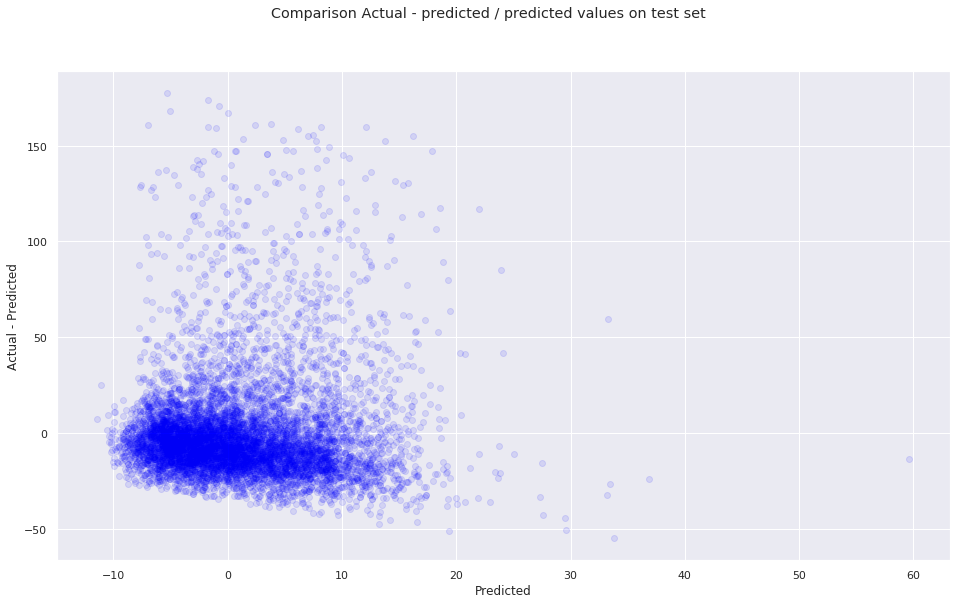

In [66]:
#if (EXECUTE_INTERMEDIATE_MODELS == True):
fig = plt.figure()
fig.suptitle('Comparison Actual - predicted / predicted values on test set')
plt.xlabel("Predicted")
plt.ylabel("Actual - Predicted")
plt.scatter(df_test_predictions, df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

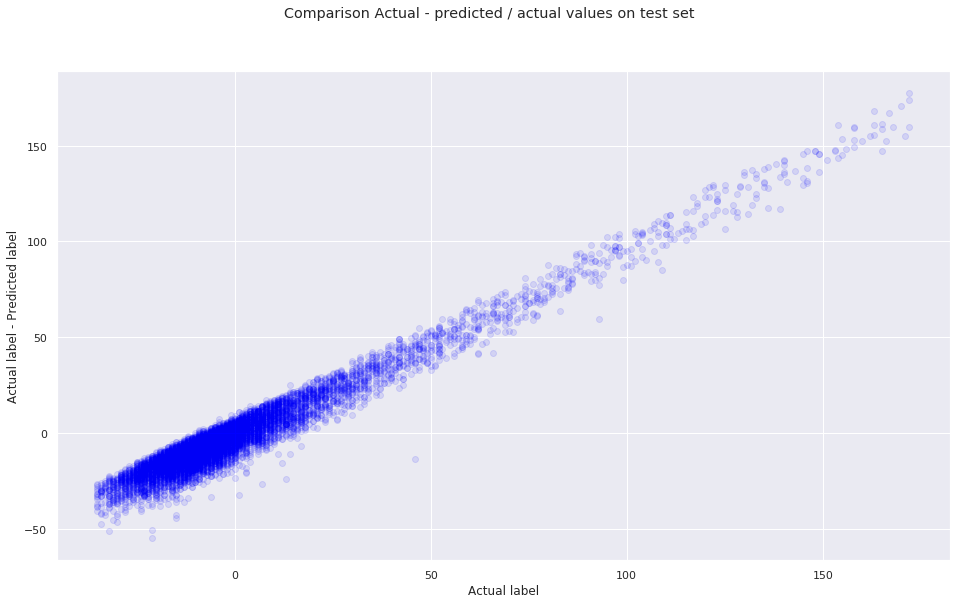

In [67]:
#if (EXECUTE_INTERMEDIATE_MODELS == True):
fig = plt.figure()
fig.suptitle('Comparison Actual - predicted / actual values on test set')
plt.xlabel("Actual label")
plt.ylabel("Actual label - Predicted label")
plt.scatter(df_test[model1_label], df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

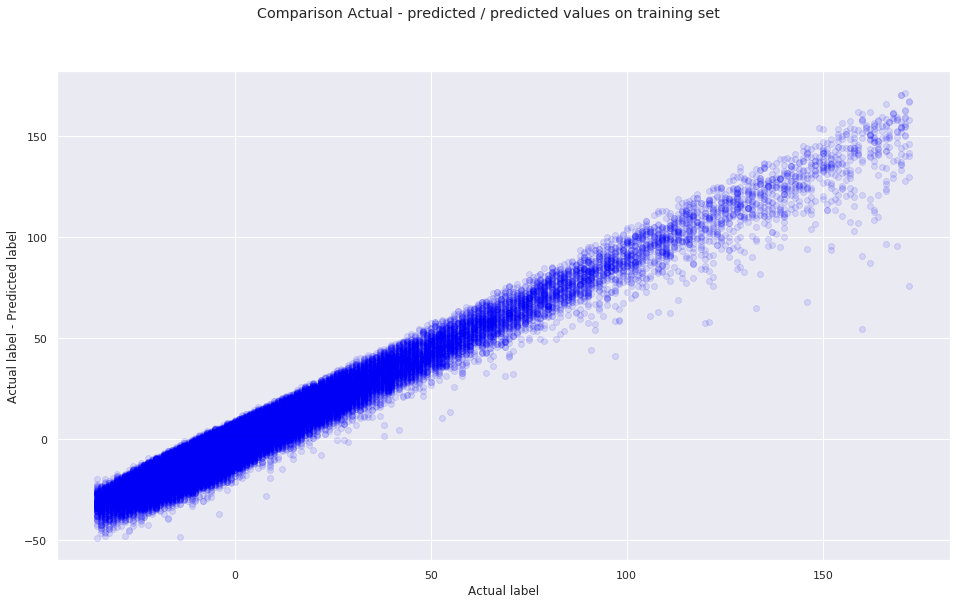

In [68]:
#if (EXECUTE_INTERMEDIATE_MODELS == True):
fig = plt.figure()
fig.suptitle('Comparison Actual - predicted / predicted values on training set')
plt.xlabel("Actual label")
plt.ylabel("Actual label - Predicted label")
plt.scatter(df_train[model1_label], df_train[model1_label] - df_train_predictions, color='blue', alpha=0.1)

In [72]:
df_train_residuals = df_train[model1_label] - df_train_predictions
max_residual = df_train_residuals.abs().max()
sample_weights = (max_residual - df_train_residuals.abs()) / max_residual

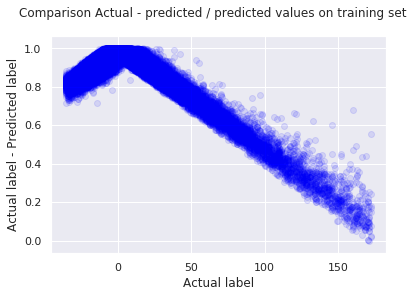

In [73]:
#if (EXECUTE_INTERMEDIATE_MODELS == True):
fig = plt.figure()
fig.suptitle('Comparison Actual - predicted / predicted values on training set')
plt.xlabel("Actual label")
plt.ylabel("Actual label - Predicted label")
plt.scatter(df_train[model1_label],sample_weights, color='blue', alpha=0.1)

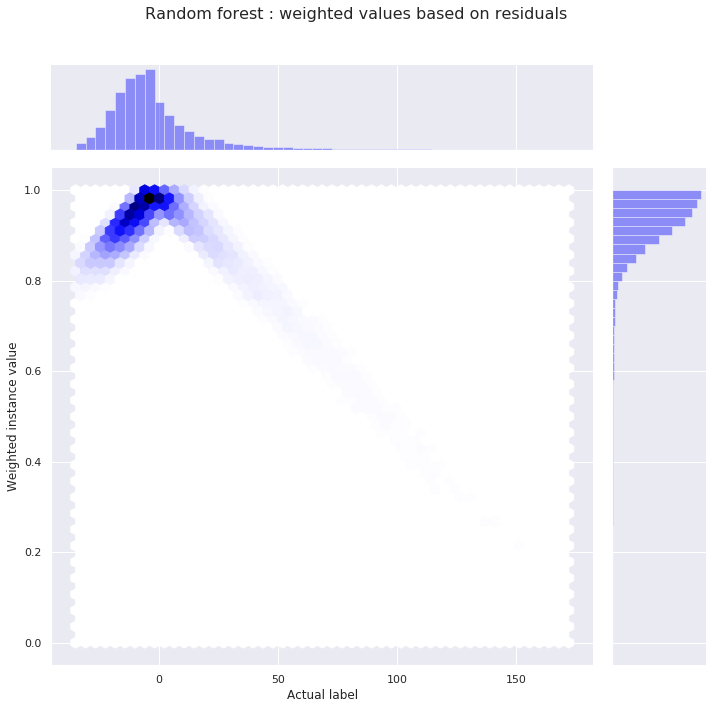

In [74]:
#if (EXECUTE_INTERMEDIATE_MODELS == True):

g = sns.jointplot(x=df_train[model1_label], y=sample_weights, kind='hex', color='blue', height=10)
#sns.jointplot(x=df_test[model1_label], y=df_test_predictions, alpha=0.01)

g.set_axis_labels("Actual label", "Weighted instance value")
plt.subplots_adjust(top=0.9)
plt.suptitle('Random forest : weighted values based on residuals', fontsize = 16)

plt.savefig('linreg_residuals_weighted_training_set.png', dpi=400)


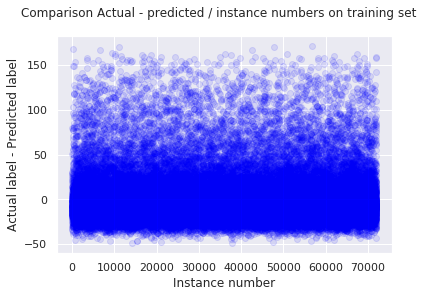

In [75]:
#if (EXECUTE_INTERMEDIATE_MODELS == True):
fig = plt.figure()
fig.suptitle('Comparison Actual - predicted / instance numbers on training set')
plt.xlabel("Instance number")
plt.ylabel("Actual label - Predicted label")
plt.scatter(range(df_train.shape[0]), df_train[model1_label] - df_train_predictions, color='blue', alpha=0.1)

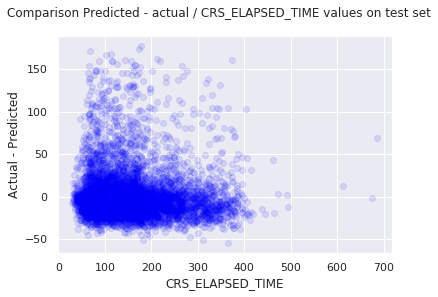

In [76]:
#if (EXECUTE_INTERMEDIATE_MODELS == True):
fig = plt.figure()
fig.suptitle('Comparison Predicted - actual / CRS_ELAPSED_TIME values on test set')
plt.xlabel("CRS_ELAPSED_TIME")
plt.ylabel("Actual - Predicted")
plt.scatter(df_test['CRS_ELAPSED_TIME'], df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

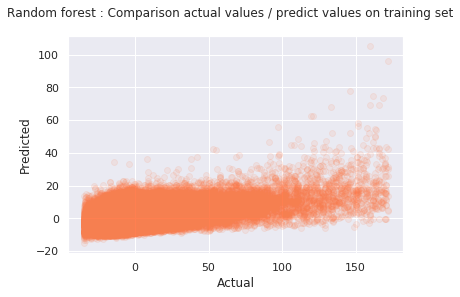

In [77]:
df_train_predictions = random_reg.predict(df_train_transformed)

#if (EXECUTE_INTERMEDIATE_MODELS == True):
fig = plt.figure()
fig.suptitle('Random forest : Comparison actual values / predict values on training set')
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.scatter(df_train[model1_label], df_train_predictions, color='coral', alpha=0.1)

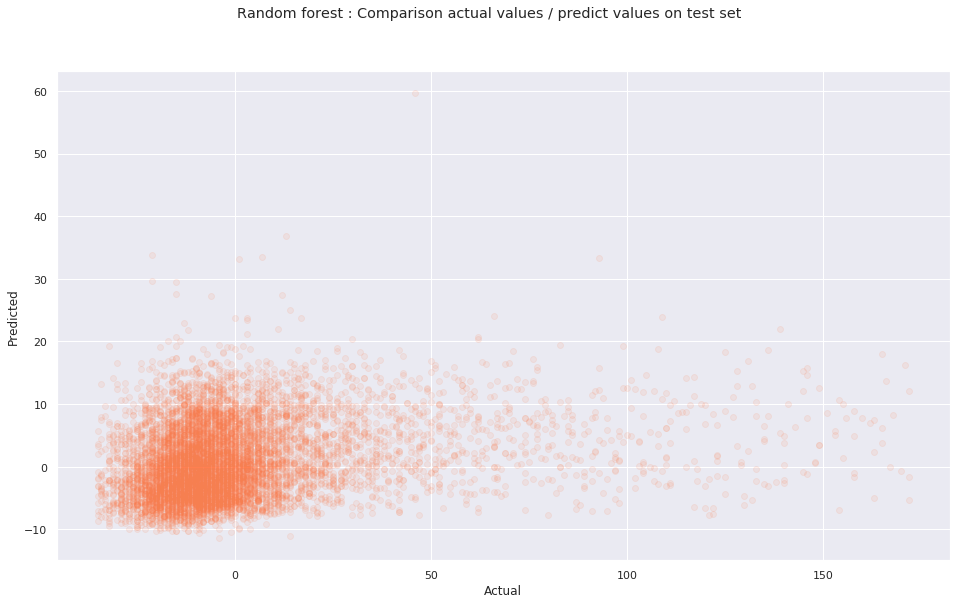

In [75]:
df_test_predictions = random_reg.predict(df_test_transformed)

#if (EXECUTE_INTERMEDIATE_MODELS == True):
fig = plt.figure()
fig.suptitle('Random forest : Comparison actual values / predict values on test set')
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.scatter(df_test[model1_label], df_test_predictions, color='coral', alpha=0.1)

In [76]:
df_train_transformed.columns

Index(['CRS_ARR_TIME', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DAY_OF_MONTH',
       'DAY_OF_WEEK', 'DEST', 'DISTANCE', 'MONTH',
       'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT',
       'ORIGIN', 'UNIQUE_CARRIER'],
      dtype='object')

In [77]:
pd.set_option('display.max_rows', 200)

In [78]:
df_feature_importances = pd.DataFrame(data = {'Feature name' : df_train_transformed.columns, 'Feature importance' : random_reg.feature_importances_})

In [79]:
df_feature_importances_global = pd.concat([df_feature_importances.sort_values(by='Feature importance', ascending=False), \
           df_feature_importances[['Feature importance']].rename(columns={'Feature importance' : 'Cumulated feature importance'}).sort_values(by='Cumulated feature importance', ascending=False).cumsum()], axis=1)

In [80]:
#df.style.set_properties(**{'text-align': 'center'})

df_feature_importances_global.style.format({
    'Feature importance': '{:,.2%}'.format,
    'Cumulated feature importance': '{:,.2%}'.format,
})

In [81]:
random_reg.feature_importances_

array([0.13080813, 0.15294577, 0.07356689, 0.06269881, 0.035939  ,
       0.11540984, 0.06211926, 0.0753029 , 0.05532887, 0.0845967 ,
       0.08420727, 0.06707655])

In [82]:
random_reg.feature_importances_.cumsum()

array([0.13080813, 0.28375391, 0.3573208 , 0.42001961, 0.45595861,
       0.57136845, 0.63348771, 0.70879061, 0.76411948, 0.84871619,
       0.93292345, 1.        ])

=> feature importance : 

In [83]:
random_reg.estimators_[0]

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=4,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=1608637542, splitter='best')

In [84]:
'''
from sklearn.tree import export_graphviz
export_graphviz(random_reg.estimators_[0], out_file="tree.dot", rounded=True, filled=True)
'''

'\nfrom sklearn.tree import export_graphviz\nexport_graphviz(random_reg.estimators_[0], out_file="tree.dot", rounded=True, filled=True)\n'

In [85]:
LEARNING_CURVE_STEP_SIZE

8000

Calculating learning curve for 10 iterations


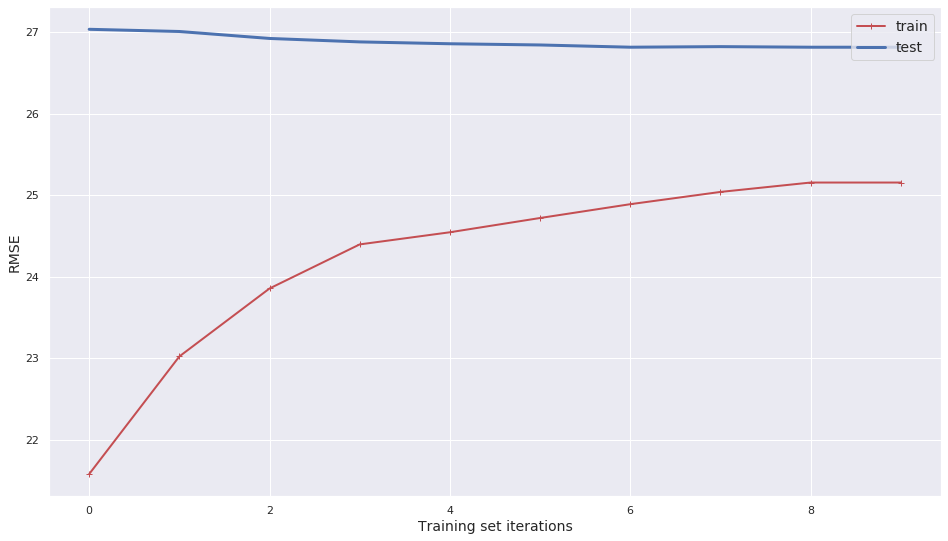

In [86]:
#if (EXECUTE_INTERMEDIATE_MODELS == True):
#df_test_predictions = random_reg.predict(df_test_transformed)
#evaluate_model(random_reg, df_test_transformed, df_test[model1_label])
plot_learning_curves(random_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], int(LEARNING_CURVE_STEP_SIZE))

## Boosting

In [215]:
from sklearn.ensemble import GradientBoostingRegressor

boost_reg = GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=10, subsample=0.1, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=10, init=None, random_state=42, max_features=4, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False)

boost_reg.fit(df_train_transformed, df_train[model1_label])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=10,
                          max_features=4, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=10,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=0.1, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [216]:
print("Evaluation on test set :")
evaluate_model(boost_reg, df_test_transformed, df_test[model1_label])

print('\n')

print("Evaluation on training set :")
evaluate_model(boost_reg, df_train_transformed, df_train[model1_label])

Evaluation on test set :
RMSE : 27.328265560941315


Evaluation on training set :
RMSE : 26.54444646873024


In [217]:
error_mean = evaluate_model_percent_mean(boost_reg, df_test_transformed, df_test[model1_label], 0.8)
print(f'Mean prediction error {EVALUATION_PERCENT*100}% of the time : {error_mean : .2f}')

Mean prediction error 90.0% of the time :  10.20


With boosting, all data :  
Mean prediction error 90.0% of the time :  9.88

In [218]:
df_test_predictions = boost_reg.predict(df_test_transformed)

In [219]:
df_train_predictions = boost_reg.predict(df_train_transformed)

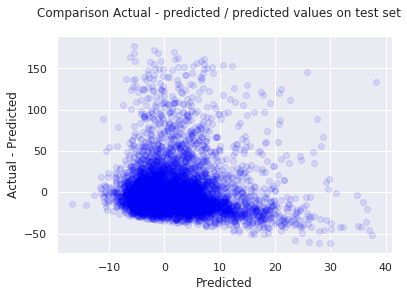

In [220]:
#if (EXECUTE_INTERMEDIATE_MODELS == True):
fig = plt.figure()
fig.suptitle('Comparison Actual - predicted / predicted values on test set')
plt.xlabel("Predicted")
plt.ylabel("Actual - Predicted")
plt.scatter(df_test_predictions, df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

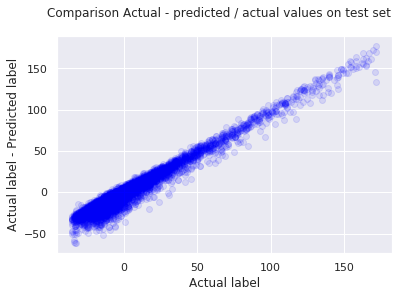

In [221]:
#if (EXECUTE_INTERMEDIATE_MODELS == True):
fig = plt.figure()
fig.suptitle('Comparison Actual - predicted / actual values on test set')
plt.xlabel("Actual label")
plt.ylabel("Actual label - Predicted label")
plt.scatter(df_test[model1_label], df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

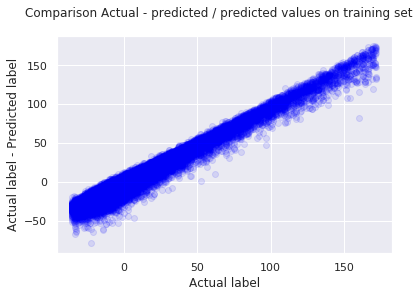

In [222]:
#if (EXECUTE_INTERMEDIATE_MODELS == True):
fig = plt.figure()
fig.suptitle('Comparison Actual - predicted / predicted values on training set')
plt.xlabel("Actual label")
plt.ylabel("Actual label - Predicted label")
plt.scatter(df_train[model1_label], df_train[model1_label] - df_train_predictions, color='blue', alpha=0.1)

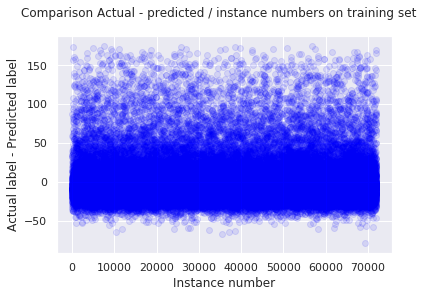

In [223]:
#if (EXECUTE_INTERMEDIATE_MODELS == True):
fig = plt.figure()
fig.suptitle('Comparison Actual - predicted / instance numbers on training set')
plt.xlabel("Instance number")
plt.ylabel("Actual label - Predicted label")
plt.scatter(range(df_train.shape[0]), df_train[model1_label] - df_train_predictions, color='blue', alpha=0.1)

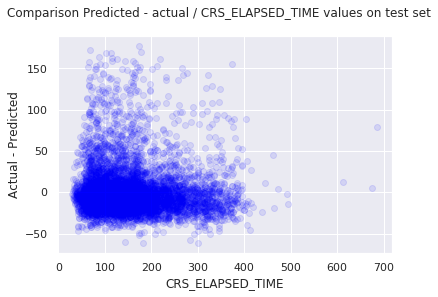

In [224]:
#if (EXECUTE_INTERMEDIATE_MODELS == True):
fig = plt.figure()
fig.suptitle('Comparison Predicted - actual / CRS_ELAPSED_TIME values on test set')
plt.xlabel("CRS_ELAPSED_TIME")
plt.ylabel("Actual - Predicted")
plt.scatter(df_test['CRS_ELAPSED_TIME'], df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

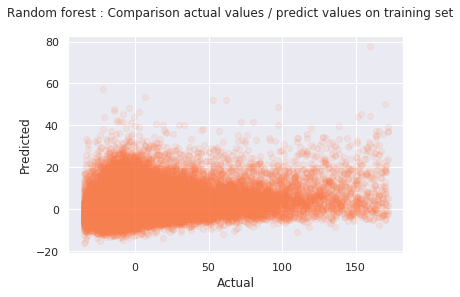

In [225]:
df_train_predictions = boost_reg.predict(df_train_transformed)

#if (EXECUTE_INTERMEDIATE_MODELS == True):
fig = plt.figure()
fig.suptitle('Random forest : Comparison actual values / predict values on training set')
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.scatter(df_train[model1_label], df_train_predictions, color='coral', alpha=0.1)

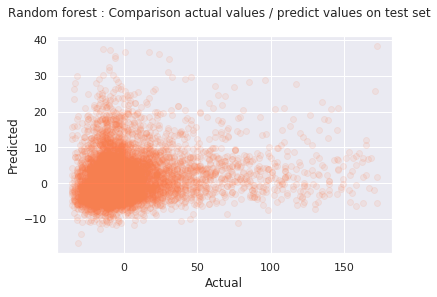

In [226]:
df_test_predictions = boost_reg.predict(df_test_transformed)

#if (EXECUTE_INTERMEDIATE_MODELS == True):
fig = plt.figure()
fig.suptitle('Random forest : Comparison actual values / predict values on test set')
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.scatter(df_test[model1_label], df_test_predictions, color='coral', alpha=0.1)

In [227]:
df_train_transformed.columns

Index(['CRS_ARR_TIME', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DAY_OF_MONTH',
       'DAY_OF_WEEK', 'DEST', 'DISTANCE', 'MONTH',
       'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT',
       'ORIGIN', 'UNIQUE_CARRIER'],
      dtype='object')

In [228]:
pd.set_option('display.max_rows', 200)

In [229]:
df_feature_importances = pd.DataFrame(data = {'Feature name' : df_train_transformed.columns, 'Feature importance' : boost_reg.feature_importances_})

In [230]:
pd.concat([df_feature_importances.sort_values(by='Feature importance', ascending=False), \
           df_feature_importances[['Feature importance']].sort_values(by='Feature importance', ascending=False).cumsum()], axis=1)

Feature name  Feature importance  Feature importance
0                      CRS_ARR_TIME            0.122925            0.122925
1                      CRS_DEP_TIME            0.111584            0.234508
6                          DISTANCE            0.107047            0.341555
5                              DEST            0.096417            0.437972
2                  CRS_ELAPSED_TIME            0.095941            0.533913
9       NBFLIGHTS_FORDAY_FORAIRPORT            0.093659            0.627572
3                      DAY_OF_MONTH            0.080889            0.708461
10                           ORIGIN            0.073641            0.782103
8   NBFLIGHTS_FORDAYHOUR_FORAIRPORT            0.067795            0.849898
7                             MONTH            0.061273            0.911171
11                   UNIQUE_CARRIER            0.052416            0.963588
4                       DAY_OF_WEEK            0.036412            1.000000

## Random forest with weighted optimisation (suppress training instances)

In [78]:
WEIGHT_THRESHOLD = 0.8
df_train_transformed = df_train_transformed[sample_weights > WEIGHT_THRESHOLD]

In [79]:
df_train = df_train[sample_weights > WEIGHT_THRESHOLD]

In [80]:
sample_weights_haircut = sample_weights[sample_weights > WEIGHT_THRESHOLD]

In [81]:
%%time
from sklearn.ensemble import RandomForestRegressor

#if (EXECUTE_INTERMEDIATE_MODELS == True):
random_reg = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                  max_features=4, max_leaf_nodes=None,
                  min_impurity_decrease=0.0, min_impurity_split=None,
                  min_samples_leaf=1, min_samples_split=2,
                  min_weight_fraction_leaf=0.0, n_estimators=1000,
                  n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                  warm_start=False)
random_reg.fit(df_train_transformed, df_train[model1_label], sample_weights_haircut)

CPU times: user 2min 42s, sys: 549 ms, total: 2min 43s
Wall time: 25.8 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [82]:
print("Evaluation on test set :")
evaluate_model(random_reg, df_test_transformed, df_test[model1_label])

print('\n')

print("Evaluation on training set :")
evaluate_model(random_reg, df_train_transformed, df_train[model1_label])

Evaluation on test set :
RMSE : 27.692197231070587


Evaluation on training set :
RMSE : 12.758187499942364


With weight threshold of 0.7 :  
Evaluation on test set :  
RMSE : 27.505904323162397  


Evaluation on training set :  
RMSE : 15.105634267719225  

With weight threshold of 0.9 :  
Evaluation on test set :  
RMSE : 27.34542651549861  


Evaluation on training set :  
RMSE : 8.161417508179818  

With weight threshold of 0.8 :  
Evaluation on test set :  
RMSE : 27.691875273334873  


Evaluation on training set :  
RMSE : 12.758479277575331  

In [83]:
error_mean = evaluate_model_percent_mean(random_reg, df_test_transformed, df_test[model1_label], 0.8)
print(f'Mean prediction error {EVALUATION_PERCENT*100}% of the time : {error_mean : .2f}')

Mean prediction error 90.0% of the time :  7.90


=> ~ 10 min with 80000 lines  
=> 9.75 min with 800000 lines

With sample weight optimisation : 
Mean prediction error 90.0% of the time :  9.02

With weight threshold of 0.7 :  
Mean prediction error 90.0% of the time :  8.13    

With weight threshold of 0.9 :  
Mean prediction error 90.0% of the time :  8.35  

With weight threshold of 0.8 :  
Mean prediction error 90.0% of the time :  7.90

In [84]:
error_mean_worst = evaluate_model_percent_worst_mean(random_reg, df_test_transformed, df_test[model1_label], 0.8)
print(f'Mean prediction error {100 - (EVALUATION_PERCENT)*100}% of the time : {error_mean_worst : .2f}')

Mean prediction error 10.0% of the time :  48.03


In [85]:
df_test_predictions = random_reg.predict(df_test_transformed)

In [86]:
df_train_predictions = random_reg.predict(df_train_transformed)

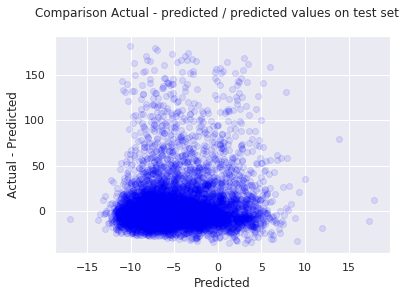

In [87]:
#if (EXECUTE_INTERMEDIATE_MODELS == True):
fig = plt.figure()
fig.suptitle('Comparison Actual - predicted / predicted values on test set')
plt.xlabel("Predicted")
plt.ylabel("Actual - Predicted")
plt.scatter(df_test_predictions, df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

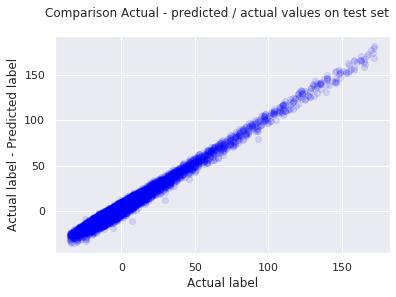

In [88]:
#if (EXECUTE_INTERMEDIATE_MODELS == True):
fig = plt.figure()
fig.suptitle('Comparison Actual - predicted / actual values on test set')
plt.xlabel("Actual label")
plt.ylabel("Actual label - Predicted label")
plt.scatter(df_test[model1_label], df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

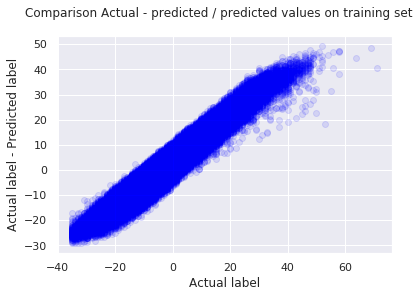

In [89]:
#if (EXECUTE_INTERMEDIATE_MODELS == True):
fig = plt.figure()
fig.suptitle('Comparison Actual - predicted / predicted values on training set')
plt.xlabel("Actual label")
plt.ylabel("Actual label - Predicted label")
plt.scatter(df_train[model1_label], df_train[model1_label] - df_train_predictions, color='blue', alpha=0.1)

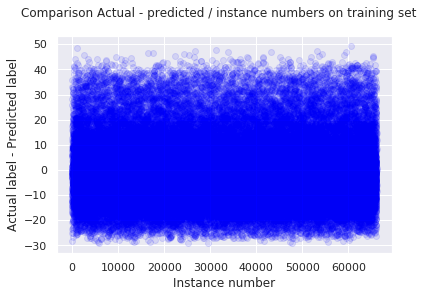

In [90]:
#if (EXECUTE_INTERMEDIATE_MODELS == True):
fig = plt.figure()
fig.suptitle('Comparison Actual - predicted / instance numbers on training set')
plt.xlabel("Instance number")
plt.ylabel("Actual label - Predicted label")
plt.scatter(range(df_train.shape[0]), df_train[model1_label] - df_train_predictions, color='blue', alpha=0.1)

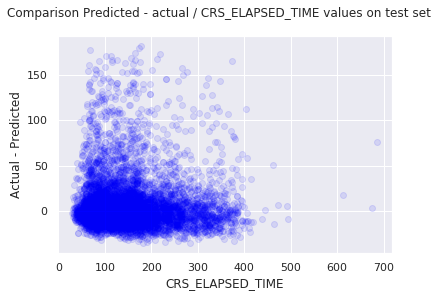

In [91]:
#if (EXECUTE_INTERMEDIATE_MODELS == True):
fig = plt.figure()
fig.suptitle('Comparison Predicted - actual / CRS_ELAPSED_TIME values on test set')
plt.xlabel("CRS_ELAPSED_TIME")
plt.ylabel("Actual - Predicted")
plt.scatter(df_test['CRS_ELAPSED_TIME'], df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

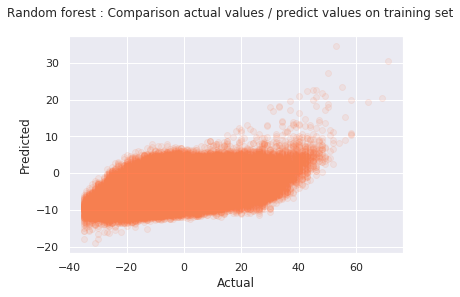

In [92]:
df_train_predictions = random_reg.predict(df_train_transformed)

#if (EXECUTE_INTERMEDIATE_MODELS == True):
fig = plt.figure()
fig.suptitle('Random forest : Comparison actual values / predict values on training set')
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.scatter(df_train[model1_label], df_train_predictions, color='coral', alpha=0.1)

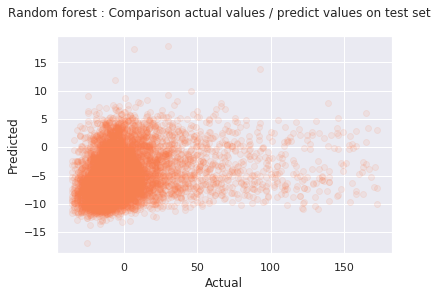

In [93]:
df_test_predictions = random_reg.predict(df_test_transformed)

#if (EXECUTE_INTERMEDIATE_MODELS == True):
fig = plt.figure()
fig.suptitle('Random forest : Comparison actual values / predict values on test set')
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.scatter(df_test[model1_label], df_test_predictions, color='coral', alpha=0.1)

In [94]:
df_train_transformed.columns

Index(['CRS_ARR_TIME', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DAY_OF_MONTH',
       'DAY_OF_WEEK', 'DEST', 'DISTANCE', 'MONTH',
       'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT',
       'ORIGIN', 'UNIQUE_CARRIER'],
      dtype='object')

In [95]:
pd.set_option('display.max_rows', 50)

In [96]:
df_feature_importances = pd.DataFrame(data = {'Feature name' : df_train_transformed.columns, 'Feature importance' : random_reg.feature_importances_})

In [97]:
pd.concat([df_feature_importances.sort_values(by='Feature importance', ascending=False), \
           df_feature_importances[['Feature importance']].sort_values(by='Feature importance', ascending=False).cumsum()], axis=1)

Feature name  Feature importance  Feature importance
11                   UNIQUE_CARRIER            0.148611            0.148611
1                      CRS_DEP_TIME            0.139060            0.287671
5                              DEST            0.113366            0.401037
0                      CRS_ARR_TIME            0.110602            0.511639
10                           ORIGIN            0.095210            0.606849
2                  CRS_ELAPSED_TIME            0.083661            0.690510
9       NBFLIGHTS_FORDAY_FORAIRPORT            0.073982            0.764492
7                             MONTH            0.062723            0.827215
6                          DISTANCE            0.058202            0.885418
8   NBFLIGHTS_FORDAYHOUR_FORAIRPORT            0.046874            0.932291
3                      DAY_OF_MONTH            0.042299            0.974591
4                       DAY_OF_WEEK            0.025409            1.000000

Tests

# Save API model files for user interface

In [98]:
if (SAVE_API_MODEL == True):    
    API_model = {}
    API_model['dataprep'] = preparation_pipeline_meansort_stdscale
    API_model['prediction'] = random_reg
    
    with open(API_MODEL_PICKLE_FILE, 'wb') as f:
        pickle.dump(API_model, f, pickle.HIGHEST_PROTOCOL)        

## Printing values to test the API

In [99]:
realdf_test_predictions = pd.DataFrame(df_test_predictions, columns=['Predicted ARR delay'])

In [100]:
realdf_test_predictions_with_label = pd.concat([df_test.reset_index(), realdf_test_predictions.reset_index()], axis=1)

In [106]:
realdf_test_predictions_with_label[realdf_test_predictions_with_label['Predicted ARR delay'] > 17]

index  ORIGIN  CRS_DEP_TIME  MONTH  DAY_OF_MONTH  DAY_OF_WEEK  \
2373  4219443     300          1030     10             4            2   
6143  3796674     258          1159      1             5            2   

      UNIQUE_CARRIER  DEST  CRS_ARR_TIME  DISTANCE  CRS_ELAPSED_TIME  \
2373               5   156          1140     561.0             110.0   
6143               9   270          1319    1035.0             160.0   

      ARR_DELAY  DEP_DELAY  TAXI_OUT TAIL_NUM  NBFLIGHTS_FORDAY_FORAIRPORT  \
2373       30.0       34.0       7.0   N908EV                            2   
6143        7.0       20.0      15.0   N547JB                           78   

      NBFLIGHTS_FORDAYHOUR_FORAIRPORT  index  Predicted ARR delay  
2373                                1   2373            17.926068  
6143                                5   6143            17.337069

In [102]:
df.dtypes

ORIGIN                              object
CRS_DEP_TIME                        object
MONTH                                int64
DAY_OF_MONTH                         int64
DAY_OF_WEEK                          int64
UNIQUE_CARRIER                      object
DEST                                object
CRS_ARR_TIME                        object
DISTANCE                           float64
CRS_ELAPSED_TIME                   float64
ARR_DELAY                          float64
DEP_DELAY                          float64
TAXI_OUT                           float64
TAIL_NUM                            object
NBFLIGHTS_FORDAY_FORAIRPORT          int64
NBFLIGHTS_FORDAYHOUR_FORAIRPORT      int64
dtype: object

In [103]:
df_train.dtypes

ORIGIN                               int64
CRS_DEP_TIME                         int64
MONTH                                int64
DAY_OF_MONTH                         int64
DAY_OF_WEEK                          int64
UNIQUE_CARRIER                       int64
DEST                                 int64
CRS_ARR_TIME                         int64
DISTANCE                           float64
CRS_ELAPSED_TIME                   float64
ARR_DELAY                          float64
DEP_DELAY                          float64
TAXI_OUT                           float64
TAIL_NUM                            object
NBFLIGHTS_FORDAY_FORAIRPORT          int64
NBFLIGHTS_FORDAYHOUR_FORAIRPORT      int64
dtype: object

In [104]:
df_test_predictions.max()

17.926067893361168

In [105]:
df.loc[1876726, :]

ORIGIN                                FLL
CRS_DEP_TIME                         2020
MONTH                                   5
DAY_OF_MONTH                           19
DAY_OF_WEEK                             4
UNIQUE_CARRIER                         B6
DEST                                  SWF
CRS_ARR_TIME                         2322
DISTANCE                             1118
CRS_ELAPSED_TIME                      182
ARR_DELAY                              46
DEP_DELAY                              68
TAXI_OUT                                9
TAIL_NUM                           N373JB
NBFLIGHTS_FORDAY_FORAIRPORT           222
NBFLIGHTS_FORDAYHOUR_FORAIRPORT        18
Name: 1876726, dtype: object

In [68]:
df_test_transformed.loc[1876726, :]

CRS_ARR_TIME                       1.597562
CRS_DEP_TIME                       1.392874
CRS_ELAPSED_TIME                   0.501140
DAY_OF_MONTH                       0.365083
DAY_OF_WEEK                        0.030554
DEST                               2.237385
DISTANCE                           0.450558
MONTH                             -0.443947
NBFLIGHTS_FORDAYHOUR_FORAIRPORT   -0.216493
NBFLIGHTS_FORDAY_FORAIRPORT       -0.400488
ORIGIN                             1.191638
UNIQUE_CARRIER                     1.234246
Name: 1876726, dtype: float64

In [180]:
df.loc[2494819, :]

ORIGIN                                OAK
CRS_DEP_TIME                         1450
MONTH                                   3
DAY_OF_MONTH                            8
DAY_OF_WEEK                             2
UNIQUE_CARRIER                         WN
DEST                                  SAN
CRS_ARR_TIME                         1610
DISTANCE                              446
CRS_ELAPSED_TIME                       80
ARR_DELAY                               9
DEP_DELAY                              13
TAXI_OUT                                8
TAIL_NUM                           N272WN
NBFLIGHTS_FORDAY_FORAIRPORT           132
NBFLIGHTS_FORDAYHOUR_FORAIRPORT         8
Name: 2494819, dtype: object

## Polynomial regression degree 3

In [251]:
poly = PolynomialFeatures(degree=3)
poly.fit(df_train_transformed)
df_train_transformed = poly.transform(df_train_transformed)
df_test_transformed = poly.transform(df_test_transformed)

In [252]:
poly.n_output_features_

455

In [253]:
df_train_transformed.shape

(66143, 455)

In [254]:
#if (EXECUTE_INTERMEDIATE_MODELS == True):
lin_reg = LinearRegression()
lin_reg.fit(df_train_transformed, df_train[model1_label])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [255]:
#if (EXECUTE_INTERMEDIATE_MODELS == True):
evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])

RMSE : 27.783259456735326


=> RMSE on test set with outliers : RMSE : 42.12678182212536  
=> RMSE on test set 80000 instances degree 2 :26.962742760959262  
=> RMSE on test set 80000 instances degree 3: 26.973373855188367

In [256]:
evaluate_model(lin_reg, df_train_transformed, df_train[model1_label])

RMSE : 13.33622849409909


=> RMSE on training set with outliers : 41.26055791264713  
=> RMSE on training set 80000 instances degree 2 : 26.962742760959262
=> RMSE on trainings et with 80000 instances degree 3 :  RMSE : 26.64926940350148

In [257]:
print('\n')

error_mean = evaluate_model_percent_mean(lin_reg, df_train_transformed, df_train[model1_label], 0.8)
print(f'Mean prediction error {EVALUATION_PERCENT*100}% of the time : {error_mean : .2f}')



Mean prediction error 90.0% of the time :  6.96


In [258]:
print('\n')

error_mean_test = evaluate_model_percent_mean(lin_reg, df_test_transformed, df_test[model1_label], 0.8)
print(f'Mean prediction error {EVALUATION_PERCENT*100}% of the time : {error_mean_test: .2f}')



Mean prediction error 90.0% of the time :  7.90


Calculating learning curve for 9 iterations


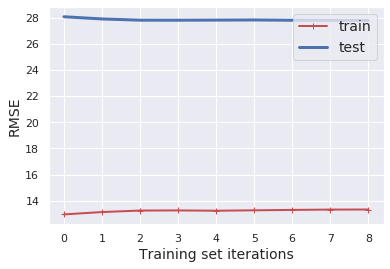

In [259]:
plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE)

In [260]:
# Feature importances :
(abs(lin_reg.coef_) / (abs(lin_reg.coef_).sum()))

array([1.16248128e-16, 4.33516412e-03, 1.03215881e-02, 3.91337635e-02,
       4.86657298e-04, 1.07853841e-03, 9.52587220e-04, 3.90891328e-02,
       2.80098182e-04, 7.03318499e-04, 7.92719991e-04, 1.18454168e-03,
       5.89569032e-03, 6.43887033e-03, 1.54943959e-02, 2.45098974e-02,
       7.67419797e-04, 3.04547432e-04, 2.24262850e-03, 1.96517463e-02,
       4.12438337e-03, 3.19215326e-04, 1.22353587e-03, 4.72701052e-05,
       2.36839044e-03, 9.21157492e-03, 2.11569986e-02, 5.55073756e-04,
       2.40534701e-05, 3.21817688e-03, 1.61968353e-02, 3.99241866e-03,
       9.94716138e-04, 6.03383843e-05, 5.14686927e-04, 6.10163779e-05,
       2.94695740e-02, 2.39011629e-04, 6.45251129e-04, 6.91866262e-04,
       5.76367709e-02, 6.16639812e-04, 1.49338555e-03, 2.33999169e-03,
       9.09760816e-04, 4.66437990e-04, 5.97558573e-04, 3.39448627e-05,
       3.31508596e-04, 4.80516621e-04, 6.78841643e-04, 4.20007817e-04,
       6.28995241e-04, 2.13011676e-04, 1.05041221e-04, 7.93447585e-04,
      

In [261]:
df_train_transformed[:,0].shape

(66143,)

In [262]:
df_train_predictions =  lin_reg.predict(df_train_transformed)
df_test_predictions =  lin_reg.predict(df_test_transformed)

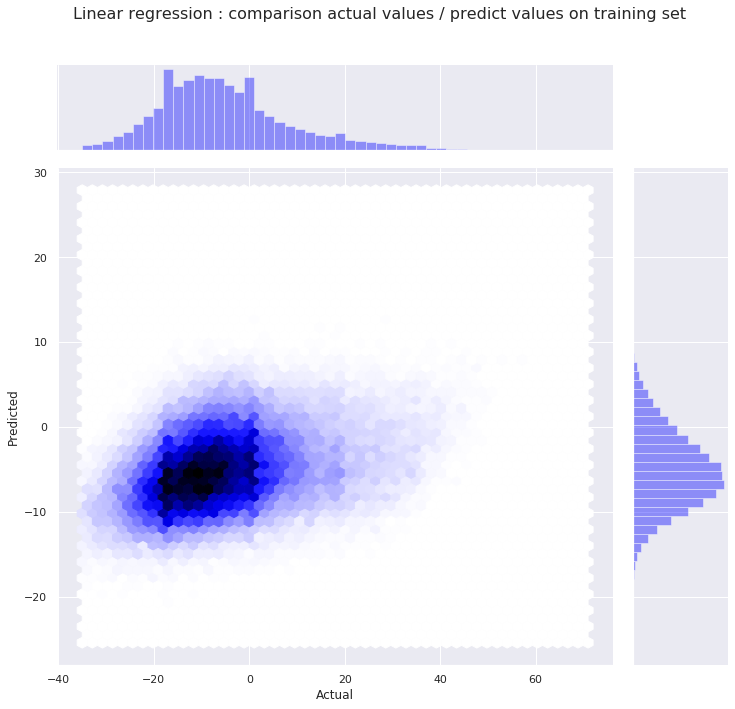

In [263]:
#if (EXECUTE_INTERMEDIATE_MODELS == True):

g = sns.jointplot(x=df_train[model1_label], y=df_train_predictions, kind='hex', color='blue', height=10)
#sns.jointplot(x=df_test[model1_label], y=df_test_predictions, alpha=0.01)

g.set_axis_labels("Actual", "Predicted")
plt.subplots_adjust(top=0.9)
plt.suptitle('Linear regression : comparison actual values / predict values on training set', fontsize = 16)

plt.savefig('linreg_actual_vs_predicted_training_set.png', dpi=400)


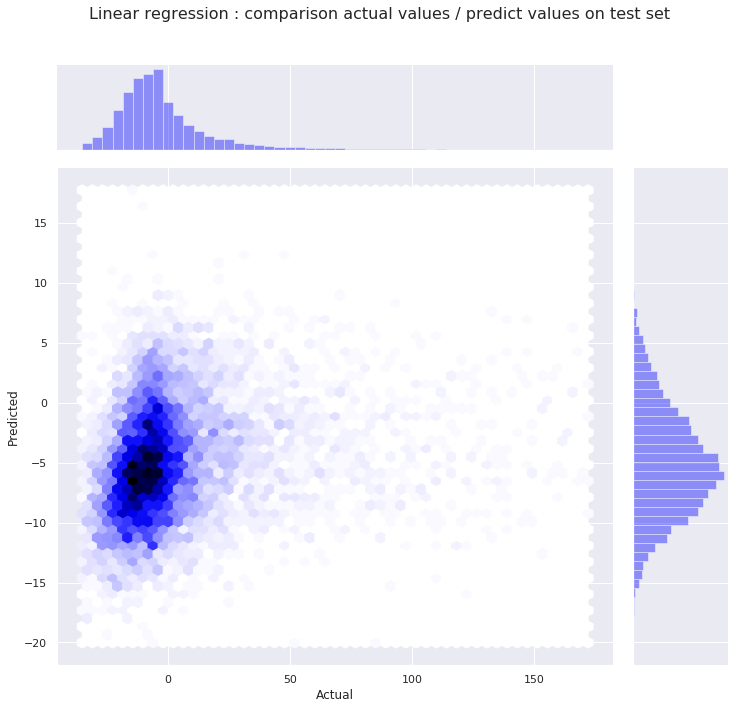

In [264]:
#if (EXECUTE_INTERMEDIATE_MODELS == True):

g = sns.jointplot(x=df_test[model1_label], y=df_test_predictions, kind='hex', color='blue', height=10)
#sns.jointplot(x=df_test[model1_label], y=df_test_predictions, alpha=0.01)

g.set_axis_labels("Actual", "Predicted")
plt.subplots_adjust(top=0.9)
plt.suptitle('Linear regression : comparison actual values / predict values on test set', fontsize = 16)

plt.savefig('linreg_actual_vs_predicted_test_set.png', dpi=400)


## Polynomial regression univariate, and higher degree

### Degree 8

In [267]:
if (DATA_LOADED == True):
    del df
    del df_train
    del df_test
    del df_train_transformed
    del df_test_transformed

NameError: name 'df' is not defined

In [24]:
df = load_data()

In [25]:
all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)

Quantitative features : ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT'] 

Qualitative features : ['ORIGIN', 'CRS_DEP_TIME', 'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'TAIL_NUM'] 



In [26]:
df, df_train, df_test = custom_train_test_split_sample(df)

In [27]:
df_train_transformed = preparation_pipeline_meansort.fit_transform(df_train, categoricalfeatures_1hotencoder__categorical_features_totransform=None)
df_train_transformed = prediction_pipeline_without_sparse.fit_transform(df_train_transformed)

df_test_transformed = preparation_pipeline_meansort.transform(df_test)
df_test_transformed = prediction_pipeline_without_sparse.transform(df_test_transformed)
DATA_LOADED = True
df_test_transformed.shape

Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Fit data
Fitting feature ORIGIN
Fitting feature UNIQUE_CARRIER
Fitting feature DEST
Encode categorical features...
Encoding feature ORIGIN ...
Encoding feature UNIQUE_CARRIER ...
Encoding feature DEST ...
Fit data
!! categorical_features_totransformNone
Features selected (in order): Index(['CRS_ARR_TIME', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DAY_OF_MONTH',
       'DAY_OF_WEEK', 'DEST', 'DISTANCE', 'MONTH',
       'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT',
       'ORIGIN', 'UNIQUE_CARRIER'],
      dtype='object')
Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Encode categorical features...
Encoding feature ORIGIN ...
Encoding feature UNIQUE_CARRIER ...
Encoding feature DEST ...
Features selected (in order): Index(['CRS_ARR_TIME', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DAY_OF_MONTH',
       'DAY_OF_WEEK', 'DEST', 'DISTANCE', 'MONTH',
       'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGH

(8000, 12)

In [28]:
nb_instances = df_train_transformed.shape[0]

In [29]:
poly = PolynomialFeaturesUnivariateAdder(n_degrees = 8)

In [30]:
df_train_transformed = poly.fit_transform(df_train_transformed)
df_test_transformed = poly.fit_transform(df_test_transformed)

Adding polynomial features


Adding polynomial features


In [31]:
lin_reg = LinearRegression()

lin_reg.fit(df_train_transformed, df_train[model1_label])

df_test_predictions = lin_reg.predict(df_test_transformed)

print("Evaluation on test set :")
evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])

print('\n')

print("Evaluation on training set :")
evaluate_model(lin_reg, df_train_transformed, df_train[model1_label])

Evaluation on test set :
RMSE : 27.48859422660007


Evaluation on training set :
RMSE : 27.238297695625977


Calculating learning curve for 10 iterations



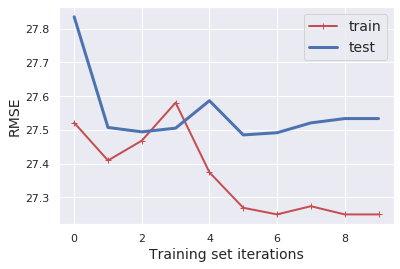

In [32]:
plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE)

### Degree 4

In [33]:
del df
del df_train
del df_test
del df_train_transformed
del df_test_transformed

In [34]:
df, df_train, df_test, df_train_transformed, df_test_transformed = reset_data()

Quantitative features : ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT'] 

Qualitative features : ['ORIGIN', 'CRS_DEP_TIME', 'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'TAIL_NUM'] 

Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Fit data
Fitting feature ORIGIN
Fitting feature UNIQUE_CARRIER
Fitting feature DEST
Encode categorical features...
Encoding feature ORIGIN ...
Encoding feature UNIQUE_CARRIER ...
Encoding feature DEST ...
Fit data
!! categorical_features_totransformNone
Features selected (in order): Index(['CRS_ARR_TIME', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DAY_OF_MONTH',
       'DAY_OF_WEEK', 'DEST', 'DISTANCE', 'MONTH',
       'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT',
       'ORIGIN', 'UNIQUE_CARRIER'],
      dtype='object')
Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Encode categorical

In [35]:
df_train_transformed

array([[-8.82669269e-01, -1.03156152e+00,  4.78608870e-01, ...,
         8.10000000e+01,  1.75000000e+02,  0.00000000e+00],
       [-9.13237960e-02, -4.43946914e-01, -1.67837361e+00, ...,
         1.95000000e+02,  1.85000000e+02,  1.00000000e+01],
       [ 8.49460307e-01,  1.31889690e+00,  7.05659658e-01, ...,
         1.56000000e+02,  2.55000000e+02,  4.00000000e+00],
       ...,
       [ 7.13607007e-01,  1.02508960e+00,  8.19185051e-01, ...,
         2.55000000e+02,  2.72000000e+02,  7.00000000e+00],
       [-1.44306413e+00, -7.37754217e-01,  9.32710445e-01, ...,
         7.80000000e+01,  1.88000000e+02,  4.00000000e+00],
       [-2.88311081e-01,  1.31889690e+00, -1.22427204e+00, ...,
         6.90000000e+01,  1.87000000e+02,  5.00000000e+00]])

In [36]:
poly = PolynomialFeaturesUnivariateAdder(n_degrees = 4)
df_train_transformed = poly.fit_transform(df_train_transformed)
df_test_transformed = poly.transform(df_test_transformed)

Adding polynomial features


Adding polynomial features


RMSE : 26.998804226580603


Calculating learning curve for 10 iterations



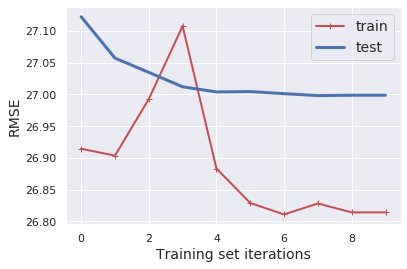

In [37]:
lin_reg = LinearRegression()

lin_reg.fit(df_train_transformed, df_train[model1_label])

df_test_predictions = lin_reg.predict(df_test_transformed)
evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])
plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE)

In [38]:
#lin_reg.summary

# New try with 1 hot encode of : 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK'

In [39]:
if (DATA_LOADED == True):
    del df
    del df_train
    del df_test
    del df_train_transformed
    del df_test_transformed

In [40]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df = load_data()

In [41]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)

In [42]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df, df_train, df_test = custom_train_test_split_sample(df)

In [43]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_train_transformed = preparation_pipeline_meansort.fit_transform(df_train, categoricalfeatures_1hotencoder__categorical_features_totransform=['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK'])
    df_train_transformed = prediction_pipeline_1hotall_without_sparse.fit_transform(df_train_transformed)

    df_test_transformed = preparation_pipeline_meansort.transform(df_test)
    df_test_transformed = prediction_pipeline_1hotall_without_sparse.transform(df_test_transformed)
    DATA_LOADED = True
    df_test_transformed.shape

In [44]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    from sklearn.linear_model import LinearRegression

    lin_reg = LinearRegression()

    lin_reg.fit(df_train_transformed, df_train[model1_label])

    df_test_predictions = lin_reg.predict(df_test_transformed)
    evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])

=> RMSE : 41.98  
=> RMSE without outliers : 26.88

In [45]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    evaluate_model(lin_reg, df_train_transformed, df_train[model1_label])

=> RMSE on training set : 41.12  
=> RMSE training set without outliers : 26.89

In [46]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    lin_reg.coef_

In [47]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    # Feature importances :
    (abs(lin_reg.coef_) / (abs(lin_reg.coef_).sum()))

In [48]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_train_transformed.shape

In [49]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_train_transformed

In [50]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE)

In [51]:
'''
To gain memory
y_train = df_train[model1_label]
y_test = df_test[model1_label]
del df_train
del df_test
'''

'\nTo gain memory\ny_train = df_train[model1_label]\ny_test = df_test[model1_label]\ndel df_train\ndel df_test\n'

In [52]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_train_transformed.shape

In [53]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    np.asarray(df_train_transformed)

In [54]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    #X2 = sm.add_constant(df_train_transformed)
    est = sm.OLS(df_train[model1_label], np.asarray(df_train_transformed.astype(float)))
    est2 = est.fit()
    print(est2.summary())

In [55]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison actual values / predict values')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_test[model1_label], df_test_predictions, color='coral')

In [56]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    plt.hist(df_test_predictions, bins=50)

In [57]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    plt.hist(df_test[model1_label], bins=50)

### Degree 2

In [58]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    nb_instances = df_train_transformed.shape[0]

In [59]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    poly = PolynomialFeaturesUnivariateAdder(n_degrees = 2)

In [60]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_train_transformed = poly.fit_transform(df_train_transformed)
    df_test_transformed = poly.fit_transform(df_test_transformed)

In [61]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    lin_reg = LinearRegression()

    lin_reg.fit(df_train_transformed, df_train[model1_label])

    df_test_predictions = lin_reg.predict(df_test_transformed)
    evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])
    plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE)

# Random forest

In [62]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    from sklearn.ensemble import RandomForestRegressor

    if (EXECUTE_INTERMEDIATE_MODELS == True):
        random_reg = RandomForestRegressor(n_estimators=10, max_depth=10, random_state=42)
        random_reg.fit(df_train_transformed, df_train[model1_label])

In [63]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    random_reg.feature_importances_

=> feature importance : 25% for CRS_ARR_TIME and 14% for UNIQUE_CARRIER  in previous model  (not this one)

In [64]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    random_reg.estimators_[0]

In [65]:
'''
from sklearn.tree import export_graphviz
export_graphviz(random_reg.estimators_[0], out_file="tree.dot", rounded=True, filled=True)
'''

'\nfrom sklearn.tree import export_graphviz\nexport_graphviz(random_reg.estimators_[0], out_file="tree.dot", rounded=True, filled=True)\n'

In [66]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_test_predictions = random_reg.predict(df_test_transformed)
    evaluate_model(random_reg, df_test_transformed, df_test[model1_label])
    plot_learning_curves(random_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE)

In [67]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE, evaluation_method='MAE')

# Cheat model : give access to the model to the ARR_DELAY variable ! it should now learn

In [68]:
if ((DATA_LOADED == True) and (EXECUTE_INTERMEDIATE_MODELS == True)):
    del df
    del df_train
    del df_test
    del df_train_transformed
    del df_test_transformed

In [69]:
df = load_data()

In [70]:
all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)

Quantitative features : ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT'] 

Qualitative features : ['ORIGIN', 'CRS_DEP_TIME', 'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'TAIL_NUM'] 



In [71]:
df, df_train, df_test = custom_train_test_split_sample(df)

In [72]:
df_train_transformed = preparation_pipeline_meansort.fit_transform(df_train, categoricalfeatures_1hotencoder__categorical_features_totransform=['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK'])
df_train_transformed = prediction_pipeline_cheat_without_sparse.fit_transform(df_train_transformed)

df_test_transformed = preparation_pipeline_meansort.transform(df_test)
df_test_transformed = prediction_pipeline_cheat_without_sparse.transform(df_test_transformed)
DATA_LOADED = True
df_test_transformed.shape

Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Fit data
Fitting feature ORIGIN
Fitting feature UNIQUE_CARRIER
Fitting feature DEST
Encode categorical features...
Encoding feature ORIGIN ...
Encoding feature UNIQUE_CARRIER ...
Encoding feature DEST ...
Fit data
!! categorical_features_totransform['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK']
Transform data
1hot encode categorical features...
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
type of df : <class 'pandas.core.frame.DataFrame'>
Features selected (in order): Index(['ARR_DELAY', 'CRS_ARR_TIME', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME',
       'DAY_OF_MONTH_1', 'DAY_OF_MONTH_10', 'DAY_OF_MONTH_11',
       'DAY_OF_MONTH_12', 'DAY_OF_MONTH_13', 'DAY_OF_MONTH_14',
       'DAY_OF_MONTH_15', 'DAY_OF_MONTH_16', 'DAY_OF_MONTH_17',
       'DAY_OF_MONTH_18', 'DAY_OF_MONTH_19', 'DA

(8000, 60)

In [73]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(df_train_transformed, df_train[model1_label])

df_test_predictions = lin_reg.predict(df_test_transformed)
evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])

RMSE : 1.6440395765025017e-13


In [74]:
evaluate_model(lin_reg, df_train_transformed, df_train[model1_label])

RMSE : 1.6328276755239714e-13


=> RMSE on training set : 41.12  
=> RMSE training set without outliers : 26.89

In [75]:
lin_reg.coef_

array([ 2.75625726e+01,  1.70447601e-16,  1.76055201e-15,  8.22197767e-16,
        3.70317130e-15, -2.98598031e-15,  2.93149940e-16,  5.95663235e-05,
        5.95663235e-05,  5.95663235e-05,  5.95663235e-05,  5.95663235e-05,
        5.95663235e-05,  5.95663235e-05,  5.95663235e-05,  5.95663235e-05,
        5.95663235e-05,  5.95663235e-05,  5.95663235e-05,  5.95663235e-05,
        5.95663235e-05,  5.95663235e-05,  5.95663235e-05,  5.95663235e-05,
        5.95663235e-05,  5.95663235e-05,  5.95663235e-05,  5.95663235e-05,
        5.95663235e-05,  5.95663235e-05,  5.95663235e-05,  5.95663235e-05,
        5.95663235e-05,  5.95663235e-05,  5.95663235e-05,  5.95663235e-05,
        5.95663235e-05,  5.95663235e-05,  3.43458512e-05,  3.43458512e-05,
        3.43458512e-05,  3.43458512e-05,  3.43458512e-05,  3.43458512e-05,
        3.43458512e-05,  1.56760049e-15, -2.33307223e-05, -2.33307223e-05,
       -2.33307223e-05, -2.33307223e-05, -2.33307223e-05, -2.33307223e-05,
       -2.33307223e-05, -

In [76]:
# Feature importances :
(abs(lin_reg.coef_) / (abs(lin_reg.coef_).sum()))

array([9.99914132e-01, 6.18349267e-18, 6.38692498e-17, 2.98276644e-17,
       1.34343531e-16, 1.08325299e-16, 1.06348842e-17, 2.16094519e-06,
       2.16094519e-06, 2.16094519e-06, 2.16094519e-06, 2.16094519e-06,
       2.16094519e-06, 2.16094519e-06, 2.16094519e-06, 2.16094519e-06,
       2.16094519e-06, 2.16094519e-06, 2.16094519e-06, 2.16094519e-06,
       2.16094519e-06, 2.16094519e-06, 2.16094519e-06, 2.16094519e-06,
       2.16094519e-06, 2.16094519e-06, 2.16094519e-06, 2.16094519e-06,
       2.16094519e-06, 2.16094519e-06, 2.16094519e-06, 2.16094519e-06,
       2.16094519e-06, 2.16094519e-06, 2.16094519e-06, 2.16094519e-06,
       2.16094519e-06, 2.16094519e-06, 1.24599770e-06, 1.24599770e-06,
       1.24599770e-06, 1.24599770e-06, 1.24599770e-06, 1.24599770e-06,
       1.24599770e-06, 5.68693606e-17, 8.46391201e-07, 8.46391201e-07,
       8.46391201e-07, 8.46391201e-07, 8.46391201e-07, 8.46391201e-07,
       8.46391201e-07, 8.46391201e-07, 8.46391201e-07, 8.46391201e-07,
      

In [77]:
df_train_transformed.shape

(72000, 60)

In [78]:
df_train_transformed

array([[-8.03001664e-01, -8.82669269e-01, -7.88329449e-01, ...,
         0.00000000e+00,  1.75000000e+02,  0.00000000e+00],
       [-6.21596246e-01, -9.13237960e-02,  2.49855947e-01, ...,
         0.00000000e+00,  1.85000000e+02,  1.00000000e+01],
       [-1.86223243e-01,  8.49460307e-01,  1.02688290e+00, ...,
         0.00000000e+00,  2.55000000e+02,  4.00000000e+00],
       ...,
       [ 3.94982028e+00,  7.13607007e-01,  8.43104745e-01, ...,
         0.00000000e+00,  2.72000000e+02,  7.00000000e+00],
       [-7.73799927e-02, -1.44306413e+00, -1.36545736e+00, ...,
         0.00000000e+00,  1.88000000e+02,  4.00000000e+00],
       [-5.12752996e-01, -2.88311081e-01, -3.72410455e-01, ...,
         0.00000000e+00,  1.87000000e+02,  5.00000000e+00]])

Calculating learning curve for 10 iterations


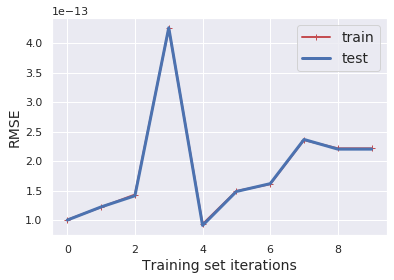

In [79]:
plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE)

In [80]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / predicted values on test set')
    plt.xlabel("Actual label")
    plt.ylabel("Actual label - Predicted label")
    plt.scatter(df_test[model1_label], df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

In [81]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison actual values / predict values on test set')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_test[model1_label], df_test_predictions, color='coral', alpha=0.1)

# Random forest without polynomial feature

In [82]:
if ((DATA_LOADED == True) and (EXECUTE_INTERMEDIATE_MODELS == True)):
    del df
    del df_train
    del df_test
    del df_train_transformed
    del df_test_transformed
    del df_train_predictions
    del df_test_predictions

In [83]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df = load_data()

In [84]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)

In [85]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df, df_train, df_test = custom_train_test_split_sample(df)

In [86]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_train_transformed = preparation_pipeline_meansort.fit_transform(df_train, categoricalfeatures_1hotencoder__categorical_features_totransform=['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK'])
    df_train_transformed = prediction_pipeline_1hotall_without_sparse.fit_transform(df_train_transformed)

    df_test_transformed = preparation_pipeline_meansort.transform(df_test)
    df_test_transformed = prediction_pipeline_1hotall_without_sparse.transform(df_test_transformed)
    DATA_LOADED = True
    df_test_transformed.shape

In [87]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    %%time
    from sklearn.ensemble import RandomForestRegressor

    if (EXECUTE_INTERMEDIATE_MODELS == True):
        random_reg = RandomForestRegressor(n_estimators=100, max_depth=100, n_jobs=-1, random_state=42)
        random_reg.fit(df_train_transformed, df_train[model1_label])

In [88]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    print("Evaluation on test set :")
    evaluate_model(random_reg, df_test_transformed, df_test[model1_label])

    print('\n')

    print("Evaluation on training set :")
    evaluate_model(random_reg, df_train_transformed, df_train[model1_label])

=> n_estimators=10, max_depth=10 : RMSE = 26.489032357237143  
=> n_estimators=100, max_depth=10 : RMSE = 26.452279766206914  
=> n_estimators=100, max_depth=100 : RMSE train = 9.623992685309045, RMSE test = 25.688478031845328

In [89]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_test_predictions = random_reg.predict(df_test_transformed)

In [90]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / predicted values on test set')
    plt.xlabel("Predicted")
    plt.ylabel("Actual - Predicted")
    plt.scatter(df_test[model1_label] - df_test_predictions, df_test_predictions, color='blue', alpha=0.1)

In [91]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    random_reg.feature_importances_

In [92]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    random_reg.feature_importances_.cumsum()

=> feature importance : 25% for CRS_ARR_TIME and 14% for UNIQUE_CARRIER  in previous model  (not this one)

In [93]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    random_reg.estimators_[0]

In [94]:
'''
from sklearn.tree import export_graphviz
export_graphviz(random_reg.estimators_[0], out_file="tree.dot", rounded=True, filled=True)
'''

'\nfrom sklearn.tree import export_graphviz\nexport_graphviz(random_reg.estimators_[0], out_file="tree.dot", rounded=True, filled=True)\n'

In [95]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    LEARNING_CURVE_STEP_SIZE

In [96]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_test_predictions = random_reg.predict(df_test_transformed)
    evaluate_model(random_reg, df_test_transformed, df_test[model1_label])
    plot_learning_curves(random_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE*5)

In [97]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison actual values / predict values')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_test[model1_label], df_test_predictions, color='coral', alpha=0.1)

In [98]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_train_predictions = random_reg.predict(df_train_transformed)

if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison actual values / predict values on training set')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_train[model1_label], df_train_predictions, color='coral', alpha=0.1)

In [99]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    plt.hist(df_test_predictions, bins=50)

In [100]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    plt.hist(df_test[model1_label], bins=50)

# New try with 1 hot encode of : 'ORIGIN', 'CARRIER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'CRS_DEP_TIME' (scheduled dep hour)

In [101]:
if ((DATA_LOADED == True) and (EXECUTE_INTERMEDIATE_MODELS == True)):
    del df
    del df_train
    del df_test
    del df_train_transformed
    del df_test_transformed

In [102]:
df = load_data()

In [103]:
df

ORIGIN CRS_DEP_TIME  MONTH  DAY_OF_MONTH  DAY_OF_WEEK UNIQUE_CARRIER  \
0          BOS         0600      9             1            4             AA   
1          BOS         0600      9             2            5             AA   
2          BOS         0600      9             6            2             AA   
3          BOS         0600      9             8            4             AA   
4          BOS         0600      9             9            5             AA   
...        ...          ...    ...           ...          ...            ...   
5547823    MEM         0600      8            31            3             WN   
5547824    MEM         0750      8            31            3             WN   
5547825    MEM         1015      8            31            3             WN   
5547826    MEM         1825      8            31            3             WN   
5547827    MEM         1150      8            31            3             WN   

        DEST CRS_ARR_TIME  DISTANCE  CRS_ELAPSED_TIME  ARR_DELAY  DEP_DELAY  \
0        JFK         0715     187.0              75.0      -23.0       -9.0   
1        JFK         0715     187.0              75.0       -6.0       -8.0   
2        JFK         0715     187.0              75.0      -19.0       -4.0   
3        JFK         0715     187.0              75.0      -27.0       -8.0   
4        JFK         0715     187.0              75.0      -21.0       -8.0   
...      ...          ...       ...               ...        ...        ...   
5547823  HOU         0735     484.0              95.0       21.0       -5.0   
5547824  MCO         1045     684.0             115.0       -3.0       -5.0   
5547825  MDW         1150     480.0              95.0       -5.0      -10.0   
5547826  MDW         1955     480.0              90.0      -14.0       -6.0   
5547827  TPA         1440     655.0             110.0       10.0       -5.0   

         TAXI_OUT TAIL_NUM  NBFLIGHTS_FORDAY_FORAIRPORT  \
0            13.0   N798AA                          370   
1            26.0   N797AA                          369   
2            12.0   N797AA                          355   
3            12.0   N784AA                          351   
4            17.0   N798AA                          352   
...           ...      ...                          ...   
5547823       8.0   N7876A                           40   
5547824      12.0   N7832A                           40   
5547825      15.0   N942WN                           40   
5547826       8.0   N965WN                           40   
5547827      20.0   N653SW                           40   

         NBFLIGHTS_FORDAYHOUR_FORAIRPORT  
0                                     30  
1                                     32  
2                                     28  
3                                     32  
4                                     32  
...                                  ...  
5547823                                6  
5547824                                5  
5547825                                2  
5547826                                3  
5547827                                5  

[5438823 rows x 16 columns]

In [104]:
all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)

Quantitative features : ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT'] 

Qualitative features : ['ORIGIN', 'CRS_DEP_TIME', 'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'TAIL_NUM'] 



In [105]:
#df, df_train, df_test = custom_train_test_split_sample_random(df)
df, df_train, df_test = custom_train_test_split_sample(df)

In [106]:
#df_train_transformed = preparation_pipeline_meansort_standardscale.fit_transform(df_train, categoricalfeatures_1hotencoder__categorical_features_totransform=None)

In [107]:
df_train_transformed = preparation_pipeline_1hotall_minmax.fit_transform(df_train, categoricalfeatures_1hotencoder__categorical_features_totransform=['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'ORIGIN', 'UNIQUE_CARRIER', 'CRS_DEP_TIME'])
#df_train_transformed = preparation_pipeline_1hotall_minmax.fit_transform(df_train, categoricalfeatures_1hotencoder__categorical_features_totransform=['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'ORIGIN', 'UNIQUE_CARRIER'])
df_test_transformed = preparation_pipeline_1hotall_minmax.transform(df_test)
DATA_LOADED = True
df_test_transformed.shape

Fit high percentile filter...
Total number of ORIGIN values : 307
Number of ORIGIN high percentile (> 80%) values : 45
Number of ORIGIN low percentile values : 262
Sum of high percentile + low percentile values : 307
Total number of DEST values : 306
Number of DEST high percentile (> 80%) values : 45
Number of DEST low percentile values : 261
Sum of high percentile + low percentile values : 306
End of high percentile filter fit
Apply high percentile filter...
Apply filter on feature ORIGIN
Apply filter on feature DEST
Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Fit data
!! categorical_features_totransform['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'ORIGIN', 'UNIQUE_CARRIER', 'CRS_DEP_TIME']
Transform data
1hot encode categorical features...
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
Column values that were in fi

(8000, 138)

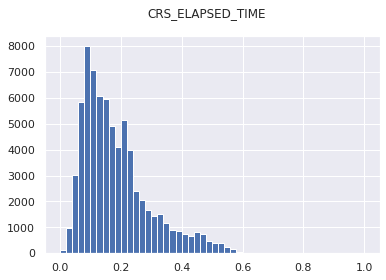

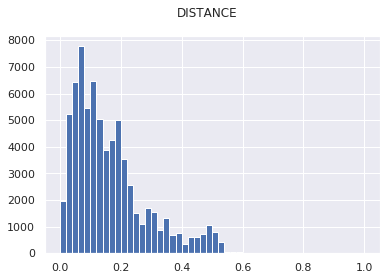

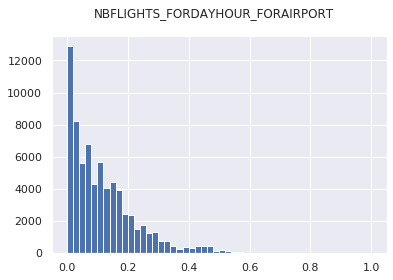

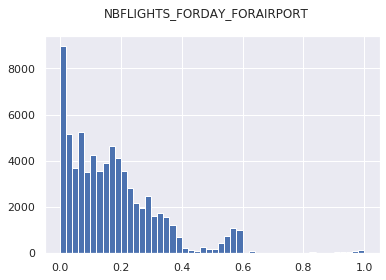

In [108]:
for feat_name in df_train_transformed.columns:
    if (feat_name in MODEL_1HOTALL_FEATURES_QUANTITATIVE):
        fig = plt.figure()
        fig.suptitle(feat_name)
        plt.hist(df_train_transformed[feat_name], bins=50)
        plt.plot()

## Linear regression

In [109]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(df_train_transformed, df_train[model1_label])

df_test_predictions = lin_reg.predict(df_test_transformed)

print("Evaluation on test set :")
evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])

print('\n')

print("Evaluation on training set :")
evaluate_model(lin_reg, df_train_transformed, df_train[model1_label])

Evaluation on test set :
RMSE : 26.972141699472907


Evaluation on training set :
RMSE : 26.873648666466085


=> With 80000 samples and train_test_split simple random (without stratify on ARR_DELAY ):  
Evaluation on test set :  
RMSE : 27.143078661756135  


Evaluation on training set :  
RMSE : 27.053691910444368  


Same with stratify split on ARR_DELAY :
Evaluation on test set :  
RMSE : 26.972141699472907  


Evaluation on training set :  
RMSE : 26.873648666466085  

(array([  3.,   2.,   8.,  10.,  18.,  27.,  38.,  62.,  84., 112., 133.,
        152., 218., 226., 306., 320., 348., 368., 433., 445., 427., 454.,
        451., 429., 438., 394., 343., 343., 292., 242., 220., 149., 165.,
        105.,  80.,  57.,  35.,  30.,  10.,  14.,   3.,   4.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([-18.53125 , -17.623125, -16.715   , -15.806875, -14.89875 ,
        -13.990625, -13.0825  , -12.174375, -11.26625 , -10.358125,
         -9.45    ,  -8.541875,  -7.63375 ,  -6.725625,  -5.8175  ,
         -4.909375,  -4.00125 ,  -3.093125,  -2.185   ,  -1.276875,
         -0.36875 ,   0.539375,   1.4475  ,   2.355625,   3.26375 ,
          4.171875,   5.08    ,   5.988125,   6.89625 ,   7.804375,
          8.7125  ,   9.620625,  10.52875 ,  11.436875,  12.345   ,
         13.253125,  14.16125 ,  15.069375,  15.9775  ,  16.885625,
         17.79375 ,  18.701875,  19.61    ,  20.518125,  21.42625 ,
         22.334375,  23.2425  ,  24.150625,  2

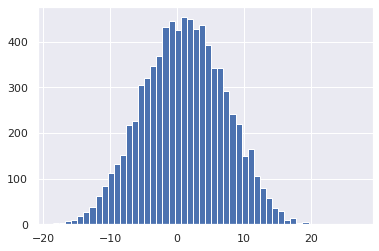

In [110]:
plt.hist(df_test_predictions, bins=50)

In [111]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison actual values / predict values on test set')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_test[model1_label], df_test_predictions, color='coral', alpha=0.1)

In [112]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / predicted values on test set')
    plt.xlabel("Predicted")
    plt.ylabel("Actual - Predicted")
    plt.scatter(df_test_predictions, df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

In [113]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / actual values on test set')
    plt.xlabel("Actual")
    plt.ylabel("Actual - Predicted")
    plt.scatter(df_test[model1_label], df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

In [114]:
df_train_predictions = lin_reg.predict(df_train_transformed)

if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison actual values / predict values on training set')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_train[model1_label], df_train_predictions, color='coral', alpha=0.1)

In [115]:
df_test_transformed.columns

Index(['CRS_DEP_TIME_00', 'CRS_DEP_TIME_01', 'CRS_DEP_TIME_02',
       'CRS_DEP_TIME_03', 'CRS_DEP_TIME_04', 'CRS_DEP_TIME_05',
       'CRS_DEP_TIME_06', 'CRS_DEP_TIME_07', 'CRS_DEP_TIME_08',
       'CRS_DEP_TIME_09',
       ...
       'UNIQUE_CARRIER_B6', 'UNIQUE_CARRIER_DL', 'UNIQUE_CARRIER_EV',
       'UNIQUE_CARRIER_F9', 'UNIQUE_CARRIER_HA', 'UNIQUE_CARRIER_NK',
       'UNIQUE_CARRIER_OO', 'UNIQUE_CARRIER_UA', 'UNIQUE_CARRIER_VX',
       'UNIQUE_CARRIER_WN'],
      dtype='object', length=138)

In [116]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Predicted - actual / CRS_ELAPSED_TIME values on test set')
    plt.xlabel("CRS_ELAPSED_TIME")
    plt.ylabel("Actual - Predicted")
    plt.scatter(df_test['CRS_ELAPSED_TIME'], df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

In [117]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    for column_name in df_test_transformed.columns:
        fig = plt.figure()
        fig.suptitle('Comparison Predicted - actual / values of one feature on test set')
        plt.xlabel(column_name)
        plt.ylabel("Actual - Predicted")
        plt.scatter(df_test_transformed[column_name], df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

In [118]:
lin_reg.coef_

array([-2.45668681e+12, -2.45668681e+12, -2.45668681e+12, -2.45668681e+12,
       -2.45668681e+12, -2.45668681e+12, -2.45668681e+12, -2.45668681e+12,
       -2.45668681e+12, -2.45668681e+12, -2.45668681e+12, -2.45668681e+12,
       -2.45668681e+12, -2.45668681e+12, -2.45668681e+12, -2.45668681e+12,
       -2.45668681e+12, -2.45668681e+12, -2.45668681e+12, -2.45668681e+12,
       -2.45668681e+12, -2.45668681e+12, -2.45668681e+12, -2.45668681e+12,
       -4.74165649e+01, -5.89764959e+13, -5.89764959e+13, -5.89764959e+13,
       -5.89764959e+13, -5.89764959e+13, -5.89764959e+13, -5.89764959e+13,
       -5.89764959e+13, -5.89764959e+13, -5.89764959e+13, -5.89764959e+13,
       -5.89764959e+13, -5.89764959e+13, -5.89764959e+13, -5.89764959e+13,
       -5.89764959e+13, -5.89764959e+13, -5.89764959e+13, -5.89764959e+13,
       -5.89764959e+13, -5.89764959e+13, -5.89764959e+13, -5.89764959e+13,
       -5.89764959e+13, -5.89764959e+13, -5.89764959e+13, -5.89764959e+13,
       -5.89764959e+13, -

In [119]:
coef_feature_importances = (abs(lin_reg.coef_) / (abs(lin_reg.coef_).sum()))

In [120]:
coef_feature_importances.sum()

0.9999999999999999

In [121]:
df_feature_importances = pd.DataFrame(data = {'Feature name' : df_train_transformed.columns, 'Feature importance' : coef_feature_importances})

In [122]:
pd.concat([df_feature_importances.sort_values(by='Feature importance', ascending=False), \
           df_feature_importances[['Feature importance']].sort_values(by='Feature importance', ascending=False).cumsum()], axis=1)

Feature name  Feature importance  Feature importance
61                    DAY_OF_WEEK_6        4.854507e-02            0.048545
58                    DAY_OF_WEEK_3        4.854507e-02            0.097090
57                    DAY_OF_WEEK_2        4.854507e-02            0.145635
62                    DAY_OF_WEEK_7        4.854507e-02            0.194180
56                    DAY_OF_WEEK_1        4.854507e-02            0.242725
..                              ...                 ...                 ...
4                   CRS_DEP_TIME_04        6.498665e-04            1.000000
24                 CRS_ELAPSED_TIME        1.254309e-14            1.000000
63                         DISTANCE        1.094546e-14            1.000000
77      NBFLIGHTS_FORDAY_FORAIRPORT        1.934373e-15            1.000000
76  NBFLIGHTS_FORDAYHOUR_FORAIRPORT        5.300926e-16            1.000000

[138 rows x 3 columns]

## Random forest

In [123]:
%%time
from sklearn.ensemble import RandomForestRegressor

#if (EXECUTE_INTERMEDIATE_MODELS == True):
    #Old Random Fores before having done cross validation (done in group + mean sort encoding part)
    #random_reg = RandomForestRegressor(n_estimators=100, max_depth=100, n_jobs=-1, random_state=42)
    
random_reg = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                  max_features=4, max_leaf_nodes=None,
                  min_impurity_decrease=0.0, min_impurity_split=None,
                  min_samples_leaf=1, min_samples_split=2,
                  min_weight_fraction_leaf=0.0, n_estimators=1000,
                  n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                  warm_start=False)

random_reg.fit(df_train_transformed, df_train[model1_label])

CPU times: user 1min 12s, sys: 723 ms, total: 1min 13s
Wall time: 11.9 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [124]:
print("Evaluation on test set :")
evaluate_model(random_reg, df_test_transformed, df_test[model1_label])

print('\n')

print("Evaluation on training set :")
evaluate_model(random_reg, df_train_transformed, df_train[model1_label])

error_mean = evaluate_model_percent_mean(random_reg, df_test_transformed, df_test[model1_label], 0.8)
print(f'Mean prediction error {EVALUATION_PERCENT*100}% of the time : {error_mean : .2f}')

Evaluation on test set :
RMSE : 27.2916161530929


Evaluation on training set :
RMSE : 27.00703718949282
Mean prediction error 90.0% of the time :  10.22


With old random forest (without cross validation)

    With random split strategy :

    Evaluation on test set :  
    RMSE : 27.067602891326597  

    Evaluation on training set :  
    RMSE : 10.126836763135943  

    With shuffle split by ARR_DELAY strategy :  
    Evaluation on test set :  
    RMSE : 27.16789238410523  


    Evaluation on training set :  
    RMSE : 10.072030081721588  
    
With new random forest (after cross validation):  
    With shuffle split by ARR_DELAY strategy :    
    
    Evaluation on test set :
    RMSE : 27.2916161530929


    Evaluation on training set :
    RMSE : 27.00703718949282
    
    Mean prediction error 90.0% of the time :  10.22

In [125]:
df_test_predictions = random_reg.predict(df_test_transformed)

In [126]:
df_train_predictions = random_reg.predict(df_train_transformed)

In [127]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / predicted values on test set')
    plt.xlabel("Predicted")
    plt.ylabel("Actual - Predicted")
    plt.scatter(df_test_predictions, df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

In [128]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / actual values on test set')
    plt.xlabel("Actual label")
    plt.ylabel("Actual label - Predicted label")
    plt.scatter(df_test[model1_label], df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

In [129]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / predicted values on training set')
    plt.xlabel("Actual label")
    plt.ylabel("Actual label - Predicted label")
    plt.scatter(df_train[model1_label], df_train[model1_label] - df_train_predictions, color='blue', alpha=0.1)

In [130]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / instance numbers on training set')
    plt.xlabel("Instance number")
    plt.ylabel("Actual label - Predicted label")
    plt.scatter(range(df_train.shape[0]), df_train[model1_label] - df_train_predictions, color='blue', alpha=0.1)

In [131]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Predicted - actual / CRS_ELAPSED_TIME values on test set')
    plt.xlabel("CRS_ELAPSED_TIME")
    plt.ylabel("Actual - Predicted")
    plt.scatter(df_test['CRS_ELAPSED_TIME'], df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

In [132]:
df_train_predictions = random_reg.predict(df_train_transformed)

if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Random forest : Comparison actual values / predict values on training set')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_train[model1_label], df_train_predictions, color='coral', alpha=0.1)

In [133]:
df_train_transformed.columns

Index(['CRS_DEP_TIME_00', 'CRS_DEP_TIME_01', 'CRS_DEP_TIME_02',
       'CRS_DEP_TIME_03', 'CRS_DEP_TIME_04', 'CRS_DEP_TIME_05',
       'CRS_DEP_TIME_06', 'CRS_DEP_TIME_07', 'CRS_DEP_TIME_08',
       'CRS_DEP_TIME_09',
       ...
       'UNIQUE_CARRIER_B6', 'UNIQUE_CARRIER_DL', 'UNIQUE_CARRIER_EV',
       'UNIQUE_CARRIER_F9', 'UNIQUE_CARRIER_HA', 'UNIQUE_CARRIER_NK',
       'UNIQUE_CARRIER_OO', 'UNIQUE_CARRIER_UA', 'UNIQUE_CARRIER_VX',
       'UNIQUE_CARRIER_WN'],
      dtype='object', length=138)

In [134]:
pd.set_option('display.max_rows', 200)

In [135]:
df_feature_importances = pd.DataFrame(data = {'Feature name' : df_train_transformed.columns, 'Feature importance' : random_reg.feature_importances_})

In [136]:
pd.concat([df_feature_importances.sort_values(by='Feature importance', ascending=False), \
           df_feature_importances[['Feature importance']].sort_values(by='Feature importance', ascending=False).cumsum()], axis=1)

Feature name  Feature importance  Feature importance
77       NBFLIGHTS_FORDAY_FORAIRPORT        6.021275e-02            0.060213
76   NBFLIGHTS_FORDAYHOUR_FORAIRPORT        5.220542e-02            0.112418
24                  CRS_ELAPSED_TIME        5.172928e-02            0.164147
63                          DISTANCE        4.924820e-02            0.213396
129                UNIQUE_CARRIER_DL        4.804776e-02            0.261443
6                    CRS_DEP_TIME_06        3.629092e-02            0.297734
73                           MONTH_7        2.587507e-02            0.323609
7                    CRS_DEP_TIME_07        2.451323e-02            0.348123
18                   CRS_DEP_TIME_18        2.376988e-02            0.371893
19                   CRS_DEP_TIME_19        2.185223e-02            0.393745
67                          MONTH_12        2.007587e-02            0.413821
5                    CRS_DEP_TIME_05        1.892756e-02            0.432748
8                    CRS_DEP_TIME_08        1.713337e-02            0.449882
66                          MONTH_11        1.659911e-02            0.466481
137                UNIQUE_CARRIER_WN        1.557970e-02            0.482060
20                   CRS_DEP_TIME_20        1.507256e-02            0.497133
17                   CRS_DEP_TIME_17        1.343174e-02            0.510565
74                           MONTH_8        1.293999e-02            0.523505
72                           MONTH_6        1.257683e-02            0.536081
59                     DAY_OF_WEEK_4        1.231807e-02            0.548400
128                UNIQUE_CARRIER_B6        1.214916e-02            0.560549
109                    ORIGIN_OTHERS        1.208535e-02            0.572634
21                   CRS_DEP_TIME_21        1.101527e-02            0.583649
98                        ORIGIN_LAX        1.076603e-02            0.594415
75                           MONTH_9        1.052209e-02            0.604937
16                   CRS_DEP_TIME_16        1.029060e-02            0.615228
60                     DAY_OF_WEEK_5        9.947185e-03            0.625175
61                     DAY_OF_WEEK_6        9.393395e-03            0.634569
126                UNIQUE_CARRIER_AA        8.910428e-03            0.643479
68                           MONTH_2        8.494814e-03            0.651974
65                          MONTH_10        8.390317e-03            0.660364
135                UNIQUE_CARRIER_UA        8.247017e-03            0.668611
9                    CRS_DEP_TIME_09        7.933450e-03            0.676545
57                     DAY_OF_WEEK_2        7.361692e-03            0.683906
34                   DAY_OF_MONTH_18        7.270241e-03            0.691177
33                   DAY_OF_MONTH_17        7.223946e-03            0.698401
62                     DAY_OF_WEEK_7        7.179838e-03            0.705580
58                     DAY_OF_WEEK_3        7.053441e-03            0.712634
89                        ORIGIN_DFW        6.991059e-03            0.719625
136                UNIQUE_CARRIER_VX        6.711060e-03            0.726336
133                UNIQUE_CARRIER_NK        6.691572e-03            0.733028
15                   CRS_DEP_TIME_15        6.470870e-03            0.739498
56                     DAY_OF_WEEK_1        6.169335e-03            0.745668
108                       ORIGIN_ORD        6.059478e-03            0.751727
134                UNIQUE_CARRIER_OO        5.888526e-03            0.757616
32                   DAY_OF_MONTH_16        5.431302e-03            0.763047
130                UNIQUE_CARRIER_EV        5.240480e-03            0.768288
64                           MONTH_1        5.105598e-03            0.773393
69                           MONTH_3        4.970644e-03            0.778364
40                   DAY_OF_MONTH_23        4.964933e-03            0.783329
31                   DAY_OF_MONTH_15        4.732581e-03            0.788061
11                  

In [137]:
random_reg.feature_importances_

array([4.73546901e-04, 3.51202382e-04, 1.04863405e-04, 5.14617583e-05,
       9.59257938e-04, 1.89275556e-02, 3.62909205e-02, 2.45132318e-02,
       1.71333723e-02, 7.93345041e-03, 4.33085628e-03, 4.70144142e-03,
       3.24962094e-03, 3.24267231e-03, 4.02427825e-03, 6.47087006e-03,
       1.02906039e-02, 1.34317411e-02, 2.37698830e-02, 2.18522332e-02,
       1.50725606e-02, 1.10152717e-02, 4.01935633e-03, 1.19622394e-03,
       5.17292788e-02, 3.17571707e-03, 3.42893996e-03, 2.82180727e-03,
       2.79121528e-03, 3.04244623e-03, 2.96658277e-03, 4.73258112e-03,
       5.43130159e-03, 7.22394573e-03, 7.27024122e-03, 3.37904259e-03,
       3.82617407e-03, 3.30752550e-03, 3.99472401e-03, 2.97920499e-03,
       4.96493339e-03, 3.32096821e-03, 3.60278901e-03, 4.32371438e-03,
       2.70109887e-03, 4.19910552e-03, 2.84057365e-03, 2.94345983e-03,
       3.85803589e-03, 2.37706317e-03, 3.41982617e-03, 2.64155721e-03,
       3.38336689e-03, 3.00099496e-03, 3.75192364e-03, 3.15921921e-03,
      

In [138]:
random_reg.feature_importances_.cumsum()

array([4.73546901e-04, 8.24749282e-04, 9.29612687e-04, 9.81074445e-04,
       1.94033238e-03, 2.08678880e-02, 5.71588085e-02, 8.16720402e-02,
       9.88054126e-02, 1.06738863e-01, 1.11069719e-01, 1.15771161e-01,
       1.19020782e-01, 1.22263454e-01, 1.26287732e-01, 1.32758602e-01,
       1.43049206e-01, 1.56480947e-01, 1.80250830e-01, 2.02103063e-01,
       2.17175624e-01, 2.28190896e-01, 2.32210252e-01, 2.33406476e-01,
       2.85135755e-01, 2.88311472e-01, 2.91740412e-01, 2.94562219e-01,
       2.97353434e-01, 3.00395881e-01, 3.03362463e-01, 3.08095045e-01,
       3.13526346e-01, 3.20750292e-01, 3.28020533e-01, 3.31399576e-01,
       3.35225750e-01, 3.38533275e-01, 3.42527999e-01, 3.45507204e-01,
       3.50472138e-01, 3.53793106e-01, 3.57395895e-01, 3.61719609e-01,
       3.64420708e-01, 3.68619814e-01, 3.71460387e-01, 3.74403847e-01,
       3.78261883e-01, 3.80638946e-01, 3.84058772e-01, 3.86700330e-01,
       3.90083696e-01, 3.93084691e-01, 3.96836615e-01, 3.99995834e-01,
      

=> feature importance : 

In [139]:
random_reg.estimators_[0]

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=4,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=1608637542, splitter='best')

In [140]:
'''
from sklearn.tree import export_graphviz
export_graphviz(random_reg.estimators_[0], out_file="tree.dot", rounded=True, filled=True)
'''

'\nfrom sklearn.tree import export_graphviz\nexport_graphviz(random_reg.estimators_[0], out_file="tree.dot", rounded=True, filled=True)\n'

In [141]:
LEARNING_CURVE_STEP_SIZE

8000

In [142]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    #df_test_predictions = random_reg.predict(df_test_transformed)
    #evaluate_model(random_reg, df_test_transformed, df_test[model1_label])
    plot_learning_curves(random_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], int(LEARNING_CURVE_STEP_SIZE))

### Parameter search and cross validation

In [143]:
'''
%%time
from sklearn.ensemble import RandomForestRegressor

if (RECOMPUTE_GRIDSEARCH == True):
    random_reg = RandomForestRegressor(n_jobs=-1, random_state=42)

    param_grid = {
            'n_estimators':  [10, 100, 200, 500, 1000],
            'max_depth': [10, 100, 200, 500, 1000],
            'max_features': [2, 5, 50, 137],
            'max_leaf_nodes': [2, 10, 100, None],
            #'criterion': ['mse', 'mae'],
            'criterion': ['mse'],
            'n_jobs': [-1],
            'random_state': [42],
        }

    grid_search = GridSearchCV(random_reg, param_grid, cv=5, verbose=2, error_score=np.nan, scoring='neg_mean_squared_error')
    grid_search.fit(df_train_transformed, df_train[model1_label])
    
'''

"\n%%time\nfrom sklearn.ensemble import RandomForestRegressor\n\nif (RECOMPUTE_GRIDSEARCH == True):\n    random_reg = RandomForestRegressor(n_jobs=-1, random_state=42)\n\n    param_grid = {\n            'n_estimators':  [10, 100, 200, 500, 1000],\n            'max_depth': [10, 100, 200, 500, 1000],\n            'max_features': [2, 5, 50, 137],\n            'max_leaf_nodes': [2, 10, 100, None],\n            #'criterion': ['mse', 'mae'],\n            'criterion': ['mse'],\n            'n_jobs': [-1],\n            'random_state': [42],\n        }\n\n    grid_search = GridSearchCV(random_reg, param_grid, cv=5, verbose=2, error_score=np.nan, scoring='neg_mean_squared_error')\n    grid_search.fit(df_train_transformed, df_train[model1_label])\n    \n"

## Linear regression with degree 8 polynomial

In [144]:
poly = PolynomialFeaturesUnivariateAdder_DataFrame(n_degrees = 8)

In [145]:
MODEL_1HOTALL_FEATURES_QUANTITATIVE

['DISTANCE',
 'CRS_ELAPSED_TIME',
 'NBFLIGHTS_FORDAY_FORAIRPORT',
 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT']

In [146]:
df_train_transformed

CRS_DEP_TIME_00  CRS_DEP_TIME_01  CRS_DEP_TIME_02  CRS_DEP_TIME_03  \
2390410                0                0                0                0   
1676587                0                0                0                0   
4883040                0                0                0                0   
1553841                0                0                0                0   
1102373                0                0                0                0   
...                  ...              ...              ...              ...   
356900                 0                0                0                0   
5056543                0                0                0                0   
4382560                0                0                0                0   
3513765                0                0                0                0   
4702457                0                0                0                0   

         CRS_DEP_TIME_04  CRS_DEP_TIME_05  CRS_DEP_TIME_06  CRS_DEP_TIME_07  \
2390410                0                0                0                0   
1676587                0                0                0                0   
4883040                0                0                0                0   
1553841                0                0                0                0   
1102373                0                0                0                0   
...                  ...              ...              ...              ...   
356900                 0                0                0                0   
5056543                0                0                0                0   
4382560                0                0                0                0   
3513765                0                0                1                0   
4702457                0                0                0                0   

         CRS_DEP_TIME_08  CRS_DEP_TIME_09  ...  UNIQUE_CARRIER_B6  \
2390410                0                1  ...                  0   
1676587                0                0  ...                  0   
4883040                0                0  ...                  0   
1553841                0                0  ...                  0   
1102373                0                0  ...                  0   
...                  ...              ...  ...                ...   
356900                 0                0  ...                  0   
5056543                0                1  ...                  0   
4382560                0                0  ...                  0   
3513765                0                0  ...                  0   
4702457                0                0  ...                  0   

         UNIQUE_CARRIER_DL  UNIQUE_CARRIER_EV  UNIQUE_CARRIER_F9  \
2390410                  1                  0                  0   
1676587                  0                  0                  0   
4883040                  0                  0                  0   
1553841                  0                  0                  0   
1102373                  0                  0                  0   
...                    ...                ...                ...   
356900                   1                  0                  0   
5056543                  1                  0                  0   
4382560                  0                  0                  0   
3513765                  0                  0                  0   
4702457                  0                  1                  0   

         UNIQUE_CARRIER_HA  UNIQUE_CARRIER_NK  UNIQUE_CARRIER_OO  \
2390410                  0                  0                  0   
1676587                  0                  1                  0   
4883040                  0                  0                  1   
1553841                  0                  0                  0   
1102373                  0                  0                  0   
...                    ...                ...            

In [147]:
df_test_transformed

CRS_DEP_TIME_00  CRS_DEP_TIME_01  CRS_DEP_TIME_02  CRS_DEP_TIME_03  \
4681469                0                0                0                0   
1034394                0                0                0                0   
3011767                0                0                0                0   
2494819                0                0                0                0   
2716269                0                0                0                0   
...                  ...              ...              ...              ...   
4363312                0                0                0                0   
2360622                0                0                0                0   
32676                  0                0                0                0   
4927976                0                0                0                0   
5469090                0                0                0                0   

         CRS_DEP_TIME_04  CRS_DEP_TIME_05  CRS_DEP_TIME_06  CRS_DEP_TIME_07  \
4681469                0                0                0                0   
1034394                0                0                0                0   
3011767                0                0                0                0   
2494819                0                0                0                0   
2716269                0                0                0                0   
...                  ...              ...              ...              ...   
4363312                0                0                0                0   
2360622                0                0                0                0   
32676                  0                0                1                0   
4927976                0                0                0                0   
5469090                0                0                0                0   

         CRS_DEP_TIME_08  CRS_DEP_TIME_09  ...  UNIQUE_CARRIER_B6  \
4681469                0                0  ...                  0   
1034394                0                1  ...                  0   
3011767                0                0  ...                  1   
2494819                0                0  ...                  0   
2716269                0                0  ...                  0   
...                  ...              ...  ...                ...   
4363312                0                0  ...                  0   
2360622                0                0  ...                  0   
32676                  0                0  ...                  0   
4927976                0                1  ...                  0   
5469090                0                0  ...                  0   

         UNIQUE_CARRIER_DL  UNIQUE_CARRIER_EV  UNIQUE_CARRIER_F9  \
4681469                  0                  1                  0   
1034394                  0                  1                  0   
3011767                  0                  0                  0   
2494819                  0                  0                  0   
2716269                  0                  0                  0   
...                    ...                ...                ...   
4363312                  0                  0                  0   
2360622                  1                  0                  0   
32676                    0                  0                  0   
4927976                  0                  0                  0   
5469090                  0                  0                  0   

         UNIQUE_CARRIER_HA  UNIQUE_CARRIER_NK  UNIQUE_CARRIER_OO  \
4681469                  0                  0                  0   
1034394                  0                  0                  0   
3011767                  0                  0                  0   
2494819                  0                  0                  0   
2716269                  0                  0                  0   
...                    ...                ...            

In [148]:
df_train_transformed = poly.fit_transform(df_train_transformed, features_toadd=MODEL_1HOTALL_FEATURES_QUANTITATIVE)

fit
Features to add :
['DISTANCE', 'CRS_ELAPSED_TIME', 'NBFLIGHTS_FORDAY_FORAIRPORT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT']
transform


Adding polynomial features


In [149]:
df_test_transformed = poly.transform(df_test_transformed)

transform


Adding polynomial features


In [150]:
df_test_transformed

CRS_DEP_TIME_00  CRS_DEP_TIME_01  CRS_DEP_TIME_02  CRS_DEP_TIME_03  \
4681469                0                0                0                0   
1034394                0                0                0                0   
3011767                0                0                0                0   
2494819                0                0                0                0   
2716269                0                0                0                0   
...                  ...              ...              ...              ...   
4363312                0                0                0                0   
2360622                0                0                0                0   
32676                  0                0                0                0   
4927976                0                0                0                0   
5469090                0                0                0                0   

         CRS_DEP_TIME_04  CRS_DEP_TIME_05  CRS_DEP_TIME_06  CRS_DEP_TIME_07  \
4681469                0                0                0                0   
1034394                0                0                0                0   
3011767                0                0                0                0   
2494819                0                0                0                0   
2716269                0                0                0                0   
...                  ...              ...              ...              ...   
4363312                0                0                0                0   
2360622                0                0                0                0   
32676                  0                0                1                0   
4927976                0                0                0                0   
5469090                0                0                0                0   

         CRS_DEP_TIME_08  CRS_DEP_TIME_09  ...  \
4681469                0                0  ...   
1034394                0                1  ...   
3011767                0                0  ...   
2494819                0                0  ...   
2716269                0                0  ...   
...                  ...              ...  ...   
4363312                0                0  ...   
2360622                0                0  ...   
32676                  0                0  ...   
4927976                0                1  ...   
5469090                0                0  ...   

         NBFLIGHTS_FORDAY_FORAIRPORT_DEG6  NBFLIGHTS_FORDAY_FORAIRPORT_DEG7  \
4681469                      3.969046e-04                      1.075971e-04   
1034394                      9.846400e-15                      4.558519e-17   
3011767                      2.307095e-05                      3.892630e-06   
2494819                      9.363759e-08                      6.309940e-09   
2716269                      1.061365e-04                      2.309451e-05   
...                                   ...                               ...   
4363312                      1.255330e-04                      2.808995e-05   
2360622                      2.627926e-04                      6.650923e-05   
32676                        7.037283e-05                      1.429901e-05   
4927976                      1.966757e-08                      1.021823e-09   
5469090                      7.670052e-06                      1.077122e-06   

         NBFLIGHTS_FORDAY_FORAIRPORT_DEG8  \
4681469                      2.916855e-05   
1034394                      2.110425e-19   
3011767                      6.567811e-07   
2494819                      4.252069e-10   
2716269                      5.025194e-06   
...                                   ...   
4363312                      6.285560e-06   
2360622                      1.683258e-05   
32676                        2.905405e-06   
4927976                      5.308856e-11   
5469090                      1.512624e-07   

         NBFLIGHTS_F

In [151]:
df_train_transformed

CRS_DEP_TIME_00  CRS_DEP_TIME_01  CRS_DEP_TIME_02  CRS_DEP_TIME_03  \
2390410                0                0                0                0   
1676587                0                0                0                0   
4883040                0                0                0                0   
1553841                0                0                0                0   
1102373                0                0                0                0   
...                  ...              ...              ...              ...   
356900                 0                0                0                0   
5056543                0                0                0                0   
4382560                0                0                0                0   
3513765                0                0                0                0   
4702457                0                0                0                0   

         CRS_DEP_TIME_04  CRS_DEP_TIME_05  CRS_DEP_TIME_06  CRS_DEP_TIME_07  \
2390410                0                0                0                0   
1676587                0                0                0                0   
4883040                0                0                0                0   
1553841                0                0                0                0   
1102373                0                0                0                0   
...                  ...              ...              ...              ...   
356900                 0                0                0                0   
5056543                0                0                0                0   
4382560                0                0                0                0   
3513765                0                0                1                0   
4702457                0                0                0                0   

         CRS_DEP_TIME_08  CRS_DEP_TIME_09  ...  \
2390410                0                1  ...   
1676587                0                0  ...   
4883040                0                0  ...   
1553841                0                0  ...   
1102373                0                0  ...   
...                  ...              ...  ...   
356900                 0                0  ...   
5056543                0                1  ...   
4382560                0                0  ...   
3513765                0                0  ...   
4702457                0                0  ...   

         NBFLIGHTS_FORDAY_FORAIRPORT_DEG6  NBFLIGHTS_FORDAY_FORAIRPORT_DEG7  \
2390410                      4.492790e-04                      1.243375e-04   
1676587                      4.601605e-05                      8.710857e-06   
4883040                      1.914105e-03                      6.744662e-04   
1553841                      2.940119e-08                      1.633400e-09   
1102373                      1.503757e-03                      5.089879e-04   
...                                   ...                               ...   
356900                       3.598665e-02                      2.067752e-02   
5056543                      2.989463e-02                      1.665426e-02   
4382560                      5.506789e-07                      4.985570e-08   
3513765                      1.644344e-11                      2.622153e-13   
4702457                      5.550630e-03                      2.335604e-03   

         NBFLIGHTS_FORDAY_FORAIRPORT_DEG8  \
2390410                      3.441027e-05   
1676587                      1.648969e-06   
4883040                      2.376591e-04   
1553841                      9.074443e-11   
1102373                      1.722809e-04   
...                                   ...   
356900                       1.188106e-02   
5056543                      9.278068e-03   
4382560                      4.513685e-09   
3513765                      4.181417e-15   
4702457                      9.827801e-04   

         NBFLIGHTS_F

In [152]:
for col_name in df_test_transformed.columns:
    print(col_name)

CRS_DEP_TIME_00
CRS_DEP_TIME_01
CRS_DEP_TIME_02
CRS_DEP_TIME_03
CRS_DEP_TIME_04
CRS_DEP_TIME_05
CRS_DEP_TIME_06
CRS_DEP_TIME_07
CRS_DEP_TIME_08
CRS_DEP_TIME_09
CRS_DEP_TIME_10
CRS_DEP_TIME_11
CRS_DEP_TIME_12
CRS_DEP_TIME_13
CRS_DEP_TIME_14
CRS_DEP_TIME_15
CRS_DEP_TIME_16
CRS_DEP_TIME_17
CRS_DEP_TIME_18
CRS_DEP_TIME_19
CRS_DEP_TIME_20
CRS_DEP_TIME_21
CRS_DEP_TIME_22
CRS_DEP_TIME_23
CRS_ELAPSED_TIME
DAY_OF_MONTH_1
DAY_OF_MONTH_10
DAY_OF_MONTH_11
DAY_OF_MONTH_12
DAY_OF_MONTH_13
DAY_OF_MONTH_14
DAY_OF_MONTH_15
DAY_OF_MONTH_16
DAY_OF_MONTH_17
DAY_OF_MONTH_18
DAY_OF_MONTH_19
DAY_OF_MONTH_2
DAY_OF_MONTH_20
DAY_OF_MONTH_21
DAY_OF_MONTH_22
DAY_OF_MONTH_23
DAY_OF_MONTH_24
DAY_OF_MONTH_25
DAY_OF_MONTH_26
DAY_OF_MONTH_27
DAY_OF_MONTH_28
DAY_OF_MONTH_29
DAY_OF_MONTH_3
DAY_OF_MONTH_30
DAY_OF_MONTH_31
DAY_OF_MONTH_4
DAY_OF_MONTH_5
DAY_OF_MONTH_6
DAY_OF_MONTH_7
DAY_OF_MONTH_8
DAY_OF_MONTH_9
DAY_OF_WEEK_1
DAY_OF_WEEK_2
DAY_OF_WEEK_3
DAY_OF_WEEK_4
DAY_OF_WEEK_5
DAY_OF_WEEK_6
DAY_OF_WEEK_7
DISTANCE
MONTH

In [153]:
lin_reg = LinearRegression()

lin_reg.fit(df_train_transformed, df_train[model1_label])

df_test_predictions = lin_reg.predict(df_test_transformed)

print("Evaluation on test set :")
evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])

print('\n')

print("Evaluation on training set :")
evaluate_model(lin_reg, df_train_transformed, df_train[model1_label])

Evaluation on test set :
RMSE : 26.95226845559282


Evaluation on training set :
RMSE : 26.854411040029486


In [154]:
coef_feature_importances = (abs(lin_reg.coef_) / (abs(lin_reg.coef_).sum()))

In [155]:
df_feature_importances = pd.DataFrame(data = {'Feature name' : df_train_transformed.columns, 'Feature importance' : coef_feature_importances})

In [156]:
pd.concat([df_feature_importances.sort_values(by='Feature importance', ascending=False), \
           df_feature_importances[['Feature importance']].sort_values(by='Feature importance', ascending=False).cumsum()], axis=1)

Feature name  Feature importance  \
59                          DAY_OF_WEEK_4        2.395367e-02   
60                          DAY_OF_WEEK_5        2.395367e-02   
56                          DAY_OF_WEEK_1        2.395367e-02   
62                          DAY_OF_WEEK_7        2.395367e-02   
57                          DAY_OF_WEEK_2        2.395367e-02   
58                          DAY_OF_WEEK_3        2.395367e-02   
61                          DAY_OF_WEEK_6        2.395367e-02   
73                                MONTH_7        2.306026e-02   
67                               MONTH_12        2.306026e-02   
74                                MONTH_8        2.306026e-02   
72                                MONTH_6        2.306026e-02   
64                                MONTH_1        2.306026e-02   
70                                MONTH_4        2.306026e-02   
71                                MONTH_5        2.306026e-02   
69                                MONTH_3        2.306026e-02   
68                                MONTH_2        2.306026e-02   
65                               MONTH_10        2.306026e-02   
75                                MONTH_9        2.306026e-02   
66                               MONTH_11        2.306026e-02   
136                     UNIQUE_CARRIER_VX        1.345066e-02   
133                     UNIQUE_CARRIER_NK        1.345066e-02   
128                     UNIQUE_CARRIER_B6        1.345066e-02   
131                     UNIQUE_CARRIER_F9        1.345066e-02   
137                     UNIQUE_CARRIER_WN        1.345066e-02   
126                     UNIQUE_CARRIER_AA        1.345066e-02   
130                     UNIQUE_CARRIER_EV        1.345066e-02   
134                     UNIQUE_CARRIER_OO        1.345066e-02   
132                     UNIQUE_CARRIER_HA        1.345066e-02   
135                     UNIQUE_CARRIER_UA        1.345066e-02   
129                     UNIQUE_CARRIER_DL        1.345066e-02   
127                     UNIQUE_CARRIER_AS        1.345066e-02   
34                        DAY_OF_MONTH_18        6.496140e-03   
31                        DAY_OF_MONTH_15        6.496140e-03   
32                        DAY_OF_MONTH_16        6.496140e-03   
33                        DAY_OF_MONTH_17        6.496140e-03   
38                        DAY_OF_MONTH_21        6.496140e-03   
35                        DAY_OF_MONTH_19        6.496140e-03   
43                        DAY_OF_MONTH_26        6.496140e-03   
55                         DAY_OF_MONTH_9        6.496140e-03   
40                        DAY_OF_MONTH_23        6.496140e-03   
30                        DAY_OF_MONTH_14        6.496140e-03   
36                         DAY_OF_MONTH_2        6.496140e-03   
26                        DAY_OF_MONTH_10        6.496140e-03   
54                         DAY_OF_MONTH_8        6.496140e-03   
45                        DAY_OF_MONTH_28        6.496140e-03   
48                        DAY_OF_MONTH_30        6.496140e-03   
41                        DAY_OF_MONTH_24        6.496140e-03   
51                         DAY_OF_MONTH_5        6.496140e-03   
29                        DAY_OF_MONTH_13        6.496140e-03   
44                        DAY_OF_MONTH_27        6.496140e-03   
39                        DAY_OF_MONTH_22        6.496140e-03   
25                         DAY_OF_MONTH_1        6.496140e-03   
46                        DAY_OF_MONTH_29        6.496140e-03   
47                         DAY_OF_MONTH_3        6.496140e-03   
53                         DAY_OF_MONTH_7        6.496140e-03   
52                         DAY_OF_MONTH_6        6.496140e-03   
37                        DAY_OF_MONTH_20        6.496140e-03   
50                         DAY_OF_MONTH_4        6.496140e-03   
27                        DAY_OF_MONTH_11        6.496140e-03   
49                        DAY_OF_MONTH_31        6.496140e-03   
28                        DAY_OF_MONTH_12        6.496140e-03   

# New try with same features as above, but with mean sort / group by mean encoding

In [157]:
if (DATA_LOADED == True):
    del df
    del df_train
    del df_test
    del df_train_transformed
    del df_test_transformed

In [158]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                          _103:  2.3 GiB
                           _78: 33.0 MiB
                            __: 27.3 MiB
                          _151: 27.3 MiB
                          _146: 11.9 MiB
                           _35:  6.6 MiB
                           ___:  3.2 MiB
                          _150:  3.2 MiB
                          _147:  1.5 MiB
          df_train_predictions: 562.6 KiB


In [159]:
df = load_data()

In [160]:
df

ORIGIN CRS_DEP_TIME  MONTH  DAY_OF_MONTH  DAY_OF_WEEK UNIQUE_CARRIER  \
0          BOS         0600      9             1            4             AA   
1          BOS         0600      9             2            5             AA   
2          BOS         0600      9             6            2             AA   
3          BOS         0600      9             8            4             AA   
4          BOS         0600      9             9            5             AA   
...        ...          ...    ...           ...          ...            ...   
5547823    MEM         0600      8            31            3             WN   
5547824    MEM         0750      8            31            3             WN   
5547825    MEM         1015      8            31            3             WN   
5547826    MEM         1825      8            31            3             WN   
5547827    MEM         1150      8            31            3             WN   

        DEST CRS_ARR_TIME  DISTANCE  CRS_ELAPSED_TIME  ARR_DELAY  DEP_DELAY  \
0        JFK         0715     187.0              75.0      -23.0       -9.0   
1        JFK         0715     187.0              75.0       -6.0       -8.0   
2        JFK         0715     187.0              75.0      -19.0       -4.0   
3        JFK         0715     187.0              75.0      -27.0       -8.0   
4        JFK         0715     187.0              75.0      -21.0       -8.0   
...      ...          ...       ...               ...        ...        ...   
5547823  HOU         0735     484.0              95.0       21.0       -5.0   
5547824  MCO         1045     684.0             115.0       -3.0       -5.0   
5547825  MDW         1150     480.0              95.0       -5.0      -10.0   
5547826  MDW         1955     480.0              90.0      -14.0       -6.0   
5547827  TPA         1440     655.0             110.0       10.0       -5.0   

         TAXI_OUT TAIL_NUM  NBFLIGHTS_FORDAY_FORAIRPORT  \
0            13.0   N798AA                          370   
1            26.0   N797AA                          369   
2            12.0   N797AA                          355   
3            12.0   N784AA                          351   
4            17.0   N798AA                          352   
...           ...      ...                          ...   
5547823       8.0   N7876A                           40   
5547824      12.0   N7832A                           40   
5547825      15.0   N942WN                           40   
5547826       8.0   N965WN                           40   
5547827      20.0   N653SW                           40   

         NBFLIGHTS_FORDAYHOUR_FORAIRPORT  
0                                     30  
1                                     32  
2                                     28  
3                                     32  
4                                     32  
...                                  ...  
5547823                                6  
5547824                                5  
5547825                                2  
5547826                                3  
5547827                                5  

[5438823 rows x 16 columns]

In [161]:
all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)

Quantitative features : ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT'] 

Qualitative features : ['ORIGIN', 'CRS_DEP_TIME', 'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'TAIL_NUM'] 



In [162]:
#df, df_train, df_test = custom_train_test_split_sample_random(df)
df, df_train, df_test = custom_train_test_split_sample(df)

In [163]:
#df_train_transformed = preparation_pipeline_meansort_standardscale.fit_transform(df_train, categoricalfeatures_1hotencoder__categorical_features_totransform=None)

In [164]:
df_train_transformed = preparation_pipeline_meansort2_stdscale.fit_transform(df_train)
#df_train_transformed = preparation_pipeline_1hotall_minmax.fit_transform(df_train, categoricalfeatures_1hotencoder__categorical_features_totransform=['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'ORIGIN', 'UNIQUE_CARRIER'])
df_test_transformed = preparation_pipeline_meansort2_stdscale.transform(df_test)
DATA_LOADED = True
df_test_transformed.shape

Fit high percentile filter...
Total number of ORIGIN values : 307
Number of ORIGIN high percentile (> 80%) values : 45
Number of ORIGIN low percentile values : 262
Sum of high percentile + low percentile values : 307
Total number of DEST values : 306
Number of DEST high percentile (> 80%) values : 45
Number of DEST low percentile values : 261
Sum of high percentile + low percentile values : 306
End of high percentile filter fit
Apply high percentile filter...
Apply filter on feature ORIGIN
Apply filter on feature DEST
Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Fit data
Fitting feature ORIGIN
Fitting feature UNIQUE_CARRIER
Fitting feature DEST
Encode categorical features...
Encoding feature ORIGIN ...
Encoding feature UNIQUE_CARRIER ...
Encoding feature DEST ...
Features selected (in order): Index(['CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DAY_OF_MONTH', 'DAY_OF_WEEK',
       'DISTANCE', 'MONTH', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT',
       'NBFLIGHTS_FORDAY_FORAIRPORT', 

(8000, 10)

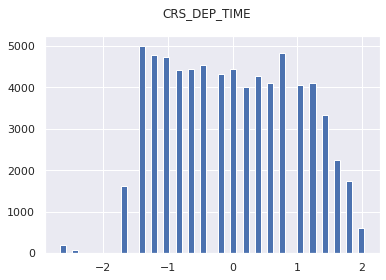

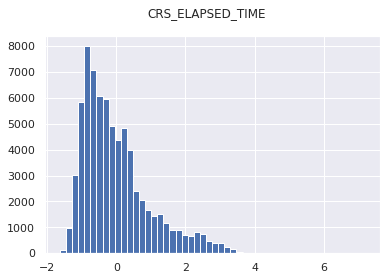

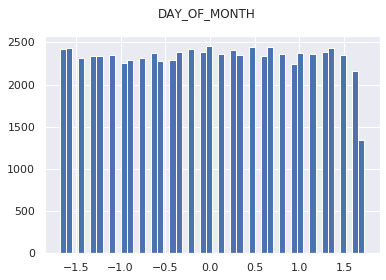

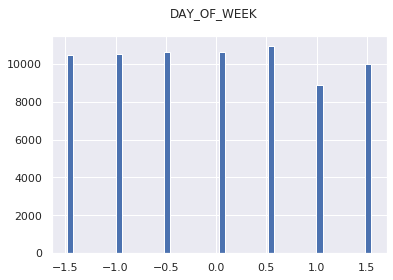

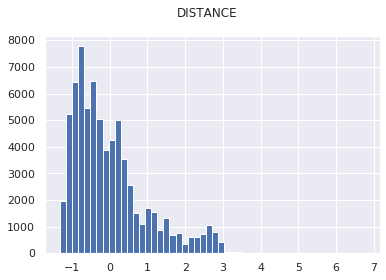

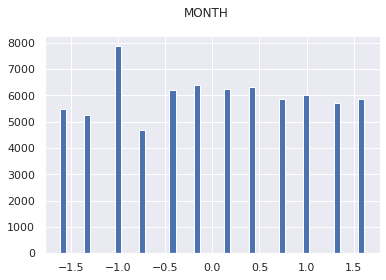

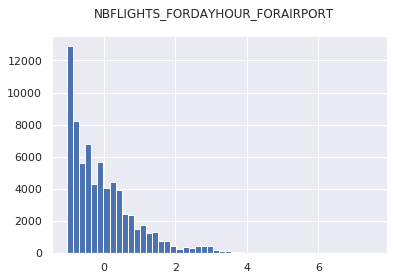

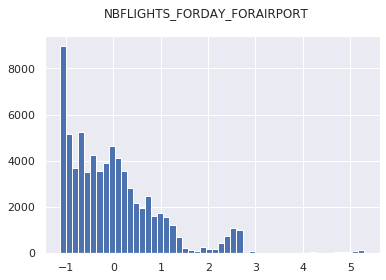

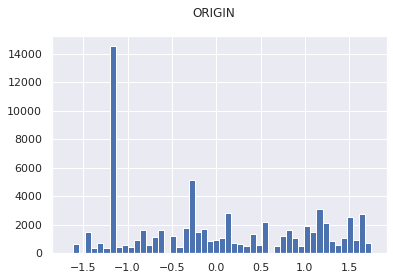

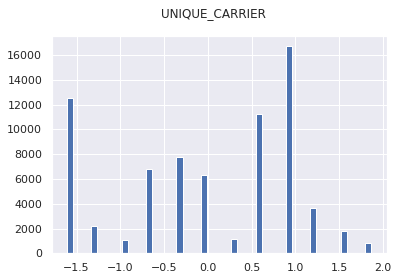

In [165]:
for feat_name in df_train_transformed.columns:
    if (feat_name in MODEL_GROUPBYMEAN2_FEATURES_QUANTITATIVE):
        fig = plt.figure()
        fig.suptitle(feat_name)
        plt.hist(df_train_transformed[feat_name], bins=50)
        plt.plot()

## Linear regression

In [166]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(df_train_transformed, df_train[model1_label])

df_test_predictions = lin_reg.predict(df_test_transformed)

print("Evaluation on test set :")
evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])

print('\n')

print("Evaluation on training set :")
evaluate_model(lin_reg, df_train_transformed, df_train[model1_label])

print('\n')

error_mean = evaluate_model_percent_mean(lin_reg, df_test_transformed, df_test[model1_label], 0.8)
print(f'Mean prediction error {EVALUATION_PERCENT*100}% of the time : {error_mean : .2f}')

Evaluation on test set :
RMSE : 27.181240312137405


Evaluation on training set :
RMSE : 27.131737354138156


Mean prediction error 90.0% of the time :  10.11


=> With new random forest (after cross validation), 80000 samples and train_test_split stratified on ARR_DELAY :
Evaluation on test set :  
RMSE : 27.181240312137405  

Evaluation on training set :  
RMSE : 27.131737354138156  

(array([  2.,   1.,   0.,   1.,   4.,  10.,  15.,  22.,  49.,  57.,  90.,
        107., 157., 161., 165., 179., 211., 249., 249., 283., 317., 326.,
        357., 376., 399., 364., 365., 344., 363., 331., 301., 324., 248.,
        254., 219., 181., 159., 166., 126., 142.,  93.,  84.,  51.,  52.,
         17.,  12.,   5.,   3.,   3.,   6.]),
 array([-14.16990745, -13.57789216, -12.98587687, -12.39386157,
        -11.80184628, -11.20983099, -10.6178157 , -10.0258004 ,
         -9.43378511,  -8.84176982,  -8.24975453,  -7.65773924,
         -7.06572394,  -6.47370865,  -5.88169336,  -5.28967807,
         -4.69766277,  -4.10564748,  -3.51363219,  -2.9216169 ,
         -2.3296016 ,  -1.73758631,  -1.14557102,  -0.55355573,
          0.03845957,   0.63047486,   1.22249015,   1.81450544,
          2.40652074,   2.99853603,   3.59055132,   4.18256661,
          4.7745819 ,   5.3665972 ,   5.95861249,   6.55062778,
          7.14264307,   7.73465837,   8.32667366,   8.91868895,
          9.510704

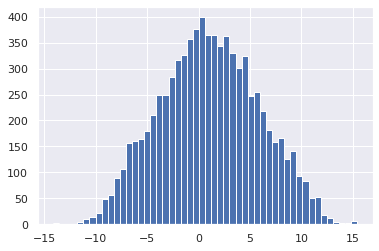

In [167]:
plt.hist(df_test_predictions, bins=50)

In [168]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison actual values / predict values on test set')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_test[model1_label], df_test_predictions, color='coral', alpha=0.1)

In [169]:
if (EXECUTE_INTERMEDIATE_MODELS == True):

    g = sns.jointplot(x=df_test[model1_label], y=df_test_predictions, kind='hex', color='blue', height=10)
    #sns.jointplot(x=df_test[model1_label], y=df_test_predictions, alpha=0.01)

    g.set_axis_labels("Actual", "Predicted")
    plt.subplots_adjust(top=0.9)
    plt.suptitle('Linear regression : comparison actual values / predict values on test set', fontsize = 16)
    
    plt.savefig('linreg_actual_vs_predicted.png', dpi=400)
    

In [170]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / predicted values on test set')
    plt.xlabel("Predicted")
    plt.ylabel("Actual - Predicted")
    plt.scatter(df_test_predictions, df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

In [171]:
if (EXECUTE_INTERMEDIATE_MODELS == True):

    g = sns.jointplot(x=df_test[model1_label], y=df_test[model1_label] - df_test_predictions, color='blue', kind='hex', height=10)
    #sns.jointplot(x=df_test[model1_label], y=df_test_predictions, alpha=0.01)

    g.set_axis_labels("Actual", "Actual - Predicted")
    plt.subplots_adjust(top=0.9)
    plt.suptitle('Linear regression : comparison residuals vs actual values on test set', fontsize = 16)
    
    plt.savefig('linreg_residuals_vs_actual.png', dpi=400)
    

In [172]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / actual values on test set')
    plt.xlabel("Actual")
    plt.ylabel("Actual - Predicted")
    plt.scatter(df_test[model1_label], df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

In [173]:
df_train_predictions = lin_reg.predict(df_train_transformed)

if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison actual values / predict values on training set')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_train[model1_label], df_train_predictions, color='coral', alpha=0.1)

In [174]:
df_test_transformed.columns

Index(['CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DAY_OF_MONTH', 'DAY_OF_WEEK',
       'DISTANCE', 'MONTH', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT',
       'NBFLIGHTS_FORDAY_FORAIRPORT', 'ORIGIN', 'UNIQUE_CARRIER'],
      dtype='object')

In [175]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Predicted - actual / CRS_ELAPSED_TIME values on test set')
    plt.xlabel("CRS_ELAPSED_TIME")
    plt.ylabel("Actual - Predicted")
    plt.scatter(df_test['CRS_ELAPSED_TIME'], df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

In [176]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    for column_name in df_test_transformed.columns:
        fig = plt.figure()
        fig.suptitle('Comparison Predicted - actual / values of one feature on test set')
        plt.xlabel(column_name)
        plt.ylabel("Actual - Predicted")
        plt.scatter(df_test_transformed[column_name], df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

In [177]:
lin_reg.coef_

array([ 3.68085973, -3.12021432,  0.1907334 ,  0.00607181,  2.81817524,
        0.3509075 ,  0.53622342, -0.18958902,  1.38588005,  2.20124182])

In [178]:
coef_feature_importances = (abs(lin_reg.coef_) / (abs(lin_reg.coef_).sum()))

In [179]:
coef_feature_importances.sum()

0.9999999999999999

In [180]:
df_feature_importances = pd.DataFrame(data = {'Feature name' : df_train_transformed.columns, 'Feature importance' : coef_feature_importances})

In [181]:
pd.concat([df_feature_importances.sort_values(by='Feature importance', ascending=False), \
           df_feature_importances[['Feature importance']].sort_values(by='Feature importance', ascending=False).cumsum()], axis=1)

Feature name  Feature importance  Feature importance
0                     CRS_DEP_TIME            0.254205            0.254205
1                 CRS_ELAPSED_TIME            0.215486            0.469691
4                         DISTANCE            0.194627            0.664318
9                   UNIQUE_CARRIER            0.152021            0.816338
8                           ORIGIN            0.095711            0.912049
6  NBFLIGHTS_FORDAYHOUR_FORAIRPORT            0.037032            0.949081
5                            MONTH            0.024234            0.973315
2                     DAY_OF_MONTH            0.013172            0.986487
7      NBFLIGHTS_FORDAY_FORAIRPORT            0.013093            0.999581
3                      DAY_OF_WEEK            0.000419            1.000000

## Random forest

In [182]:
%%time
from sklearn.ensemble import RandomForestRegressor

#if (EXECUTE_INTERMEDIATE_MODELS == True):
    #Old Random Fores before having done cross validation (done in group + mean sort encoding part)
    #random_reg = RandomForestRegressor(n_estimators=100, max_depth=100, n_jobs=-1, random_state=42)
    
random_reg = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                  max_features=4, max_leaf_nodes=None,
                  min_impurity_decrease=0.0, min_impurity_split=None,
                  min_samples_leaf=1, min_samples_split=2,
                  min_weight_fraction_leaf=0.0, n_estimators=1000,
                  n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                  warm_start=False)

random_reg.fit(df_train_transformed, df_train[model1_label])

CPU times: user 2min 36s, sys: 448 ms, total: 2min 37s
Wall time: 22.2 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [183]:
print("Evaluation on test set :")
evaluate_model(random_reg, df_test_transformed, df_test[model1_label])

print('\n')

print("Evaluation on training set :")
evaluate_model(random_reg, df_train_transformed, df_train[model1_label])

print('\n')

error_mean = evaluate_model_percent_mean(random_reg, df_test_transformed, df_test[model1_label], 0.8)
print(f'Mean prediction error {EVALUATION_PERCENT*100}% of the time : {error_mean : .2f}')

Evaluation on test set :
RMSE : 26.727603337896312


Evaluation on training set :
RMSE : 25.28427960714828


Mean prediction error 90.0% of the time :  9.89


With new random forest (after cross validation):  
    With shuffle split by ARR_DELAY strategy :    
    
Evaluation on test set :  
RMSE : 26.727603337896312  


Evaluation on training set :  
RMSE : 25.28427960714828  

Mean prediction error 90.0% of the time :  9.89


In [184]:
df_test_predictions = random_reg.predict(df_test_transformed)

In [185]:
df_train_predictions = random_reg.predict(df_train_transformed)

In [186]:
if (EXECUTE_INTERMEDIATE_MODELS == True):

    g = sns.jointplot(x=df_test[model1_label], y=df_test_predictions, kind='hex', color='blue', height=10)
    #sns.jointplot(x=df_test[model1_label], y=df_test_predictions, alpha=0.01)
    
    g.set_axis_labels("Actual", "Predicted")
    
    plt.subplots_adjust(top=0.9)
    plt.suptitle('Random forest : comparison actual values / predict values on test set', fontsize = 16)
    
    plt.savefig('random_reg_actual_vs_predicted.png')
    

In [187]:
if (EXECUTE_INTERMEDIATE_MODELS == True):

    g = sns.jointplot(x=df_test_predictions, y=df_test[model1_label] - df_test_predictions, kind='hex', color='blue', height=10)
    #sns.jointplot(x=df_test[model1_label], y=df_test_predictions, alpha=0.01)
    
    g.set_axis_labels("Predicted", "Actual - Predicted")
    
    plt.subplots_adjust(top=0.9)
    plt.suptitle('Random forest : Comparison Actual - predicted / predicted values on test set', fontsize = 16)
    
    plt.savefig('random_reg_residuals_vs_predicted.png')
    

In [188]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / predicted values on test set')
    plt.xlabel("Predicted")
    plt.ylabel("Actual - Predicted")
    plt.scatter(df_test_predictions, df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

In [189]:
if (EXECUTE_INTERMEDIATE_MODELS == True):

    g = sns.jointplot(x=df_test[model1_label], y=df_test[model1_label] - df_test_predictions, color='blue', kind='hex', height=10)
    #sns.jointplot(x=df_test[model1_label], y=df_test_predictions, alpha=0.01)

    g.set_axis_labels("Actual", "Actual - Predicted")
    plt.subplots_adjust(top=0.9)
    plt.suptitle('Random forest : comparison residuals vs actual values on test set', fontsize = 16)
    
    plt.savefig('randomreg_residuals_vs_actual.png', dpi=400)

In [190]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / actual values on test set')
    plt.xlabel("Actual label")
    plt.ylabel("Actual label - Predicted label")
    plt.scatter(df_test[model1_label], df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

In [191]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / predicted values on training set')
    plt.xlabel("Actual label")
    plt.ylabel("Actual label - Predicted label")
    plt.scatter(df_train[model1_label], df_train[model1_label] - df_train_predictions, color='blue', alpha=0.1)

In [192]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / instance numbers on training set')
    plt.xlabel("Instance number")
    plt.ylabel("Actual label - Predicted label")
    plt.scatter(range(df_train.shape[0]), df_train[model1_label] - df_train_predictions, color='blue', alpha=0.1)

In [193]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Predicted - actual / CRS_ELAPSED_TIME values on test set')
    plt.xlabel("CRS_ELAPSED_TIME")
    plt.ylabel("Actual - Predicted")
    plt.scatter(df_test['CRS_ELAPSED_TIME'], df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

In [194]:
df_train_predictions = random_reg.predict(df_train_transformed)

if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Random forest : Comparison actual values / predict values on training set')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_train[model1_label], df_train_predictions, color='coral', alpha=0.1)

In [195]:
df_train_transformed.columns

Index(['CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DAY_OF_MONTH', 'DAY_OF_WEEK',
       'DISTANCE', 'MONTH', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT',
       'NBFLIGHTS_FORDAY_FORAIRPORT', 'ORIGIN', 'UNIQUE_CARRIER'],
      dtype='object')

In [196]:
pd.set_option('display.max_rows', 200)

In [197]:
df_feature_importances = pd.DataFrame(data = {'Feature name' : df_train_transformed.columns, 'Feature importance' : random_reg.feature_importances_})

In [198]:
pd.concat([df_feature_importances.sort_values(by='Feature importance', ascending=False), \
           df_feature_importances[['Feature importance']].sort_values(by='Feature importance', ascending=False).cumsum()], axis=1)

Feature name  Feature importance  Feature importance
0                     CRS_DEP_TIME            0.180228            0.180228
7      NBFLIGHTS_FORDAY_FORAIRPORT            0.124045            0.304273
1                 CRS_ELAPSED_TIME            0.108863            0.413136
4                         DISTANCE            0.103135            0.516271
5                            MONTH            0.099276            0.615547
9                   UNIQUE_CARRIER            0.096106            0.711653
2                     DAY_OF_MONTH            0.089607            0.801259
6  NBFLIGHTS_FORDAYHOUR_FORAIRPORT            0.080543            0.881802
8                           ORIGIN            0.067930            0.949732
3                      DAY_OF_WEEK            0.050268            1.000000

In [199]:
random_reg.feature_importances_

array([0.18022792, 0.10886316, 0.0896068 , 0.05026828, 0.10313471,
       0.09927571, 0.08054286, 0.1240452 , 0.06792952, 0.09610583])

In [200]:
random_reg.feature_importances_.cumsum()

array([0.18022792, 0.28909109, 0.37869789, 0.42896617, 0.53210088,
       0.63137659, 0.71191945, 0.83596465, 0.90389417, 1.        ])

=> feature importance : 

In [201]:
random_reg.estimators_[0]

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=4,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=1608637542, splitter='best')

In [202]:
'''
from sklearn.tree import export_graphviz
export_graphviz(random_reg.estimators_[0], out_file="tree.dot", rounded=True, filled=True)
'''

'\nfrom sklearn.tree import export_graphviz\nexport_graphviz(random_reg.estimators_[0], out_file="tree.dot", rounded=True, filled=True)\n'

In [203]:
LEARNING_CURVE_STEP_SIZE

8000

In [204]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    #df_test_predictions = random_reg.predict(df_test_transformed)
    #evaluate_model(random_reg, df_test_transformed, df_test[model1_label])
    plot_learning_curves(random_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], int(LEARNING_CURVE_STEP_SIZE))

# New try with 3 quantitative features including DEP_DELAY

In [181]:
if (DATA_LOADED == True):
    del df
    del df_train
    del df_test
    del df_train_transformed
    del df_test_transformed

In [22]:
df = load_data()

In [23]:
df

ORIGIN CRS_DEP_TIME  MONTH  DAY_OF_MONTH  DAY_OF_WEEK UNIQUE_CARRIER  \
0          BOS         0600      9             1            4             AA   
1          BOS         0600      9             2            5             AA   
2          BOS         0600      9             6            2             AA   
3          BOS         0600      9             8            4             AA   
4          BOS         0600      9             9            5             AA   
...        ...          ...    ...           ...          ...            ...   
5547823    MEM         0600      8            31            3             WN   
5547824    MEM         0750      8            31            3             WN   
5547825    MEM         1015      8            31            3             WN   
5547826    MEM         1825      8            31            3             WN   
5547827    MEM         1150      8            31            3             WN   

        DEST CRS_ARR_TIME  DISTANCE  CRS_ELAPSED_TIME  ARR_DELAY  DEP_DELAY  \
0        JFK         0715     187.0              75.0      -23.0       -9.0   
1        JFK         0715     187.0              75.0       -6.0       -8.0   
2        JFK         0715     187.0              75.0      -19.0       -4.0   
3        JFK         0715     187.0              75.0      -27.0       -8.0   
4        JFK         0715     187.0              75.0      -21.0       -8.0   
...      ...          ...       ...               ...        ...        ...   
5547823  HOU         0735     484.0              95.0       21.0       -5.0   
5547824  MCO         1045     684.0             115.0       -3.0       -5.0   
5547825  MDW         1150     480.0              95.0       -5.0      -10.0   
5547826  MDW         1955     480.0              90.0      -14.0       -6.0   
5547827  TPA         1440     655.0             110.0       10.0       -5.0   

         TAXI_OUT TAIL_NUM  NBFLIGHTS_FORDAY_FORAIRPORT  \
0            13.0   N798AA                          370   
1            26.0   N797AA                          369   
2            12.0   N797AA                          355   
3            12.0   N784AA                          351   
4            17.0   N798AA                          352   
...           ...      ...                          ...   
5547823       8.0   N7876A                           40   
5547824      12.0   N7832A                           40   
5547825      15.0   N942WN                           40   
5547826       8.0   N965WN                           40   
5547827      20.0   N653SW                           40   

         NBFLIGHTS_FORDAYHOUR_FORAIRPORT  
0                                     30  
1                                     32  
2                                     28  
3                                     32  
4                                     32  
...                                  ...  
5547823                                6  
5547824                                5  
5547825                                2  
5547826                                3  
5547827                                5  

[5438823 rows x 16 columns]

In [24]:
all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)

Quantitative features : ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT'] 

Qualitative features : ['ORIGIN', 'CRS_DEP_TIME', 'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'TAIL_NUM'] 



In [25]:
df, df_train, df_test = custom_train_test_split_sample_random(df)

In [26]:
#df_train_transformed = preparation_pipeline_meansort_standardscale.fit_transform(df_train, categoricalfeatures_1hotencoder__categorical_features_totransform=None)

In [27]:
#df_train_transformed = preparation_pipeline_3feats_stdscale.fit_transform(df_train, categoricalfeatures_1hotencoder__categorical_features_totransform=None)
df_train_transformed = preparation_pipeline_3feats_stdscale.fit_transform(df_train)
df_test_transformed = preparation_pipeline_3feats_stdscale.transform(df_test)
DATA_LOADED = True
df_test_transformed.shape

Features selected (in order): Index(['DEP_DELAY', 'DISTANCE', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT'], dtype='object')
Features selected (in order): Index(['DEP_DELAY', 'DISTANCE', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT'], dtype='object')


(8000, 3)

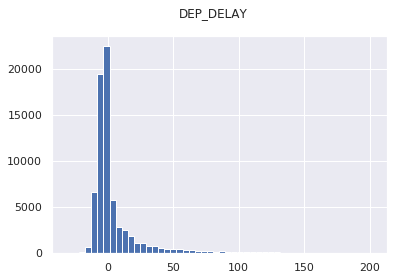

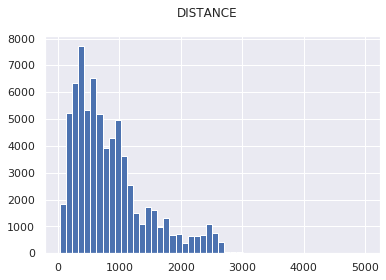

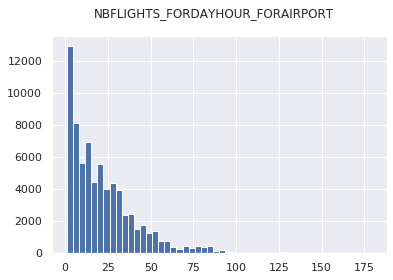

In [28]:
for feat_name in df_train_transformed.columns:
    if (feat_name in MODEL1_3FEATS_QUANTITATIVE):
        fig = plt.figure()
        fig.suptitle(feat_name)
        plt.hist(df_train_transformed[feat_name], bins=50)
        plt.plot()

## Linear regression

In [29]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(df_train_transformed, df_train[model1_label])

df_test_predictions = lin_reg.predict(df_test_transformed)

print("Evaluation on test set :")
evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])

print('\n')

print("Evaluation on training set :")
evaluate_model(lin_reg, df_train_transformed, df_train[model1_label])

Evaluation on test set :
RMSE : 12.143066137062153


Evaluation on training set :
RMSE : 12.379000425375388


In [30]:
error_mean = evaluate_model_percent_mean(lin_reg, df_test_transformed, df_test[model1_label], 0.8)
print(f'Mean prediction error {EVALUATION_PERCENT*100}% of the time : {error_mean : .2f}')

error_mean_worst = evaluate_model_percent_worst_mean(lin_reg, df_test_transformed, df_test[model1_label], 0.8)
print(f'Mean prediction error {100 - (EVALUATION_PERCENT)*100}% of the time : {error_mean_worst : .2f}')

Mean prediction error 90.0% of the time :  5.57
Mean prediction error 10.0% of the time :  21.33


(array([5.000e+00, 2.100e+01, 8.200e+01, 6.160e+02, 2.024e+03, 2.515e+03,
        7.480e+02, 3.860e+02, 2.530e+02, 2.240e+02, 1.590e+02, 1.020e+02,
        1.080e+02, 7.300e+01, 7.600e+01, 7.500e+01, 5.000e+01, 4.600e+01,
        4.100e+01, 3.400e+01, 3.400e+01, 3.100e+01, 1.900e+01, 2.900e+01,
        2.100e+01, 1.400e+01, 1.500e+01, 1.500e+01, 1.100e+01, 1.900e+01,
        8.000e+00, 1.800e+01, 1.500e+01, 1.400e+01, 6.000e+00, 1.500e+01,
        6.000e+00, 1.100e+01, 8.000e+00, 9.000e+00, 7.000e+00, 2.000e+00,
        8.000e+00, 3.000e+00, 6.000e+00, 6.000e+00, 2.000e+00, 5.000e+00,
        3.000e+00, 2.000e+00]),
 array([-30.5955581 , -26.27833846, -21.96111882, -17.64389918,
        -13.32667954,  -9.0094599 ,  -4.69224026,  -0.37502062,
          3.94219902,   8.25941866,  12.5766383 ,  16.89385794,
         21.21107758,  25.52829722,  29.84551686,  34.1627365 ,
         38.47995614,  42.79717578,  47.11439542,  51.43161506,
         55.7488347 ,  60.06605434,  64.38327398,  68.70

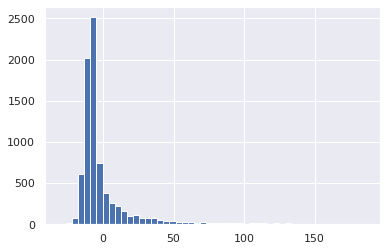

In [215]:
plt.hist(df_test_predictions, bins=50)

(array([1.020e+02, 1.770e+02, 3.430e+02, 5.190e+02, 7.910e+02, 9.340e+02,
        9.820e+02, 1.055e+03, 6.660e+02, 4.730e+02, 3.710e+02, 2.600e+02,
        2.000e+02, 1.620e+02, 1.350e+02, 9.400e+01, 8.100e+01, 7.600e+01,
        6.700e+01, 4.800e+01, 2.700e+01, 4.000e+01, 4.800e+01, 2.300e+01,
        2.200e+01, 2.100e+01, 2.300e+01, 1.700e+01, 2.100e+01, 1.600e+01,
        1.500e+01, 1.400e+01, 1.500e+01, 1.200e+01, 1.500e+01, 1.100e+01,
        1.300e+01, 1.200e+01, 1.800e+01, 8.000e+00, 8.000e+00, 1.100e+01,
        1.100e+01, 9.000e+00, 3.000e+00, 3.000e+00, 9.000e+00, 1.000e+00,
        5.000e+00, 1.300e+01]),
 array([-35.  , -30.86, -26.72, -22.58, -18.44, -14.3 , -10.16,  -6.02,
         -1.88,   2.26,   6.4 ,  10.54,  14.68,  18.82,  22.96,  27.1 ,
         31.24,  35.38,  39.52,  43.66,  47.8 ,  51.94,  56.08,  60.22,
         64.36,  68.5 ,  72.64,  76.78,  80.92,  85.06,  89.2 ,  93.34,
         97.48, 101.62, 105.76, 109.9 , 114.04, 118.18, 122.32, 126.46,
        130.6 , 

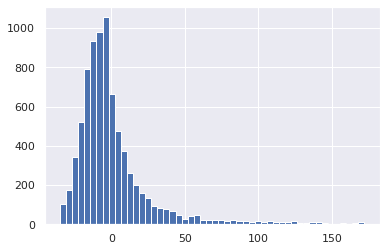

In [216]:
plt.hist(df_test[MODEL1_LABEL], bins=50)

In [217]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison actual values / predict values on test set')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_test[model1_label], df_test_predictions, color='coral', alpha=0.1)

In [218]:
if (EXECUTE_INTERMEDIATE_MODELS == True):

    g = sns.jointplot(x=df_test[model1_label], y=df_test_predictions, kind='hex', color='blue', height=10)
    #sns.jointplot(x=df_test[model1_label], y=df_test_predictions, alpha=0.01)

    g.set_axis_labels("Actual", "Predicted")
    plt.subplots_adjust(top=0.9)
    plt.suptitle('Model 2 : Comparison actual values / predict values on test set', fontsize = 16)
    
    plt.savefig('linreg_model2_actual_vs_predicted_training_set.png', dpi=400)
    

In [219]:
if (EXECUTE_INTERMEDIATE_MODELS == True):

    g = sns.jointplot(x=df_test[model1_label], y=df_test[model1_label] - df_test_predictions, color='blue', kind='hex', height=10)
    #sns.jointplot(x=df_test[model1_label], y=df_test_predictions, alpha=0.01)

    g.set_axis_labels("Actual", "Actual - Predicted")
    plt.subplots_adjust(top=0.9)
    plt.suptitle('Linear regression : comparison residuals vs actual values on test set', fontsize = 16)
    
    plt.savefig('linreg_model2_residuals_vs_actual.png', dpi=400)
    

In [220]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / predicted values on test set')
    plt.xlabel("Predicted")
    plt.ylabel("Actual - Predicted")
    plt.scatter(df_test_predictions, df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

In [221]:
df_train_predictions = lin_reg.predict(df_train_transformed)

if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison actual values / predict values on training set')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_train[model1_label], df_train_predictions, color='coral', alpha=0.01)

In [222]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    for column_name in df_test_transformed.columns:
        fig = plt.figure()
        fig.suptitle('Comparison Predicted - actual / values of one feature on test set')
        plt.xlabel(column_name)
        plt.ylabel("Actual - Predicted")
        plt.scatter(df_test_transformed[column_name], df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

In [223]:
lin_reg.coef_

array([ 0.99460717, -0.00204133, -0.00979414])

In [224]:
coef_feature_importances = (abs(lin_reg.coef_) / (abs(lin_reg.coef_).sum()))

In [225]:
coef_feature_importances.sum()

0.9999999999999999

In [226]:
df_feature_importances = pd.DataFrame(data = {'Feature name' : df_train_transformed.columns, 'Feature importance' : coef_feature_importances})

In [227]:
pd.concat([df_feature_importances.sort_values(by='Feature importance', ascending=False), \
           df_feature_importances[['Feature importance']].sort_values(by='Feature importance', ascending=False).cumsum()], axis=1)

Feature name  Feature importance  Feature importance
0                        DEP_DELAY            0.988240            0.988240
2  NBFLIGHTS_FORDAYHOUR_FORAIRPORT            0.009731            0.997972
1                         DISTANCE            0.002028            1.000000

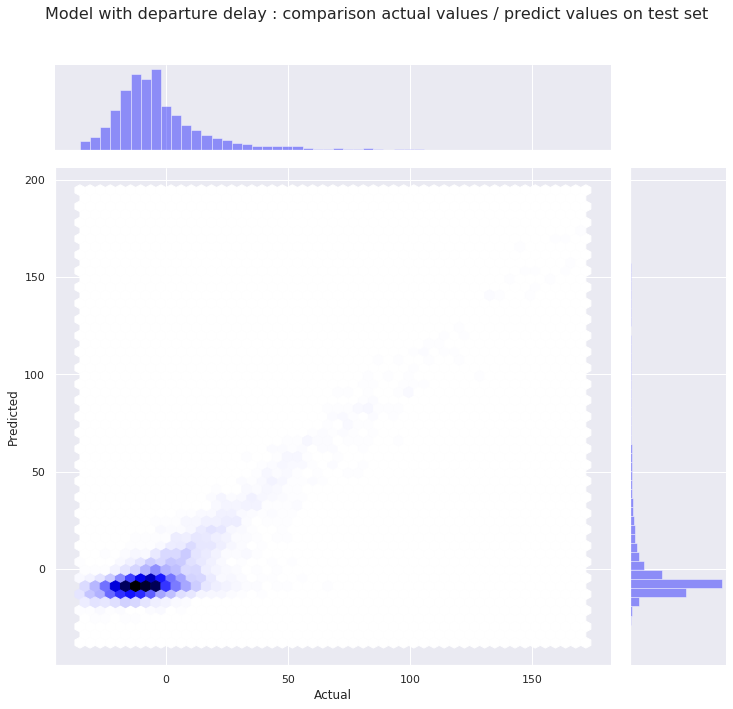

In [31]:
#if (EXECUTE_INTERMEDIATE_MODELS == True):

g = sns.jointplot(x=df_test[model1_label], y=df_test_predictions, kind='hex', color='blue', height=10)
#sns.jointplot(x=df_test[model1_label], y=df_test_predictions, alpha=0.01)

g.set_axis_labels("Actual", "Predicted")
plt.subplots_adjust(top=0.9)
plt.suptitle('Model with departure delay : comparison actual values / predict values on test set', fontsize = 16)

plt.savefig('linreg_model2_actual_vs_predicted_test_set.png', dpi=400)

## Random forest

In [32]:
%%time
from sklearn.ensemble import RandomForestRegressor

#if (EXECUTE_INTERMEDIATE_MODELS == True):
random_reg = RandomForestRegressor(n_estimators=200, max_depth=500, n_jobs=-1, random_state=42)
random_reg.fit(df_train_transformed, df_train[model1_label])

CPU times: user 46.2 s, sys: 533 ms, total: 46.7 s
Wall time: 6.94 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=500,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [33]:
print("Evaluation on test set :")
evaluate_model(random_reg, df_test_transformed, df_test[model1_label])

print('\n')

print("Evaluation on training set :")
evaluate_model(random_reg, df_train_transformed, df_train[model1_label])

Evaluation on test set :
RMSE : 13.33066517064774


Evaluation on training set :
RMSE : 5.716166600241706


In [48]:
error_mean = evaluate_model_percent_mean(random_reg, df_test_transformed, df_test[model1_label], 0.8)
print(f'Mean prediction error {EVALUATION_PERCENT*100}% of the time : {error_mean : .2f}')

error_mean_worst = evaluate_model_percent_worst_mean(random_reg, df_test_transformed, df_test[model1_label], 0.8)
print(f'Mean prediction error {100 - (EVALUATION_PERCENT)*100}% of the time : {error_mean_worst : .2f}')

Mean prediction error 90.0% of the time :  6.25
Mean prediction error 10.0% of the time :  23.62


In [34]:
df_test_predictions = random_reg.predict(df_test_transformed)

In [35]:
df_train_predictions = random_reg.predict(df_train_transformed)

In [36]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / predicted values on test set')
    plt.xlabel("Predicted")
    plt.ylabel("Actual - Predicted")
    plt.scatter(df_test_predictions, df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

In [37]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / actual values on test set')
    plt.xlabel("Actual label")
    plt.ylabel("Actual label - Predicted label")
    plt.scatter(df_test[model1_label], df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

In [38]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / actual values on training set')
    plt.xlabel("Actual label")
    plt.ylabel("Actual label - Predicted label")
    plt.scatter(df_train[model1_label], df_train[model1_label] - df_train_predictions, color='blue', alpha=0.1)

In [39]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / instance numbers on training set')
    plt.xlabel("Instance number")
    plt.ylabel("Actual label - Predicted label")
    plt.scatter(range(df_train.shape[0]), df_train[model1_label] - df_train_predictions, color='blue', alpha=0.01)

In [40]:
df_train_predictions = random_reg.predict(df_train_transformed)

if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Random forest : Comparison actual values / predict values on training set')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_train[model1_label], df_train_predictions, color='coral', alpha=0.1)

In [41]:
df_train_transformed.columns

Index(['DEP_DELAY', 'DISTANCE', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT'], dtype='object')

In [42]:
pd.set_option('display.max_rows', 200)

In [43]:
df_feature_importances = pd.DataFrame(data = {'Feature name' : df_train_transformed.columns, 'Feature importance' : random_reg.feature_importances_})

In [44]:
pd.concat([df_feature_importances.sort_values(by='Feature importance', ascending=False), \
           df_feature_importances[['Feature importance']].sort_values(by='Feature importance', ascending=False).cumsum()], axis=1)

Feature name  Feature importance  Feature importance
0                        DEP_DELAY            0.826749            0.826749
1                         DISTANCE            0.102613            0.929362
2  NBFLIGHTS_FORDAYHOUR_FORAIRPORT            0.070638            1.000000

In [49]:
df_feature_importances = pd.DataFrame(data = {'Feature name' : df_train_transformed.columns, 'Feature importance' : random_reg.feature_importances_})

df_feature_importances_global = pd.concat([df_feature_importances.sort_values(by='Feature importance', ascending=False), \
           df_feature_importances[['Feature importance']].rename(columns={'Feature importance' : 'Cumulated feature importance'}).sort_values(by='Cumulated feature importance', ascending=False).cumsum()], axis=1)

#df.style.set_properties(**{'text-align': 'center'})

df_feature_importances_global.style.format({
    'Feature importance': '{:,.2%}'.format,
    'Cumulated feature importance': '{:,.2%}'.format,
})

In [45]:
random_reg.feature_importances_

array([0.82674882, 0.10261283, 0.07063835])

In [46]:
random_reg.feature_importances_.cumsum()

array([0.82674882, 0.92936165, 1.        ])

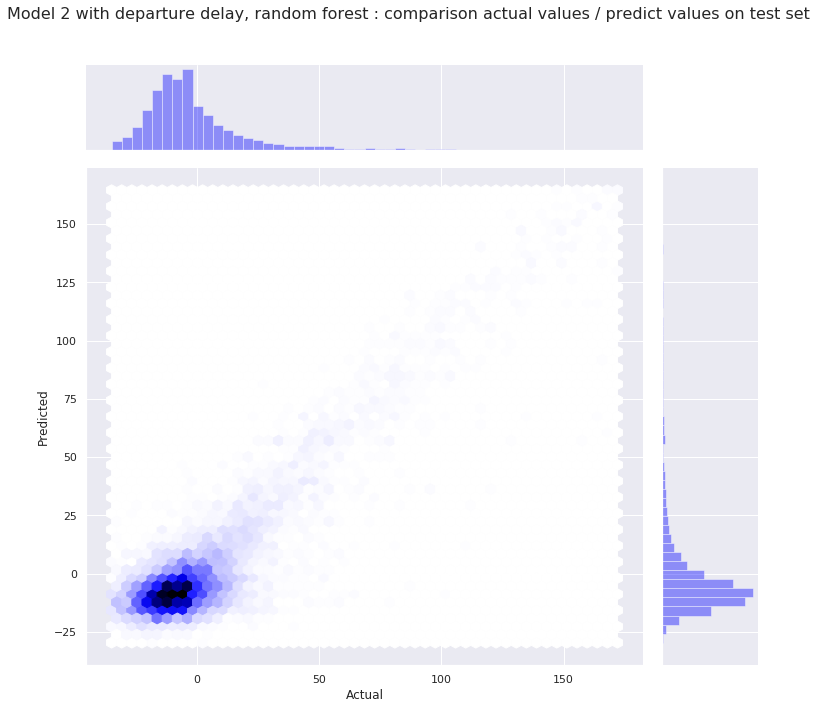

In [47]:
#if (EXECUTE_INTERMEDIATE_MODELS == True):

g = sns.jointplot(x=df_test[model1_label], y=df_test_predictions, kind='hex', color='blue', height=10)
#sns.jointplot(x=df_test[model1_label], y=df_test_predictions, alpha=0.01)

g.set_axis_labels("Actual", "Predicted")
plt.subplots_adjust(top=0.9)
plt.suptitle('Model 2 with departure delay, random forest : comparison actual values / predict values on test set', fontsize = 16)

plt.savefig('randomreg_model2_actual_vs_predicted_test_set.png', dpi=400)

In [243]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    plot_learning_curves(random_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE)

# New try with 2 quantitative features, not including DEP_DELAY

In [244]:
if (DATA_LOADED == True):
    del df
    del df_train
    del df_test
    del df_train_transformed
    del df_test_transformed

In [245]:
df = load_data()

In [246]:
df

ORIGIN CRS_DEP_TIME  MONTH  DAY_OF_MONTH  DAY_OF_WEEK UNIQUE_CARRIER  \
0          BOS         0600      9             1            4             AA   
1          BOS         0600      9             2            5             AA   
2          BOS         0600      9             6            2             AA   
3          BOS         0600      9             8            4             AA   
4          BOS         0600      9             9            5             AA   
...        ...          ...    ...           ...          ...            ...   
5547823    MEM         0600      8            31            3             WN   
5547824    MEM         0750      8            31            3             WN   
5547825    MEM         1015      8            31            3             WN   
5547826    MEM         1825      8            31            3             WN   
5547827    MEM         1150      8            31            3             WN   

        DEST CRS_ARR_TIME  DISTANCE  CRS_ELAPSED_TIME  ARR_DELAY  DEP_DELAY  \
0        JFK         0715     187.0              75.0      -23.0       -9.0   
1        JFK         0715     187.0              75.0       -6.0       -8.0   
2        JFK         0715     187.0              75.0      -19.0       -4.0   
3        JFK         0715     187.0              75.0      -27.0       -8.0   
4        JFK         0715     187.0              75.0      -21.0       -8.0   
...      ...          ...       ...               ...        ...        ...   
5547823  HOU         0735     484.0              95.0       21.0       -5.0   
5547824  MCO         1045     684.0             115.0       -3.0       -5.0   
5547825  MDW         1150     480.0              95.0       -5.0      -10.0   
5547826  MDW         1955     480.0              90.0      -14.0       -6.0   
5547827  TPA         1440     655.0             110.0       10.0       -5.0   

         TAXI_OUT TAIL_NUM  NBFLIGHTS_FORDAY_FORAIRPORT  \
0            13.0   N798AA                          370   
1            26.0   N797AA                          369   
2            12.0   N797AA                          355   
3            12.0   N784AA                          351   
4            17.0   N798AA                          352   
...           ...      ...                          ...   
5547823       8.0   N7876A                           40   
5547824      12.0   N7832A                           40   
5547825      15.0   N942WN                           40   
5547826       8.0   N965WN                           40   
5547827      20.0   N653SW                           40   

         NBFLIGHTS_FORDAYHOUR_FORAIRPORT  
0                                     30  
1                                     32  
2                                     28  
3                                     32  
4                                     32  
...                                  ...  
5547823                                6  
5547824                                5  
5547825                                2  
5547826                                3  
5547827                                5  

[5438823 rows x 16 columns]

In [247]:
all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)

Quantitative features : ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT'] 

Qualitative features : ['ORIGIN', 'CRS_DEP_TIME', 'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'TAIL_NUM'] 



In [248]:
df, df_train, df_test = custom_train_test_split_sample_random(df)

In [249]:
#df_train_transformed = preparation_pipeline_meansort_standardscale.fit_transform(df_train, categoricalfeatures_1hotencoder__categorical_features_totransform=None)

In [250]:
#df_train_transformed = preparation_pipeline_2feats_stdscale.fit_transform(df_train, categoricalfeatures_1hotencoder__categorical_features_totransform=None)
df_train_transformed = preparation_pipeline_2feats_stdscale.fit_transform(df_train)
df_test_transformed = preparation_pipeline_2feats_stdscale.transform(df_test)
DATA_LOADED = True
df_test_transformed.shape

Features selected (in order): Index(['DISTANCE', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT'], dtype='object')
Features selected (in order): Index(['DISTANCE', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT'], dtype='object')


(8000, 2)

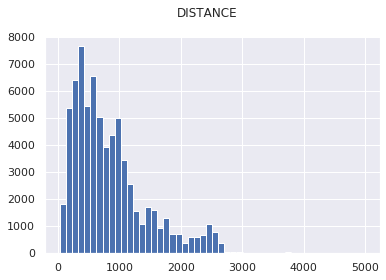

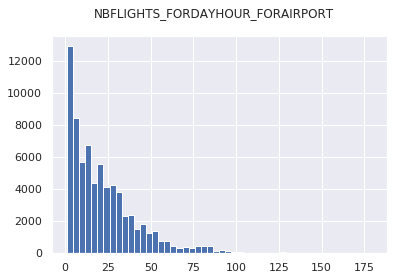

In [251]:
for feat_name in df_train_transformed.columns:
    if (feat_name in MODEL1_2FEATS_QUANTITATIVE):
        fig = plt.figure()
        fig.suptitle(feat_name)
        plt.hist(df_train_transformed[feat_name], bins=50)
        plt.plot()

## Linear regression

In [252]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(df_train_transformed, df_train[model1_label])

df_test_predictions = lin_reg.predict(df_test_transformed)

print("Evaluation on test set :")
evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])

print('\n')

print("Evaluation on training set :")
evaluate_model(lin_reg, df_train_transformed, df_train[model1_label])

Evaluation on test set :
RMSE : 27.317883872659444


Evaluation on training set :
RMSE : 27.47577821333289


(array([4.000e+00, 0.000e+00, 4.000e+00, 4.000e+00, 2.100e+01, 4.400e+01,
        7.300e+01, 1.640e+02, 4.070e+02, 8.950e+02, 1.105e+03, 8.680e+02,
        6.790e+02, 5.360e+02, 4.830e+02, 4.760e+02, 3.670e+02, 3.030e+02,
        3.020e+02, 2.070e+02, 1.790e+02, 1.500e+02, 1.290e+02, 8.800e+01,
        7.100e+01, 5.900e+01, 3.700e+01, 4.400e+01, 4.700e+01, 4.000e+01,
        5.800e+01, 3.800e+01, 3.000e+01, 1.800e+01, 1.800e+01, 8.000e+00,
        8.000e+00, 5.000e+00, 5.000e+00, 8.000e+00, 0.000e+00, 4.000e+00,
        3.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 4.000e+00]),
 array([-4.76534995e-01, -3.57325460e-01, -2.38115925e-01, -1.18906389e-01,
         3.03146086e-04,  1.19512681e-01,  2.38722217e-01,  3.57931752e-01,
         4.77141287e-01,  5.96350823e-01,  7.15560358e-01,  8.34769893e-01,
         9.53979429e-01,  1.07318896e+00,  1.19239850e+00,  1.31160803e+00,
         1.43081757e+00,  1.55002711e+00,  1.66923664e+00,  1.78844618e+

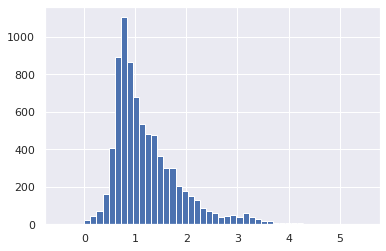

In [253]:
plt.hist(df_test_predictions, bins=50)

(array([ 109.,  188.,  308.,  523.,  798.,  985.,  974., 1097.,  644.,
         467.,  301.,  259.,  204.,  147.,  156.,   91.,   81.,   70.,
          64.,   53.,   50.,   49.,   32.,   38.,   24.,   19.,   25.,
          25.,   21.,   16.,   20.,   12.,   14.,   11.,   14.,   17.,
           9.,    7.,   13.,    6.,    5.,    8.,    4.,    8.,    5.,
           4.,    5.,    7.,    5.,    8.]),
 array([-35.  , -30.86, -26.72, -22.58, -18.44, -14.3 , -10.16,  -6.02,
         -1.88,   2.26,   6.4 ,  10.54,  14.68,  18.82,  22.96,  27.1 ,
         31.24,  35.38,  39.52,  43.66,  47.8 ,  51.94,  56.08,  60.22,
         64.36,  68.5 ,  72.64,  76.78,  80.92,  85.06,  89.2 ,  93.34,
         97.48, 101.62, 105.76, 109.9 , 114.04, 118.18, 122.32, 126.46,
        130.6 , 134.74, 138.88, 143.02, 147.16, 151.3 , 155.44, 159.58,
        163.72, 167.86, 172.  ]),
 <a list of 50 Patch objects>)

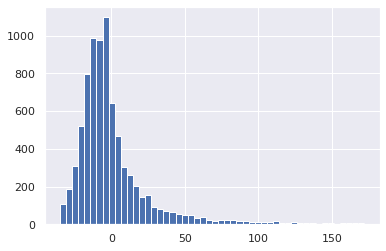

In [254]:
plt.hist(df_test[MODEL1_LABEL], bins=50)

In [255]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison actual values / predict values on test set')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_test[model1_label], df_test_predictions, color='coral', alpha=0.1)

In [256]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / predicted values on test set')
    plt.xlabel("Predicted")
    plt.ylabel("Actual - Predicted")
    plt.scatter(df_test_predictions, df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

In [257]:
df_train_predictions = lin_reg.predict(df_train_transformed)

if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison actual values / predict values on training set')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_train[model1_label], df_train_predictions, color='coral', alpha=0.01)

In [258]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    for column_name in df_test_transformed.columns:
        fig = plt.figure()
        fig.suptitle('Comparison Predicted - actual / values of one feature on test set')
        plt.xlabel(column_name)
        plt.ylabel("Actual - Predicted")
        plt.scatter(df_test_transformed[column_name], df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

In [259]:
lin_reg.coef_

array([-0.00030204,  0.03183178])

In [260]:
coef_feature_importances = (abs(lin_reg.coef_) / (abs(lin_reg.coef_).sum()))

In [261]:
coef_feature_importances.sum()

1.0

In [262]:
df_feature_importances = pd.DataFrame(data = {'Feature name' : df_train_transformed.columns, 'Feature importance' : coef_feature_importances})

In [263]:
pd.concat([df_feature_importances.sort_values(by='Feature importance', ascending=False), \
           df_feature_importances[['Feature importance']].sort_values(by='Feature importance', ascending=False).cumsum()], axis=1)

Feature name  Feature importance  Feature importance
1  NBFLIGHTS_FORDAYHOUR_FORAIRPORT            0.990601            0.990601
0                         DISTANCE            0.009399            1.000000

## Random forest

In [264]:
%%time
from sklearn.ensemble import RandomForestRegressor

#if (EXECUTE_INTERMEDIATE_MODELS == True):
random_reg = RandomForestRegressor(n_estimators=200, max_depth=500, n_jobs=-1, random_state=42)
random_reg.fit(df_train_transformed, df_train[model1_label])

CPU times: user 38.4 s, sys: 640 ms, total: 39.1 s
Wall time: 5.86 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=500,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [265]:
print("Evaluation on test set :")
evaluate_model(random_reg, df_test_transformed, df_test[model1_label])

print('\n')

print("Evaluation on training set :")
evaluate_model(random_reg, df_train_transformed, df_train[model1_label])

Evaluation on test set :
RMSE : 30.34697171099659


Evaluation on training set :
RMSE : 21.988997877193967


In [266]:
df_test_predictions = random_reg.predict(df_test_transformed)

In [267]:
df_train_predictions = random_reg.predict(df_train_transformed)

In [268]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / predicted values on test set')
    plt.xlabel("Predicted")
    plt.ylabel("Actual - Predicted")
    plt.scatter(df_test_predictions, df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

In [269]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / actual values on test set')
    plt.xlabel("Actual label")
    plt.ylabel("Actual label - Predicted label")
    plt.scatter(df_test[model1_label], df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

In [270]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / actual values on training set')
    plt.xlabel("Actual label")
    plt.ylabel("Actual label - Predicted label")
    plt.scatter(df_train[model1_label], df_train[model1_label] - df_train_predictions, color='blue', alpha=0.1)

In [271]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / instance numbers on training set')
    plt.xlabel("Instance number")
    plt.ylabel("Actual label - Predicted label")
    plt.scatter(range(df_train.shape[0]), df_train[model1_label] - df_train_predictions, color='blue', alpha=0.01)

In [272]:
df_train_predictions = random_reg.predict(df_train_transformed)

if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Random forest : Comparison actual values / predict values on training set')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_train[model1_label], df_train_predictions, color='coral', alpha=0.1)

In [273]:
df_train_transformed.columns

Index(['DISTANCE', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT'], dtype='object')

In [274]:
pd.set_option('display.max_rows', 200)

In [275]:
df_feature_importances = pd.DataFrame(data = {'Feature name' : df_train_transformed.columns, 'Feature importance' : random_reg.feature_importances_})

In [276]:
pd.concat([df_feature_importances.sort_values(by='Feature importance', ascending=False), \
           df_feature_importances[['Feature importance']].sort_values(by='Feature importance', ascending=False).cumsum()], axis=1)

Feature name  Feature importance  Feature importance
0                         DISTANCE            0.586914            0.586914
1  NBFLIGHTS_FORDAYHOUR_FORAIRPORT            0.413086            1.000000

In [277]:
random_reg.feature_importances_

array([0.58691389, 0.41308611])

In [278]:
random_reg.feature_importances_.cumsum()

array([0.58691389, 1.        ])

In [279]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    plot_learning_curves(random_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE)

# Annex : unused code

In [280]:
'''from sklearn import linear_model

regressor = linear_model.SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
regressor.fit(df_transformed, df_train[model1_label])
'''

'from sklearn import linear_model\n\nregressor = linear_model.SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)\nregressor.fit(df_transformed, df_train[model1_label])\n'

In [281]:
'''
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(df_train_transformed, df_train[model1_label])
'''

'\nfrom sklearn.svm import SVR\n\nsvm_reg = SVR(kernel="linear")\nsvm_reg.fit(df_train_transformed, df_train[model1_label])\n'

In [282]:
'''
df_test_predictions = svm_reg.predict(df_test_transformed)
svm_mse = mean_squared_error(df_test[model1_label], df_test_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse
'''

'\ndf_test_predictions = svm_reg.predict(df_test_transformed)\nsvm_mse = mean_squared_error(df_test[model1_label], df_test_predictions)\nsvm_rmse = np.sqrt(svm_mse)\nsvm_rmse\n'

In [283]:
'''
from sklearn.model_selection import StratifiedShuffleSplit

stratified_split_train = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
'''

'\nfrom sklearn.model_selection import StratifiedShuffleSplit\n\nstratified_split_train = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)\n'

poly = PolynomialFeatures(degree=3)
poly.fit(df_train_transformed)
df_train_transformed = poly.transform(df_train_transformed)
df_test_transformed = poly.transform(df_test_transformed)

df_train_transformed.shape

if (EXECUTE_INTERMEDIATE_MODELS == True):
    lin_reg = LinearRegression()
    lin_reg.fit(df_train_transformed, df_train[model1_label])

if (EXECUTE_INTERMEDIATE_MODELS == True):
    evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])

evaluate_model_MAE(lin_reg, df_test_transformed, df_test[model1_label])

# This code is now in a transformer function :
n_degrees = 3
n_features = df_train_transformed.shape[1]

nb_instances = df_train_transformed.shape[0]
df_poly = np.empty((nb_instances, 0)) # Create empty array of nb_instances line and 0 features yet (we'll concatenate polynomial features to it)

progbar = tqdm(range(n_features))
print('Adding polynomial features')

for feature_index in range(n_features):    
    df_1feature = df_train_transformed[:,feature_index]  # Reshape 
    
    for n_degree in range(n_degrees):
        df_poly = np.c_[df_poly, np.power(df_1feature, n_degree + 1)]
    
    progbar.update(1)
    
# Add bias (intercept)
df_poly = np.c_[df_poly, np.ones((len(df_poly), 1))]  # add x0 = 1 feature

X_train, X_test, income_train, income_test = tts( other_colums, income_column,
                         shuffle = True, stratify = Income_column)`

df.shape

df_labels_discrete = pd.cut(df['ARR_DELAY'], bins=50)

df_labels_discrete.head(50)

df[['ARR_DELAY']]

display_freq_table(df, ['ARR_DELAY'])

df['ARR_DELAY'].quantile([0,1])

df.ARR_DELAY.quantile(.01)

df[df['ARR_DELAY'] > df.ARR_DELAY.quantile(.99)]

df.loc[(df['ARR_DELAY'] < df.ARR_DELAY.quantile(.01)) | (df['ARR_DELAY'] > df.ARR_DELAY.quantile(.99)) , :]

((df['ARR_DELAY'] < df.ARR_DELAY.quantile(.01)) | (df['ARR_DELAY'] > df.ARR_DELAY.quantile(.99))).index

((df['ARR_DELAY'] < df.ARR_DELAY.quantile(.01)) | (df['ARR_DELAY'] > df.ARR_DELAY.quantile(.99)))

df.shape

df_labels_discrete.shape

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, df[model1_label], test_size=0.1, random_state=42, shuffle = True, stratify = df_labels_discrete)

from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df, test_size=0.1, random_state=42, shuffle = True, stratify = df_labels_discrete)

X_test

split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in split.split(df, df_labels_discrete):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

df_labels_discrete.value_counts()

df[['DEST']]

df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)

poly = ColumnTransformer([
                                ('poly', PolynomialFeatures(degree=2), [0, 1, 2, 3, 4, 5, 6])     
                                ], remainder='passthrough', sparse_threshold=1)

poly.fit(df_train_transformed, df_train[model1_label])

'''
#Too slow

from sklearn.ensemble import RandomForestRegressor

if (EXECUTE_INTERMEDIATE_MODELS == True):
    random_reg = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
    random_reg.fit(df_train_transformed, df_train[model1_label])
    
'''

'''
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_test_predictions = random_reg.predict(df_test_transformed)
    evaluate_model(random_reg, df_test_transformed, df_test[model1_label])
'''

# Add bias :
# Bias has been removed: its linear regression coeficient was 0
'''
df_train_transformed = np.c_[np.ones((len(df_train_transformed), 1)), df_train_transformed]  # add x0 = 1 to each instance
df_test_transformed = np.c_[np.ones((len(df_test_transformed), 1)), df_test_transformed]  # add x0 = 1 to each instance
'''

'''
# Commented out because memory error
polynomial_reg = Pipeline([('poly', PolynomialFeatures(degree=3)),
                          ('linear', LinearRegression(fit_intercept=False))])

polynomial_reg.fit(df_train_transformed, df_train[model1_label])
'''

%%time
from sklearn.ensemble import RandomForestRegressor

if (EXECUTE_INTERMEDIATE_MODELS == True):
    random_reg = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
    
    for i in range(10):
        print(f'Training {i}')
        df_train_residuals = df_train[model1_label] - df_train_predictions
        max_residual = df_train_residuals.abs().max()
        sample_weights = (max_residual - df_train_residuals.abs()) / max_residual
        
        df_train_residuals_mean = df_train_residuals.mean()
        print(f'Mean of residuals : {df_train_residuals_mean}')
        
        random_reg.fit(df_train_transformed, df_train[model1_label], sample_weights)

        df_train_predictions = random_reg.predict(df_train_transformed)




for feat_indice in range(df_train_transformed.shape[1]):
    fig = plt.figure()
    plt.hist(df_train_transformed.iloc[:, feat_indice], bins=50)